In [1]:
d20_traces = ['web/web-vm.bin', 'homes/homes.bin', 'mail/mail.bin', 'online/online.bin', 'webmail/webmail.bin', 'webresearch/webresearch.bin', 'webusers/webusers.bin']
d6_traces = ['msr/MSR-Cambridge/hm.bin', 'msr/MSR-Cambridge/mds.bin', 'msr/MSR-Cambridge/prn.bin', 'msr/MSR-Cambridge/proj.bin', 'msr/MSR-Cambridge/prxy.bin', 'msr/MSR-Cambridge/rsrch.bin']

In [ ]:
import multiprocessing
import subprocess

traces = ['online/online.bin', 'webmail/webmail.bin', 'webresearch/webresearch.bin', 'webusers/webusers.bin']
versioning_factor = "0.1"

n_cores = 3

def run_analyze_disk_usage_parallel(trace_filenames):
    
    def run_analyze_disk_usage(trace_file):
        # Call the analyze_disk_usage script with the trace file
        subprocess.run(['python3', 'analyze_disk_usage.py', trace_file, versioning_factor])

    processes = []

    # Create a process for each trace file
    for trace_file in trace_filenames[:n_cores]:
        p = multiprocessing.Process(target=run_analyze_disk_usage, args=(trace_file,))
        processes.append(p)
        p.start()

    # Wait for all processes to complete
    for p in processes:
        p.join()
    
    

for i in range(0, len(traces), n_cores):
    run_analyze_disk_usage_parallel(trace_filenames = traces[i:i+n_cores])
    print("Finished analyzing traces {0}-{1}".format(i, i+n_cores-1))

In [ ]:
import matplotlib.pyplot as plt

trace_logic_disk_usage = {
    "web/web-vm.bin": 70,
    "homes/homes.bin": 470,
}

# traces = d20_traces
traces = ["homes/homes.bin"]
versioning_factor = "0.1"

def plot_trend(trend_filename, disk_max=100):
    # Read disk_usage_trend back from the file
    read_disk_usage_trend = []
    with open(trend_filename, 'r') as file:
        for line in file:
            read_disk_usage_trend.append(eval(line.strip()))
    # Extract data for plotting
    accessed_blocks = [entry[0] for entry in read_disk_usage_trend]
    written_blocks = [entry[1] for entry in read_disk_usage_trend]
    versioning_block_count = [entry[2] for entry in read_disk_usage_trend]
    
    # Calculate the stacked areas
    versioning_overhead = [v - w for v, w in zip(versioning_block_count, written_blocks)]
    read_blocks = [a - v for a, v in zip(accessed_blocks, written_blocks)]
    
    def block_number_to_GB(block_number):
        return [a * 4.0 / 1e6 for a in block_number]
    
    read_GB = block_number_to_GB(read_blocks)
    written_GB = block_number_to_GB(written_blocks)
    untouched_GB = [disk_max - (r + w) for r, w in zip(read_GB, written_GB)]
    versioning_overhead_GB = block_number_to_GB(versioning_overhead)
    
    print("versioning_overhead GB: ", versioning_overhead_GB[-1])

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.stackplot(range(len(accessed_blocks)), read_GB, written_GB, untouched_GB, versioning_overhead_GB, labels=['Read only', 'Written', 'Versioning Overhead'])
    plt.xlabel('Checkpoint')
    plt.ylabel('Disk Usage (GB)')
    plt.title(f'Disk Usage Trend for {trend_filename}')
    plt.legend(loc='upper left')
    plt.show()

for trace in traces:
    trend_filename = trace + versioning_factor + ".trend"
    plot_trend(trend_filename, trace_logic_disk_usage[trace])
    print("Finished plotting trend for {0}".format(trace))

In [4]:
import datetime
import pickle

def parse_trace(trace_filename, start_time, traces):
    last_checkpoint = start_time
    checkpoint_time = datetime.timedelta(hours=1) 
    with open(trace_filename, 'r') as file:
        for line in file:
            # Split the line into components
            parts = line.strip().split()
            if len(parts) != 9:
                print("Skipped"+line)
                continue  # Skip lines that don't have enough parts

            # Extract the fields
            time = datetime.timedelta(milliseconds=int(parts[0])//1e6) + start_time
            lba = int(parts[3])
            size_blocks = int(parts[4])
            operation = parts[5]
            
            traces.append((time, lba, size_blocks, operation))
            
            # Print Time
            if last_checkpoint + checkpoint_time <= time:
                print(time.strftime("%Y-%m-%d %H:%M:%S"))
                last_checkpoint = time



def parse_traces_to_bin(trace_filenames, bin_filename): 
    start_time = datetime.datetime(year=2000, month=1, day=1)
    traces = []
    for filename in trace_filenames:
        parse_trace(filename, start_time, traces)
        print("Finish filename " + filename)
    
    # Write the traces list to a binary file
    with open(bin_filename, 'wb') as bin_file:
        pickle.dump(traces, bin_file)
    print(f"Traces written to {bin_filename}")

In [ ]:
import datetime

homes_traces = [f"homes/homes-110108-112108.{i}.blkparse" for i in range(1, 22)]
mails_traces = [f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(1, 22)]
web_vm_traces = [f"web/webmail+online.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(1, 22)]



# parse_traces_to_bin(homes_traces, "homes/home.time.bin")
# parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(1, 4)], "mail/mail0.time.bin")
# parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(4, 7)], "mail/mail1.time.bin")
# parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(7, 10)], "mail/mail2.time.bin")
# parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(10, 13)], "mail/mail3.time.bin")
# parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(13, 16)], "mail/mail4.time.bin")
# parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(16, 19)], "mail/mail5.time.bin")
# parse_traces_to_bin([f"mail/cheetah.cs.fiu.edu-110108-113008.{i}.blkparse" for i in range(19, 22)], "mail/mail6.time.bin")


# parse_traces_to_bin(web_vm_traces, "web/web.time.bin")


In [1]:
from analyze_versioning import parse_traces_to_bin
# parse_traces_to_bin(["MSR-Cambridge/hm_0.csv"], "MSR-Cambridge/hm_0.time.bin")
# parse_traces_to_bin(["MSR-Cambridge/hm_1.csv"], "MSR-Cambridge/hm_1.time.bin")
# parse_traces_to_bin(["MSR-Cambridge/prn_0.csv"], "MSR-Cambridge/prn_0.time.bin")
# parse_traces_to_bin(["MSR-Cambridge/prn_1.csv"], "MSR-Cambridge/prn_1.time.bin")
# parse_traces_to_bin(["MSR-Cambridge/proj_0.csv"], "MSR-Cambridge/proj_0.time.bin")
# parse_traces_to_bin(["MSR-Cambridge/proj_1.csv"], "MSR-Cambridge/proj_1.time.bin")
# parse_traces_to_bin(["MSR-Cambridge/proj_2.csv"], "MSR-Cambridge/proj_2.time.bin")
# parse_traces_to_bin(["MSR-Cambridge/proj_3.csv"], "MSR-Cambridge/proj_3.time.bin")


# parse_traces_to_bin(["MSR-Cambridge/prxy_0.csv"], "MSR-Cambridge/prxy_0.time.bin")
# parse_traces_to_bin(["MSR-Cambridge/prxy_1.csv"], "MSR-Cambridge/prxy_1.time.bin")
parse_traces_to_bin(["MSR-Cambridge/rsrch_0.csv"], "MSR-Cambridge/rsrch_0.time.bin")
parse_traces_to_bin(["MSR-Cambridge/rsrch_1.csv"], "MSR-Cambridge/rsrch_1.time.bin")
parse_traces_to_bin(["MSR-Cambridge/rsrch_2.csv"], "MSR-Cambridge/rsrch_2.time.bin")
parse_traces_to_bin(["MSR-Cambridge/src1_0.csv"], "MSR-Cambridge/src1_0.time.bin")
parse_traces_to_bin(["MSR-Cambridge/src1_1.csv"], "MSR-Cambridge/src1_1.time.bin")
parse_traces_to_bin(["MSR-Cambridge/src1_2.csv"], "MSR-Cambridge/src1_2.time.bin")
parse_traces_to_bin(["MSR-Cambridge/src2_0.csv"], "MSR-Cambridge/src2_0.time.bin")
parse_traces_to_bin(["MSR-Cambridge/src2_1.csv"], "MSR-Cambridge/src2_1.time.bin")
parse_traces_to_bin(["MSR-Cambridge/src2_2.csv"], "MSR-Cambridge/src2_2.time.bin")


parse_traces_to_bin(["MSR-Cambridge/stg_0.csv"], "MSR-Cambridge/stg_0.time.bin")
parse_traces_to_bin(["MSR-Cambridge/stg_1.csv"], "MSR-Cambridge/stg_1.time.bin")
parse_traces_to_bin(["MSR-Cambridge/ts_0.csv"], "MSR-Cambridge/ts_0.time.bin")
parse_traces_to_bin(["MSR-Cambridge/usr_0.csv"], "MSR-Cambridge/usr_0.time.bin")
parse_traces_to_bin(["MSR-Cambridge/usr_1.csv"], "MSR-Cambridge/usr_1.time.bin")
parse_traces_to_bin(["MSR-Cambridge/usr_2.csv"], "MSR-Cambridge/usr_2.time.bin")

parse_traces_to_bin(["MSR-Cambridge/wdev_0.csv"], "MSR-Cambridge/wdev_0.time.bin")
parse_traces_to_bin(["MSR-Cambridge/wdev_1.csv"], "MSR-Cambridge/wdev_1.time.bin")
parse_traces_to_bin(["MSR-Cambridge/wdev_2.csv"], "MSR-Cambridge/wdev_2.time.bin")
parse_traces_to_bin(["MSR-Cambridge/wdev_3.csv"], "MSR-Cambridge/wdev_3.time.bin")


parse_traces_to_bin(["MSR-Cambridge/web_0.csv"], "MSR-Cambridge/web_0.time.bin")
parse_traces_to_bin(["MSR-Cambridge/web_1.csv"], "MSR-Cambridge/web_1.time.bin")
parse_traces_to_bin(["MSR-Cambridge/web_2.csv"], "MSR-Cambridge/web_2.time.bin")
parse_traces_to_bin(["MSR-Cambridge/web_3.csv"], "MSR-Cambridge/web_3.time.bin")



2007-02-22 17:00:00
2007-02-22 18:00:03
2007-02-22 19:00:08
2007-02-22 20:00:08
2007-02-22 21:00:13
2007-02-22 22:00:15
2007-02-22 23:00:16
2007-02-23 00:00:17
2007-02-23 01:00:18
2007-02-23 02:00:19
2007-02-23 03:00:23
2007-02-23 04:00:28
2007-02-23 05:00:28
2007-02-23 06:00:29
2007-02-23 07:00:29
2007-02-23 08:00:30
2007-02-23 09:00:30
2007-02-23 10:00:30
2007-02-23 11:00:31
2007-02-23 12:00:35
2007-02-23 13:00:36
2007-02-23 14:00:40
2007-02-23 15:00:40
2007-02-23 16:00:41
2007-02-23 17:00:42
2007-02-23 18:00:43
2007-02-23 19:00:47
2007-02-23 20:00:48
2007-02-23 21:00:50
2007-02-23 22:00:50
2007-02-23 23:00:53
2007-02-24 00:00:54
2007-02-24 01:00:55
2007-02-24 02:00:56
2007-02-24 03:00:56
2007-02-24 04:00:58
2007-02-24 05:00:59
2007-02-24 06:01:00
2007-02-24 07:01:01
2007-02-24 08:01:03
2007-02-24 09:01:05
2007-02-24 10:01:05
2007-02-24 11:01:05
2007-02-24 12:01:07
2007-02-24 13:01:08
2007-02-24 14:01:10
2007-02-24 15:01:11
2007-02-24 16:01:12
2007-02-24 17:01:13
2007-02-24 18:01:14


In [ ]:
from analyze_versioning import analyze_disk_usage
import datetime
# analyze_disk_usage(["homes/homes.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=2))
# analyze_disk_usage(["homes/homes.time.bin"], datetime.timedelta(hours=0), datetime.timedelta(days=2))
# analyze_disk_usage(["homes/homes.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=10))
# analyze_disk_usage(["homes/homes.time.bin"], datetime.timedelta(hours=0), datetime.timedelta(days=10))
# analyze_disk_usage(["homes/homes.time.bin"], datetime.timedelta(hours=0), datetime.timedelta(days=50))

# mail_bins = ["mail/mail0.time.bin", "mail/mail1.time.bin", "mail/mail2.time.bin", "mail/mail3.time.bin", "mail/mail4.time.bin", "mail/mail5.time.bin", "mail/mail6.time.bin"]
# analyze_disk_usage(mail_bins, datetime.timedelta(hours=1), datetime.timedelta(days=2))


# analyze_disk_usage(["web/web.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=2))
# analyze_disk_usage(["web/web.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=10))
# analyze_disk_usage(["web/web.time.bin"], datetime.timedelta(hours=0), datetime.timedelta(days=2))
# analyze_disk_usage(["web/web.time.bin"], datetime.timedelta(hours=0), datetime.timedelta(days=10))
# analyze_disk_usage(["web/web.time.bin"], datetime.timedelta(hours=0), datetime.timedelta(days=50))

In [ ]:
from analyze_versioning import analyze_disk_usage
import datetime
analyze_disk_usage(["MSR-Cambridge/hm_0.time.bin"], datetime.timedelta(hours=0), datetime.timedelta(days=10))

In [3]:

from analyze_versioning import analyze_disk_usage
import datetime

# analyze_disk_usage(["MSR-Cambridge/hm_0.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=2))
# analyze_disk_usage(["MSR-Cambridge/hm_0.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=10))
# analyze_disk_usage(["MSR-Cambridge/hm_1.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=2))
# analyze_disk_usage(["MSR-Cambridge/hm_1.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=10))
# analyze_disk_usage(["MSR-Cambridge/prn_0.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=2))
# analyze_disk_usage(["MSR-Cambridge/prn_0.time.bin"], datetime.timedelta(hours=1), datetime.timedelta(days=10))



import glob
# Find all files matching the pattern
files = glob.glob('MSR-Cambridge/**/*.time.bin', recursive=True)
files = [
        # 'MSR-Cambridge/hm_0.time.bin',
        #  'MSR-Cambridge/hm_1.time.bin', 
        #  'MSR-Cambridge/proj_0.time.bin', 
        #  'MSR-Cambridge/proj_1.time.bin', 
        #  'MSR-Cambridge/proj_2.time.bin', 
        #  'MSR-Cambridge/proj_3.time.bin', 
        #  'MSR-Cambridge/prn_1.time.bin', 
        #  'MSR-Cambridge/prn_0.time.bin', 
        'MSR-Cambridge/prxy_0.time.bin', 
        'MSR-Cambridge/prxy_1.time.bin', 
        'MSR-Cambridge/rsrch_0.time.bin', 
        'MSR-Cambridge/rsrch_1.time.bin', 
        'MSR-Cambridge/rsrch_2.time.bin', 
        'MSR-Cambridge/src1_0.time.bin', 
        'MSR-Cambridge/src1_1.time.bin',
        'MSR-Cambridge/src1_2.time.bin',
        'MSR-Cambridge/src2_0.time.bin',
        'MSR-Cambridge/src2_1.time.bin',
        'MSR-Cambridge/src2_2.time.bin',
         ]

setups = [(1, 2), (1, 10)]

for f in files:
    for epoch, days in setups:
        analyze_disk_usage([f], datetime.timedelta(hours=epoch), datetime.timedelta(days=days))

print(files)

2007-02-22 17:00:00...  Accessed: 0.00 GB  Written 0.00 GB  vs Versioning 0.00 GB  + cache 0.00 GB versioning meta 0.00 GB Max 727.33 GB
2007-02-22 17:30:00...  Accessed: 0.02 GB  Written 0.46 GB  vs Versioning 0.00 GB  + cache 0.46 GB versioning meta 0.00 GB Max 880.32 GB
2007-02-22 18:00:01...  Accessed: 0.03 GB  Written 0.92 GB  vs Versioning 0.92 GB  + cache 0.00 GB versioning meta 0.00 GB Max 880.61 GB
2007-02-22 18:30:01...  Accessed: 0.04 GB  Written 1.33 GB  vs Versioning 0.92 GB  + cache 0.46 GB versioning meta 0.00 GB Max 880.61 GB
2007-02-22 19:00:01...  Accessed: 0.06 GB  Written 1.83 GB  vs Versioning 1.91 GB  + cache 0.01 GB versioning meta 0.00 GB Max 880.70 GB
2007-02-22 19:30:02...  Accessed: 0.77 GB  Written 2.62 GB  vs Versioning 1.91 GB  + cache 0.89 GB versioning meta 0.01 GB Max 880.74 GB
2007-02-22 20:00:02...  Accessed: 0.77 GB  Written 2.83 GB  vs Versioning 3.01 GB  + cache 0.00 GB versioning meta 0.01 GB Max 880.74 GB
2007-02-22 20:30:02...  Accessed: 0.78 GB

Invalid plot_FS_size
logic_disk_usage_GB:  880
max_version_FS:  884.496346448
written GB:  9.635569664
read GB:  739.93766912
old versions GB:  4.467269632
TL Metadata GB:  1.71875
Versioning Metadata GB:  0.053394032
filesystem size GB:  880


<Figure size 1800x1200 with 0 Axes>

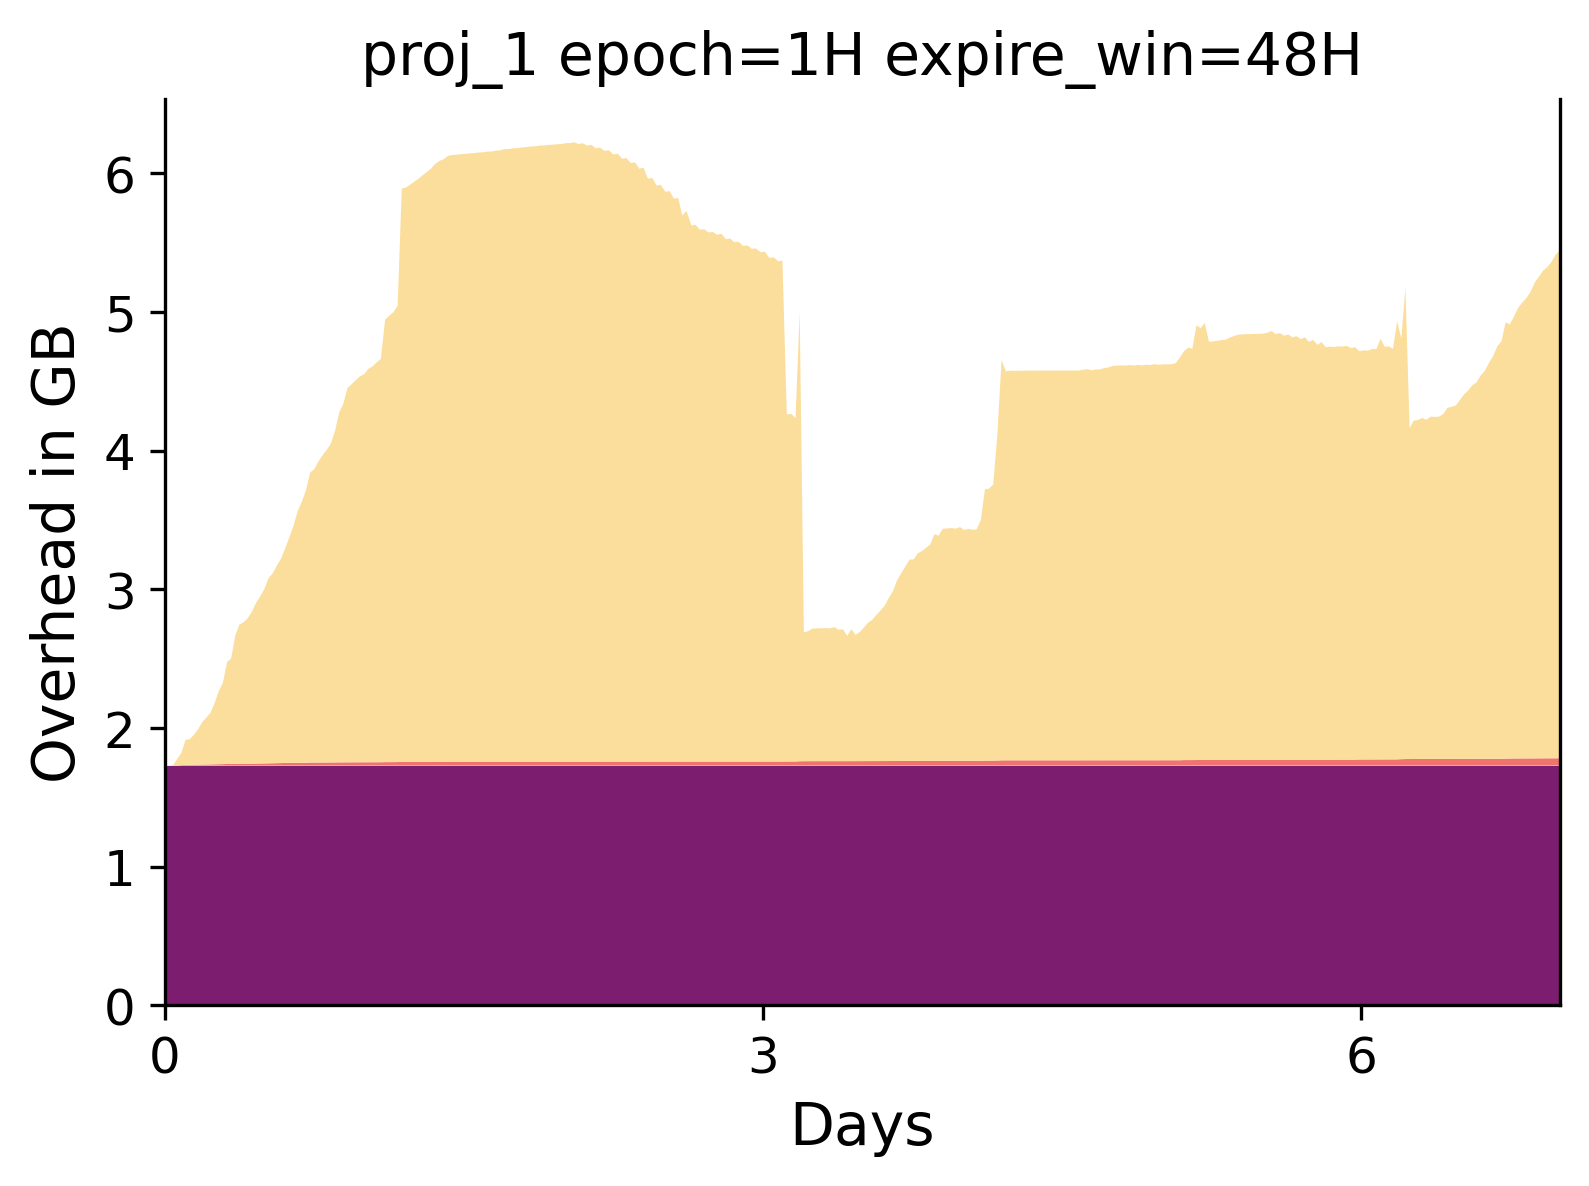

logic_disk_usage_GB:  880
max_version_FS:  884.496346448
written GB:  9.635569664
read GB:  739.93766912
old versions GB:  4.467269632
TL Metadata GB:  1.71875
Versioning Metadata GB:  0.053394032
filesystem size GB:  880


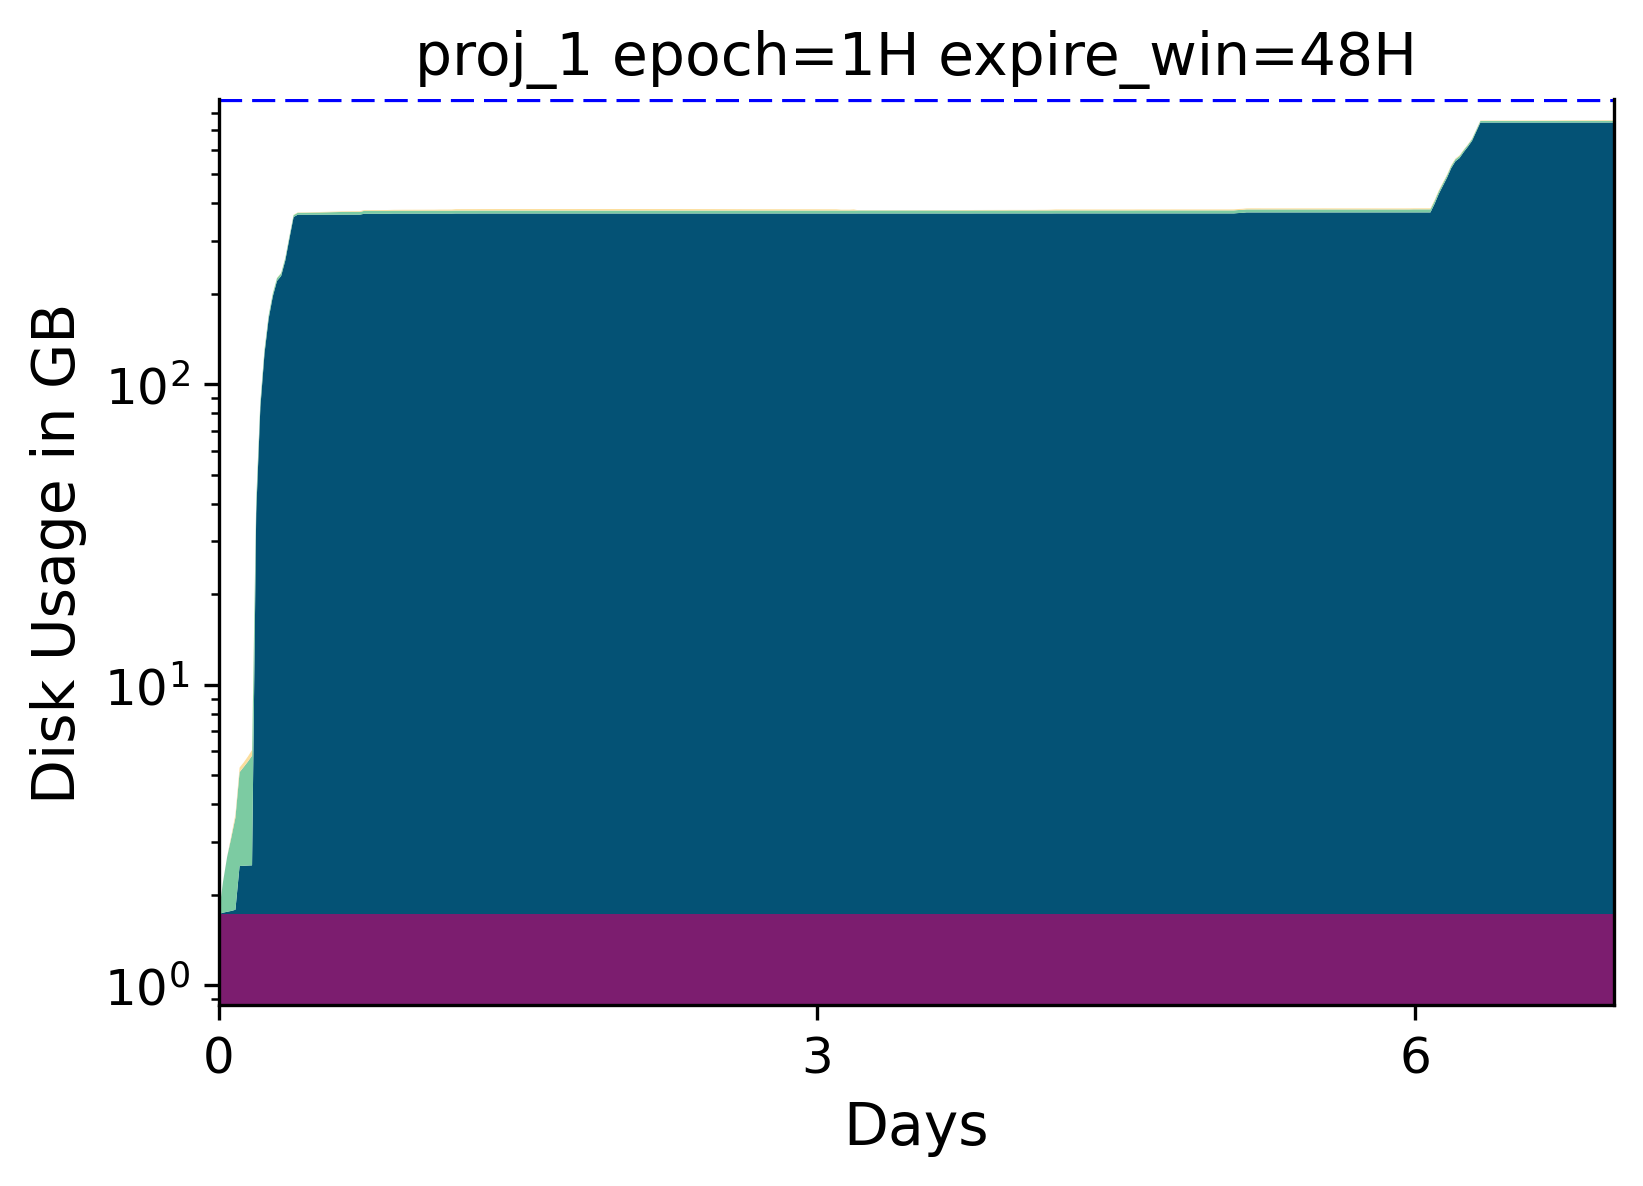

Invalid plot_FS_size
logic_disk_usage_GB:  880
max_version_FS:  887.74724892
written GB:  166.44620288
read GB:  439.050063872
old versions GB:  7.394029568
TL Metadata GB:  1.71875
Versioning Metadata GB:  0.35334448
filesystem size GB:  880


<Figure size 1800x1200 with 0 Axes>

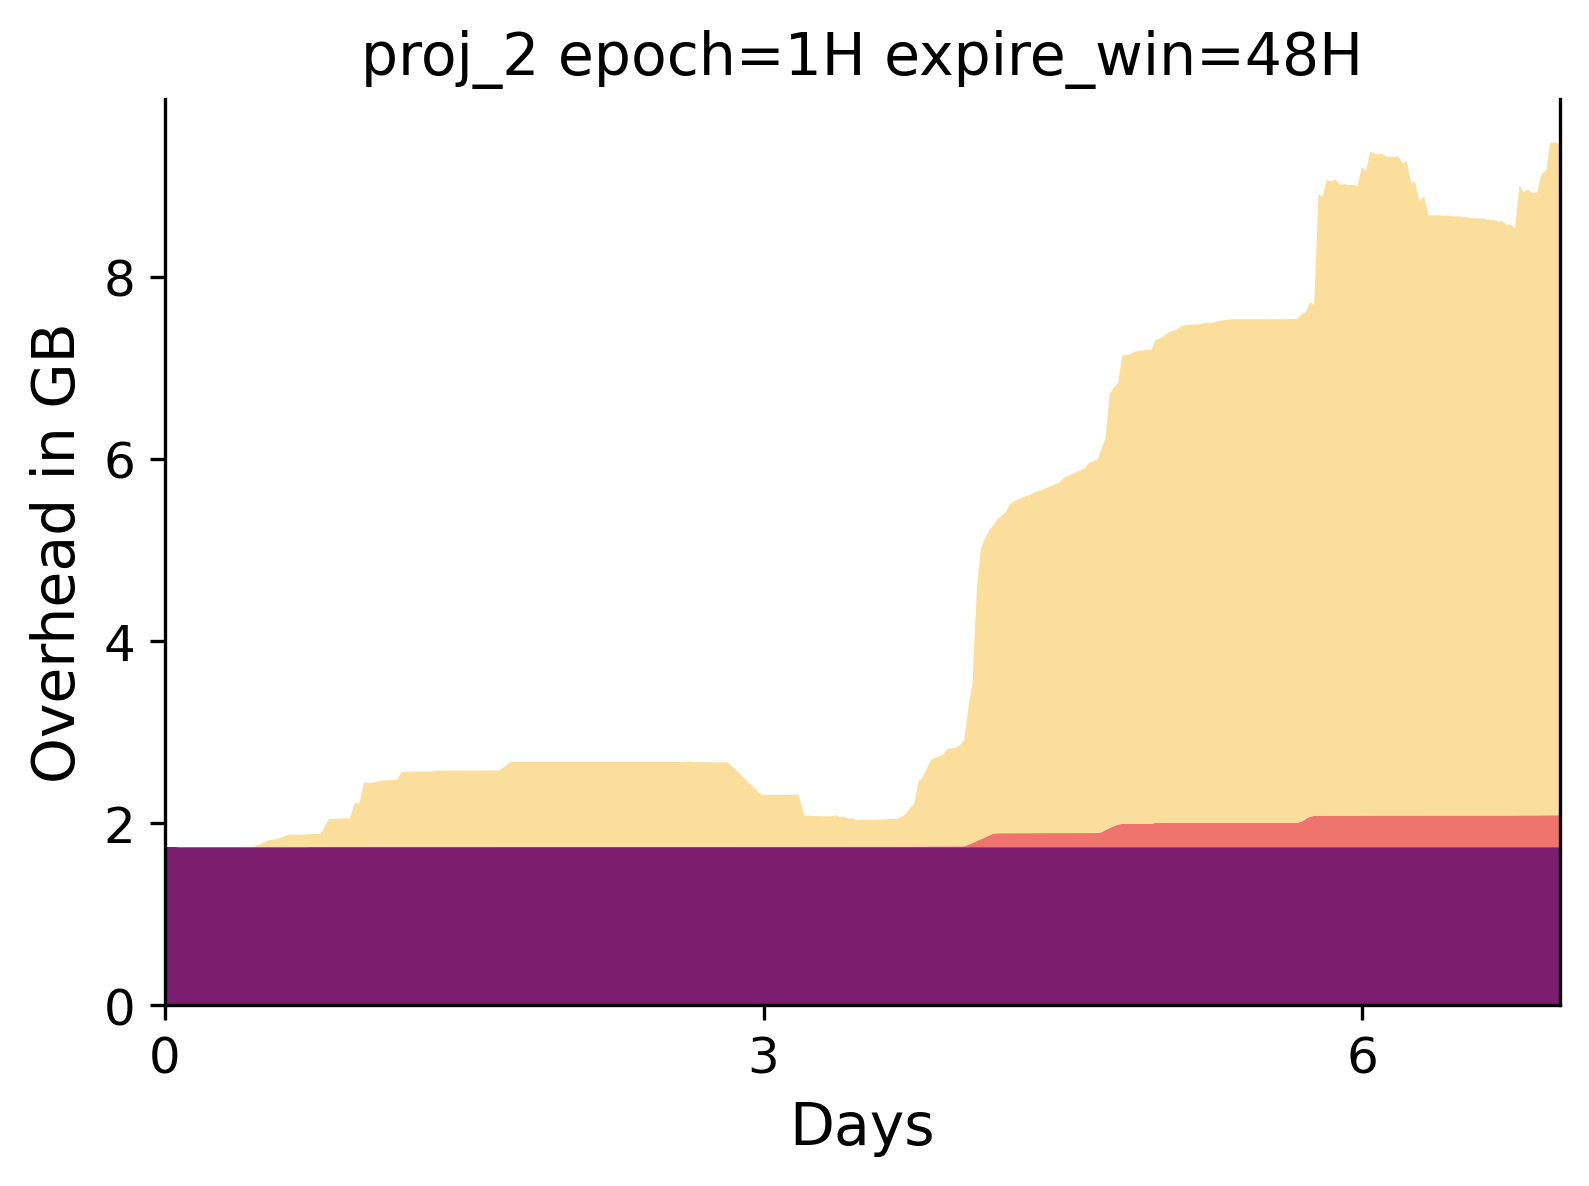

logic_disk_usage_GB:  880
max_version_FS:  887.74724892
written GB:  166.44620288
read GB:  439.050063872
old versions GB:  7.394029568
TL Metadata GB:  1.71875
Versioning Metadata GB:  0.35334448
filesystem size GB:  880


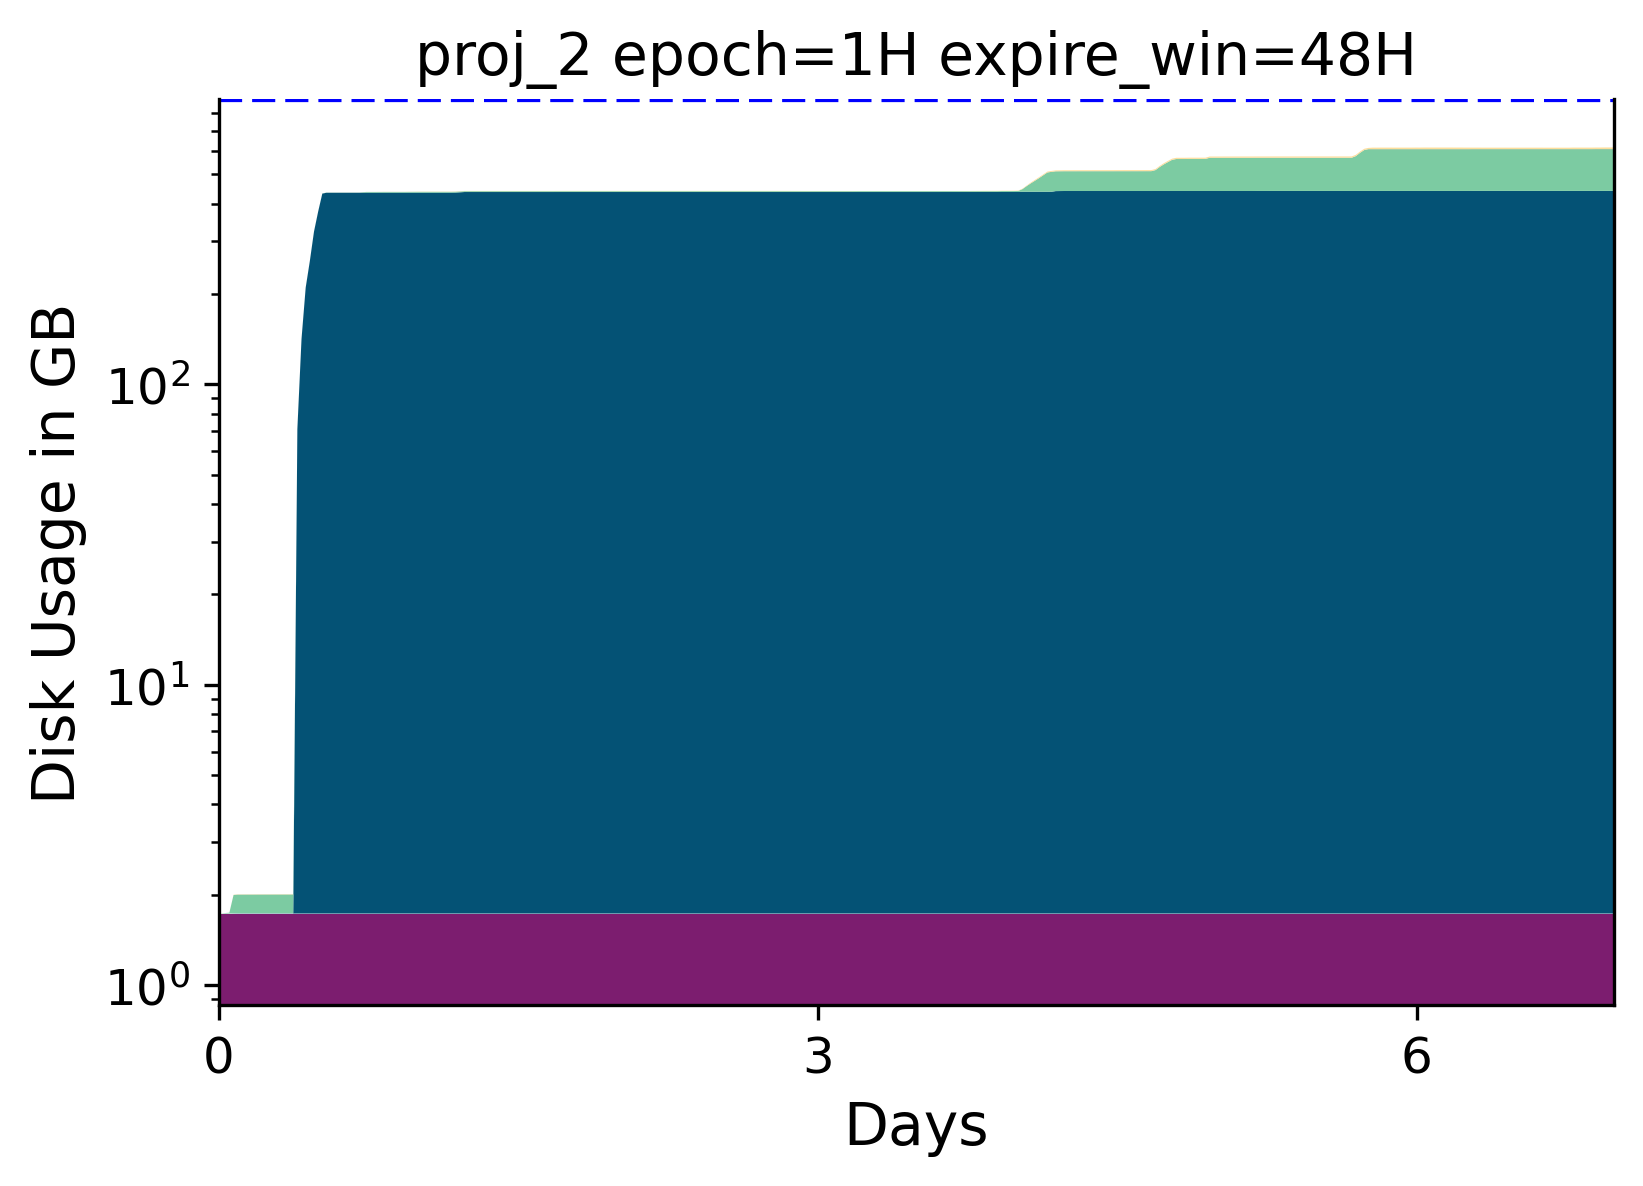

Invalid plot_FS_size
logic_disk_usage_GB:  28
max_version_FS:  28.333532472
written GB:  0.116248576
read GB:  0.160751616
old versions GB:  0.332406784
TL Metadata GB:  0.0546875
Versioning Metadata GB:  0.001125688
filesystem size GB:  28


<Figure size 1800x1200 with 0 Axes>

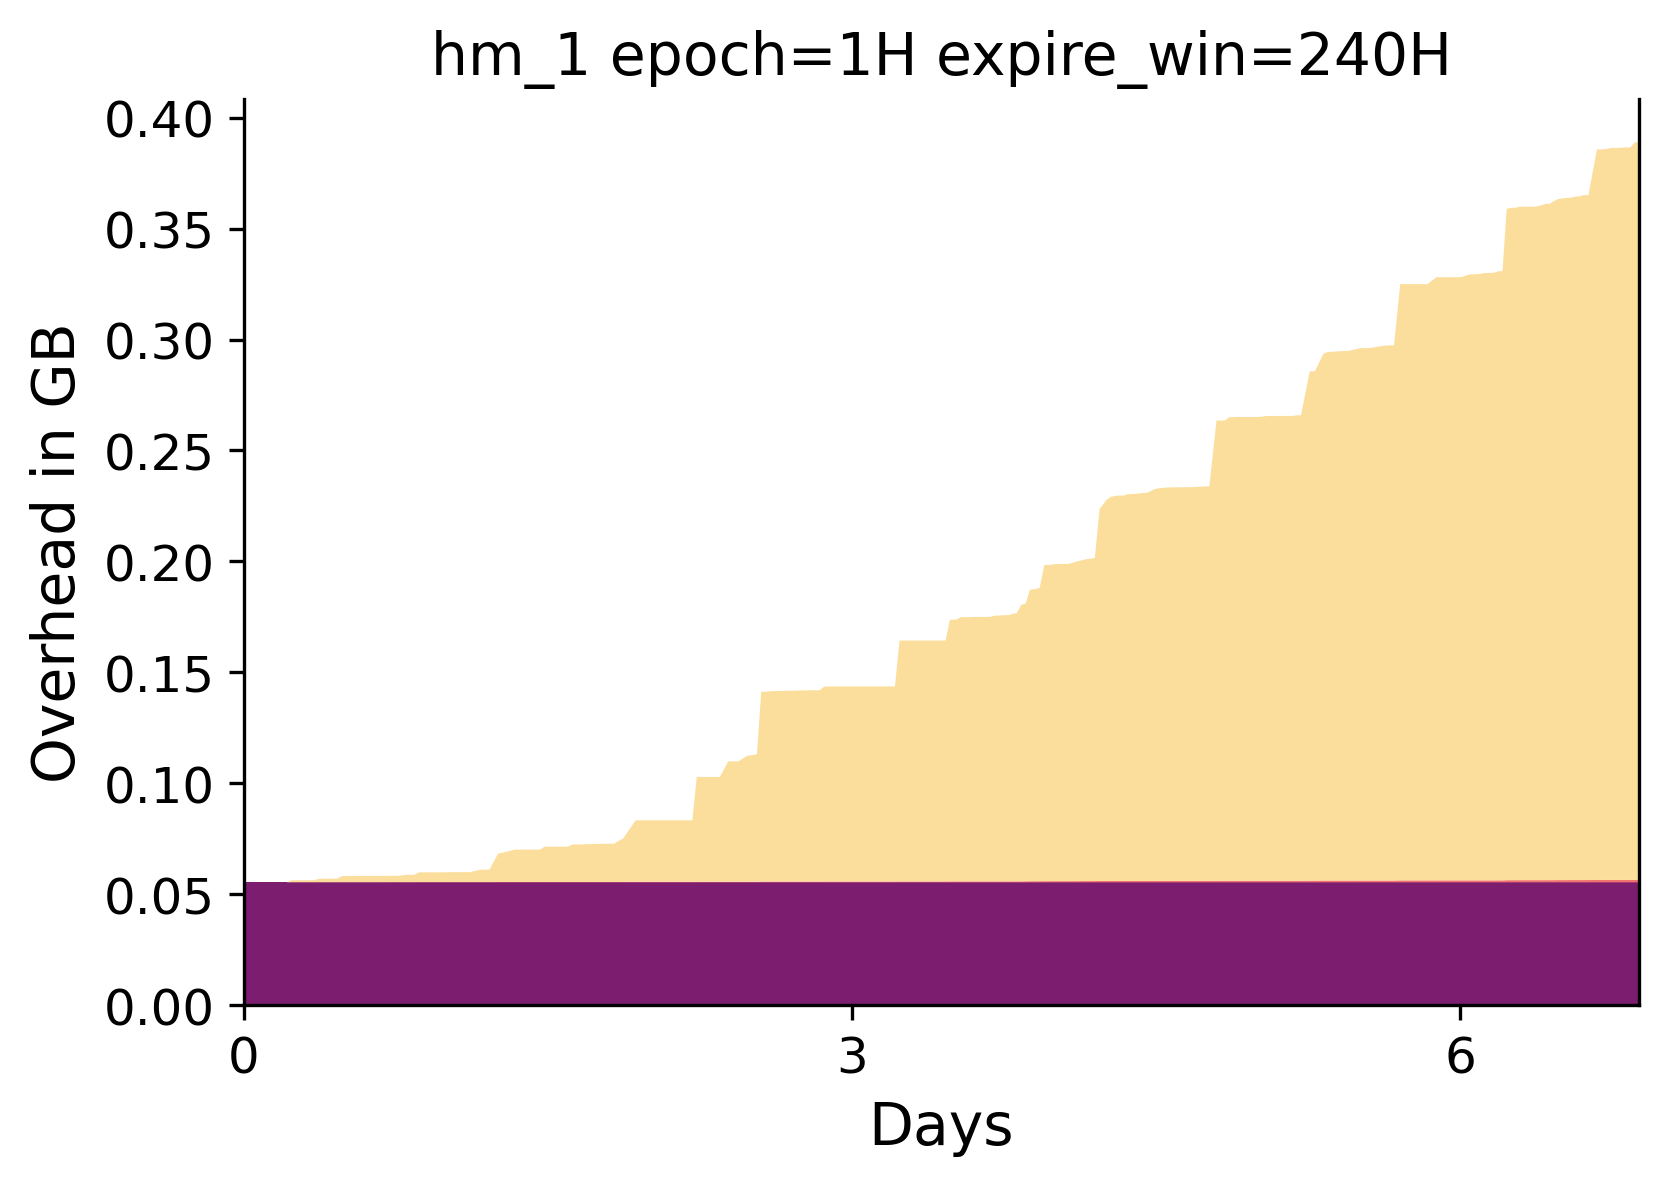

logic_disk_usage_GB:  28
max_version_FS:  28.333532472
written GB:  0.116248576
read GB:  0.160751616
old versions GB:  0.332406784
TL Metadata GB:  0.0546875
Versioning Metadata GB:  0.001125688
filesystem size GB:  28


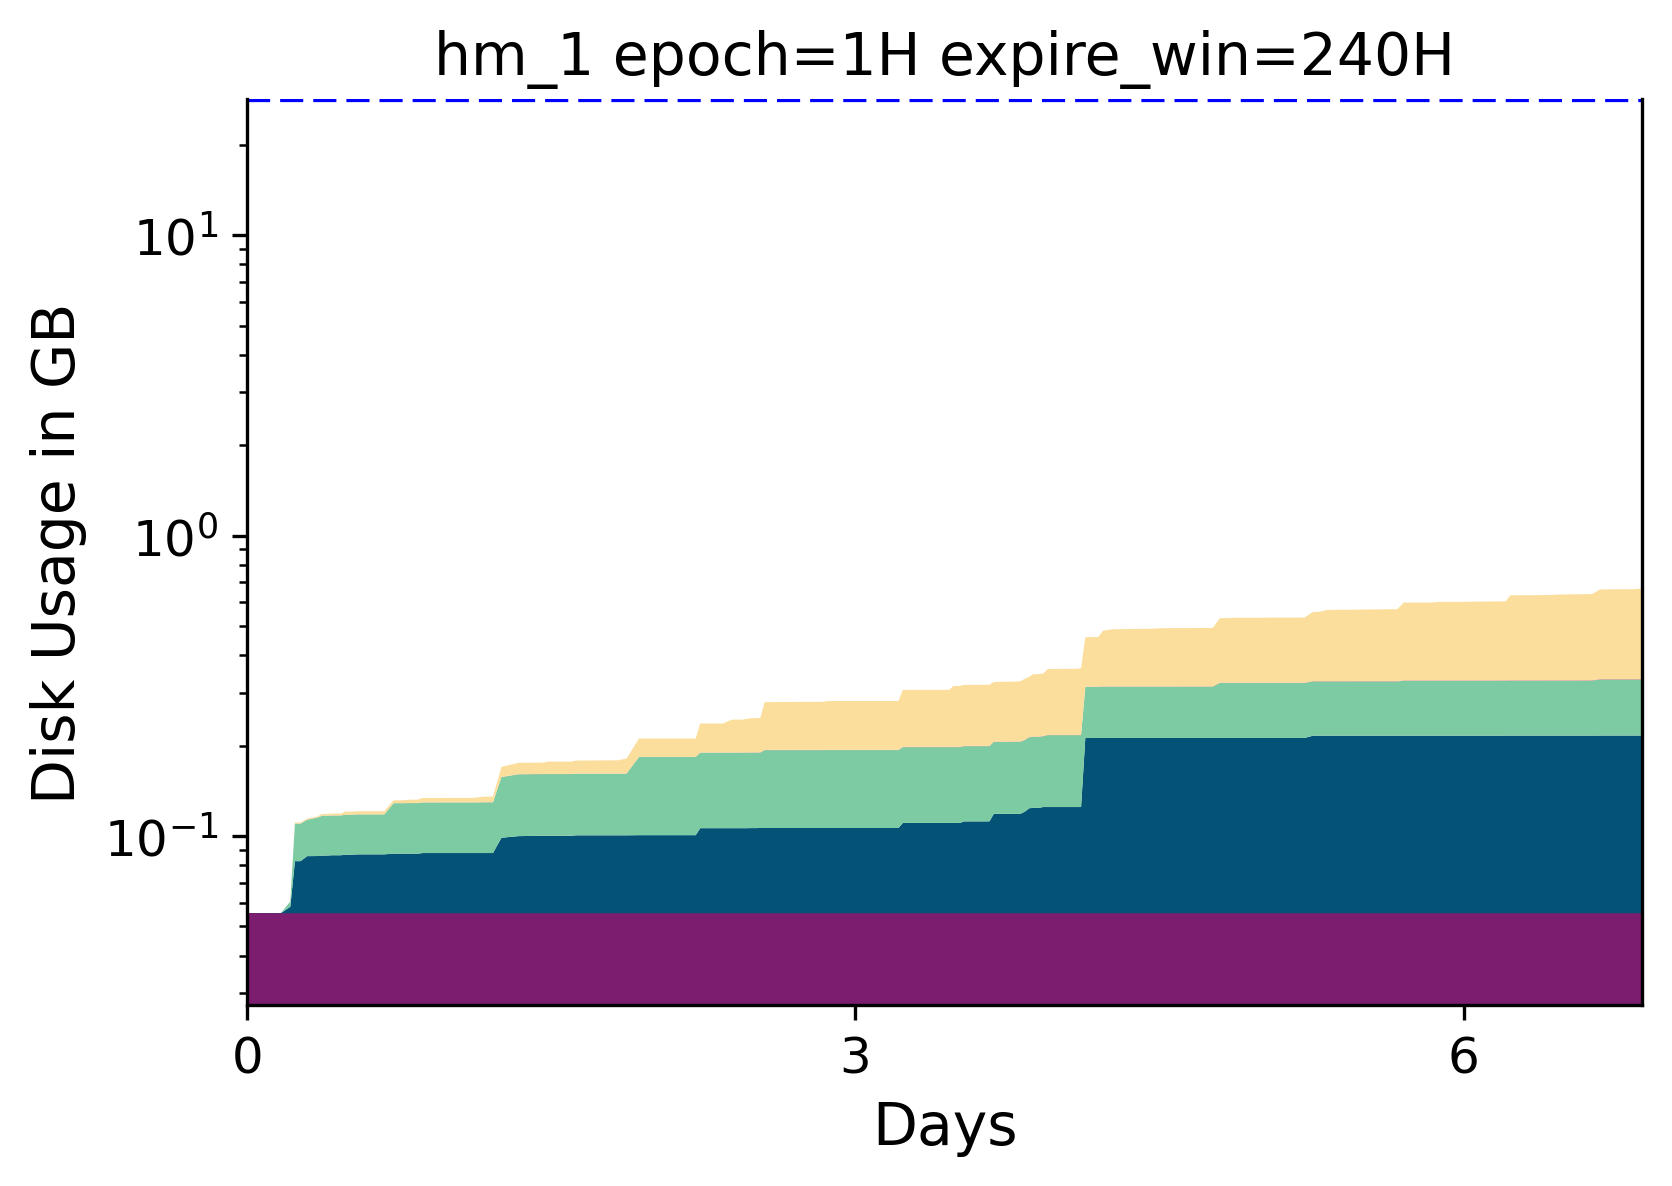

Invalid plot_FS_size
logic_disk_usage_GB:  880
max_version_FS:  893.602007664
written GB:  9.635569664
read GB:  739.93766912
old versions GB:  13.548613632
TL Metadata GB:  1.71875
Versioning Metadata GB:  0.053394032
filesystem size GB:  880


<Figure size 1800x1200 with 0 Axes>

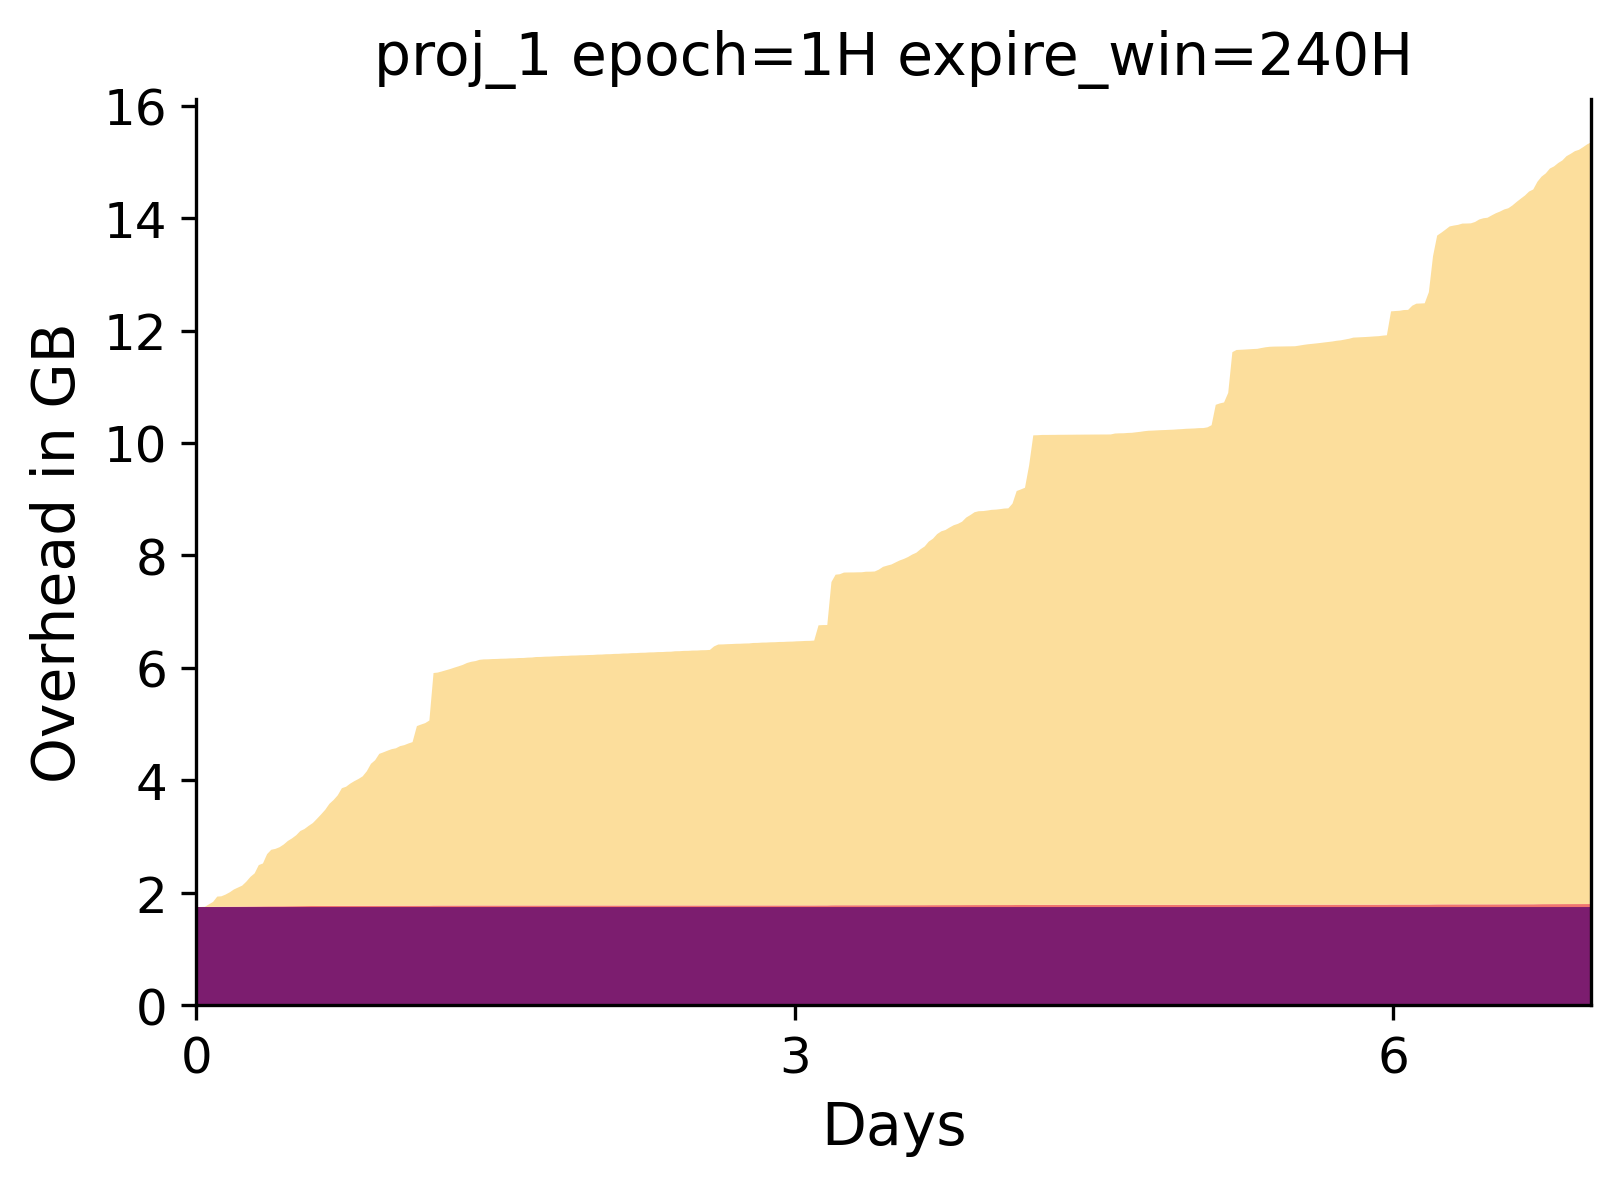

logic_disk_usage_GB:  880
max_version_FS:  893.602007664
written GB:  9.635569664
read GB:  739.93766912
old versions GB:  13.548613632
TL Metadata GB:  1.71875
Versioning Metadata GB:  0.053394032
filesystem size GB:  880


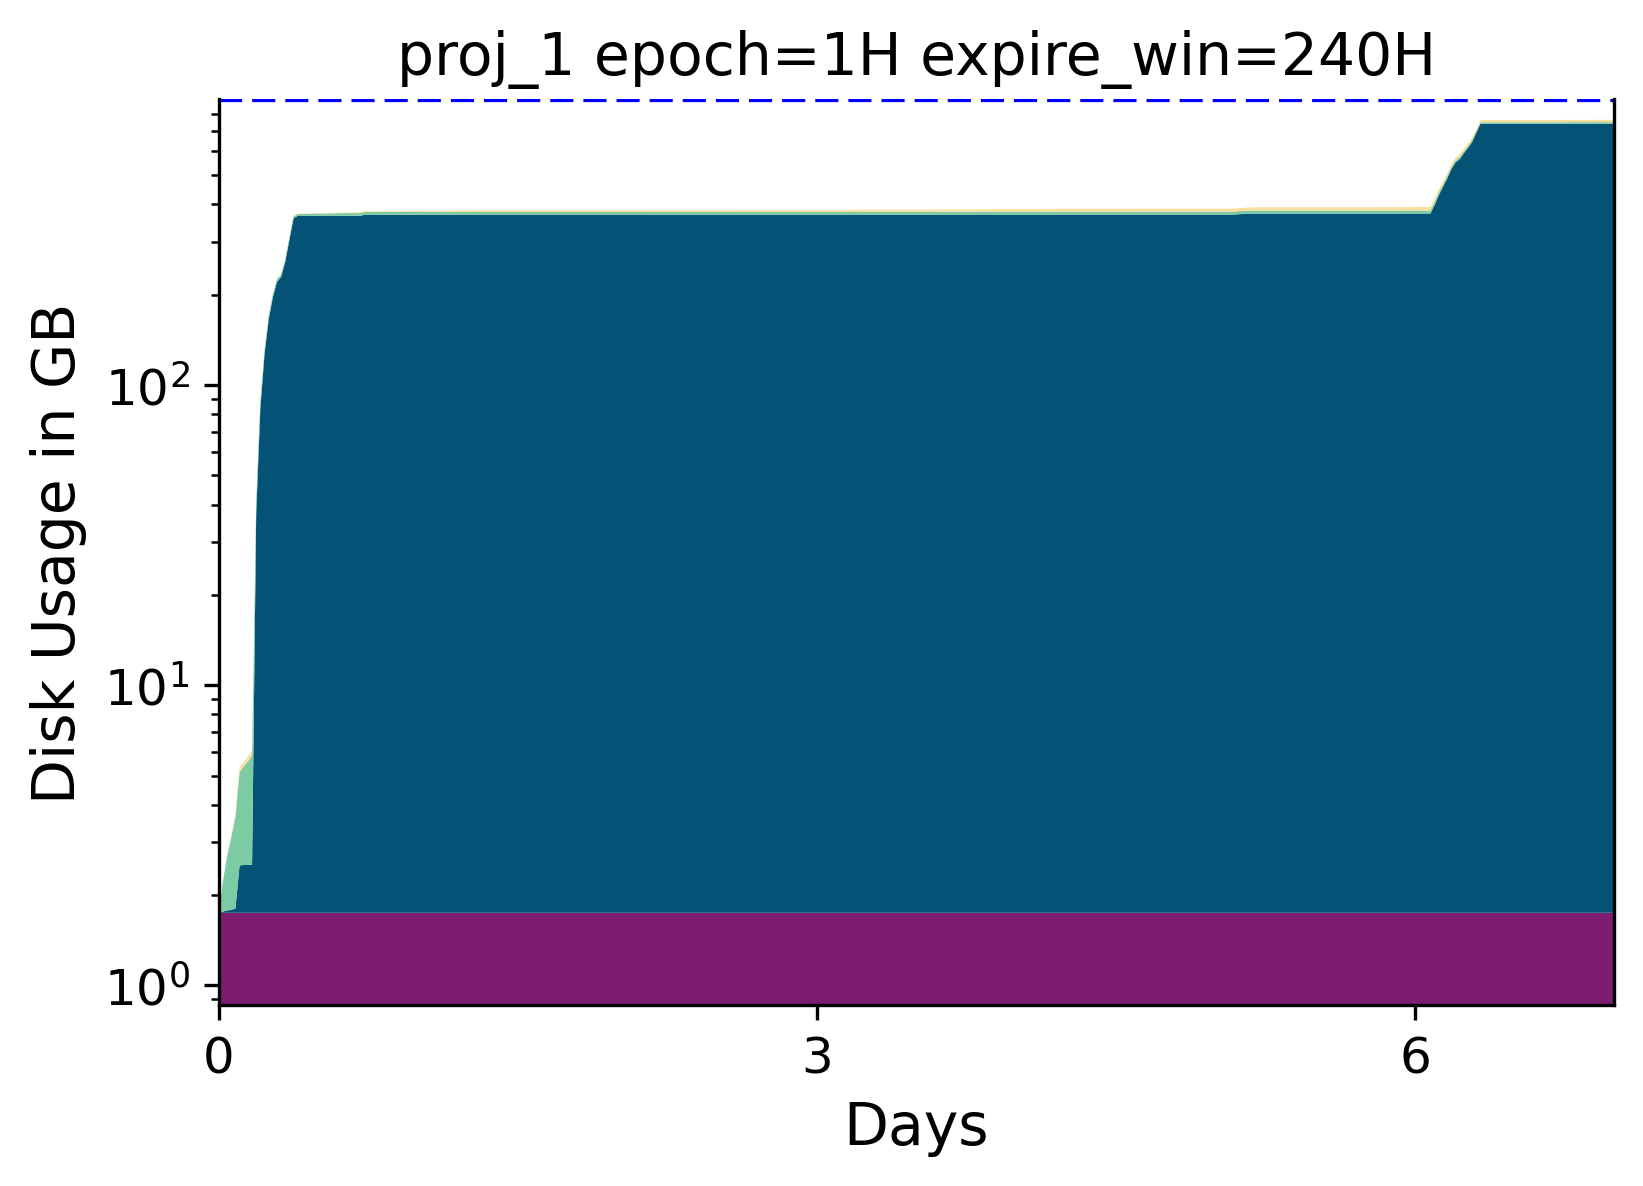

Invalid plot_FS_size
logic_disk_usage_GB:  18
max_version_FS:  30.94533244
written GB:  1.77364992
read GB:  1.855807488
old versions GB:  12.6430208
TL Metadata GB:  0.03515625
Versioning Metadata GB:  0.30231164
filesystem size GB:  18


<Figure size 1800x1200 with 0 Axes>

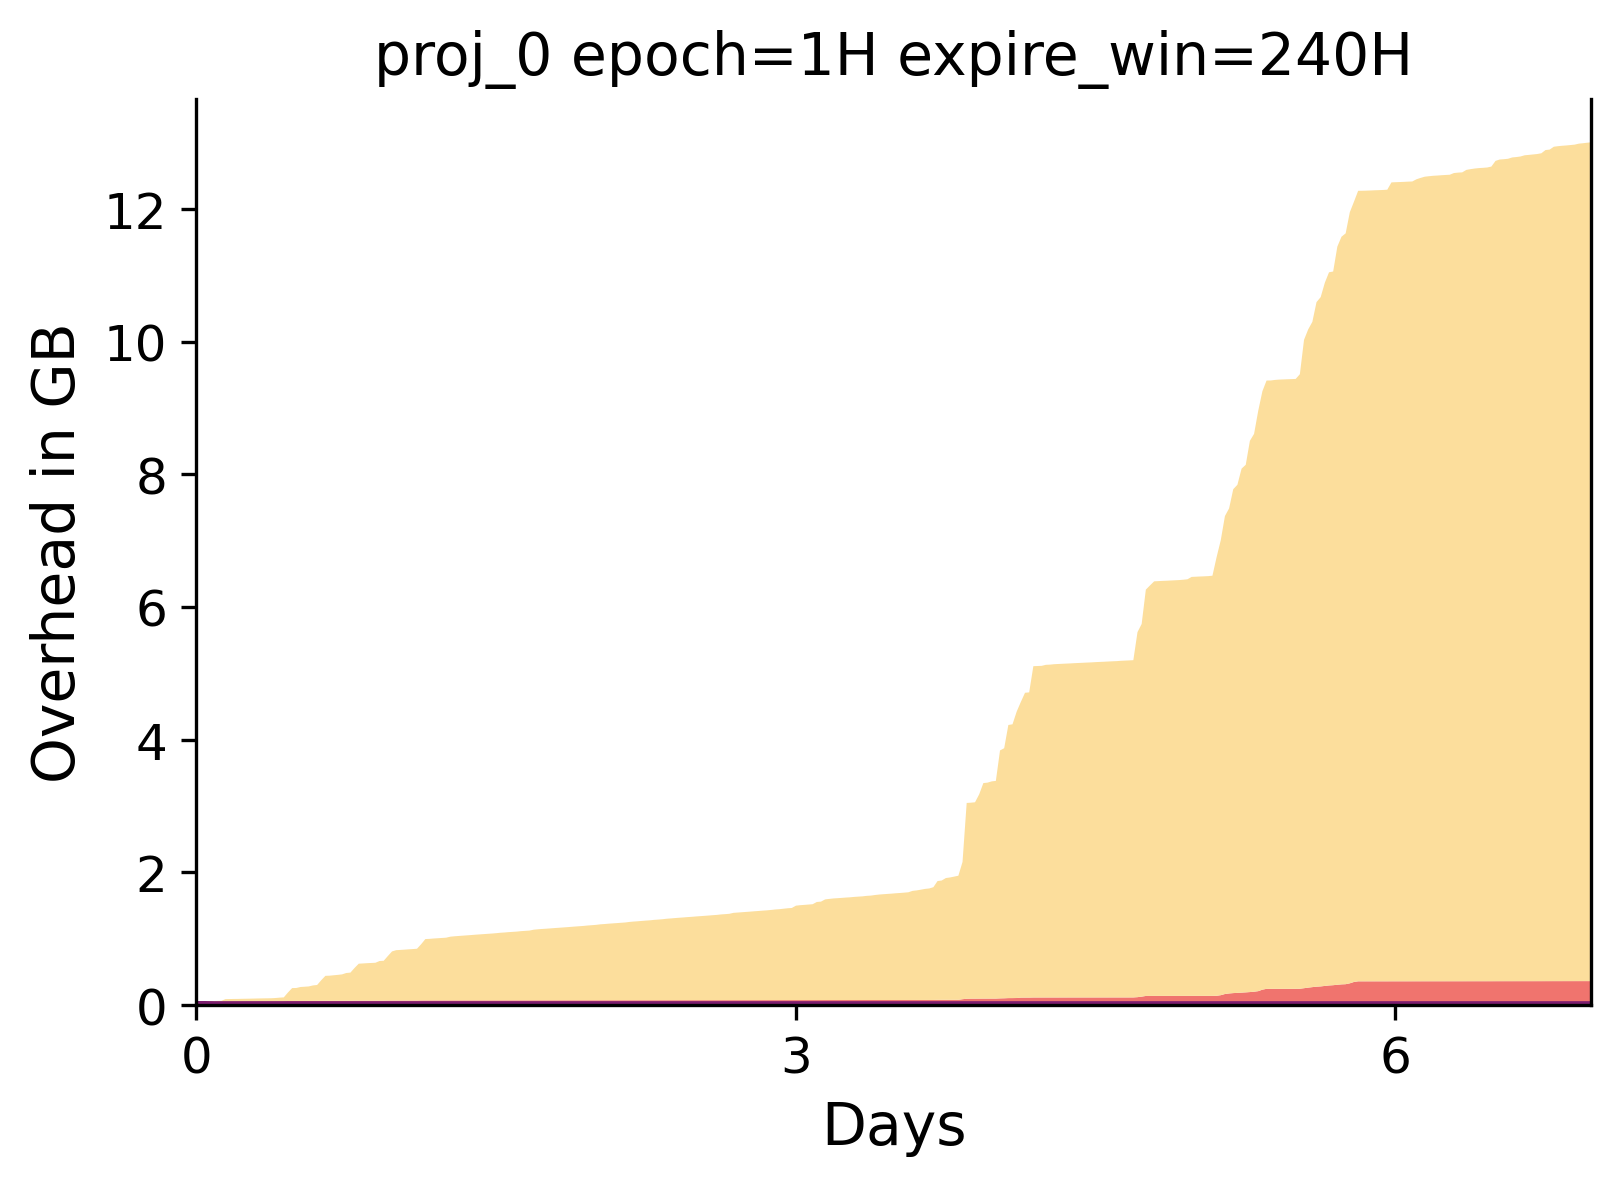

logic_disk_usage_GB:  18
max_version_FS:  30.94533244
written GB:  1.77364992
read GB:  1.855807488
old versions GB:  12.6430208
TL Metadata GB:  0.03515625
Versioning Metadata GB:  0.30231164
filesystem size GB:  18


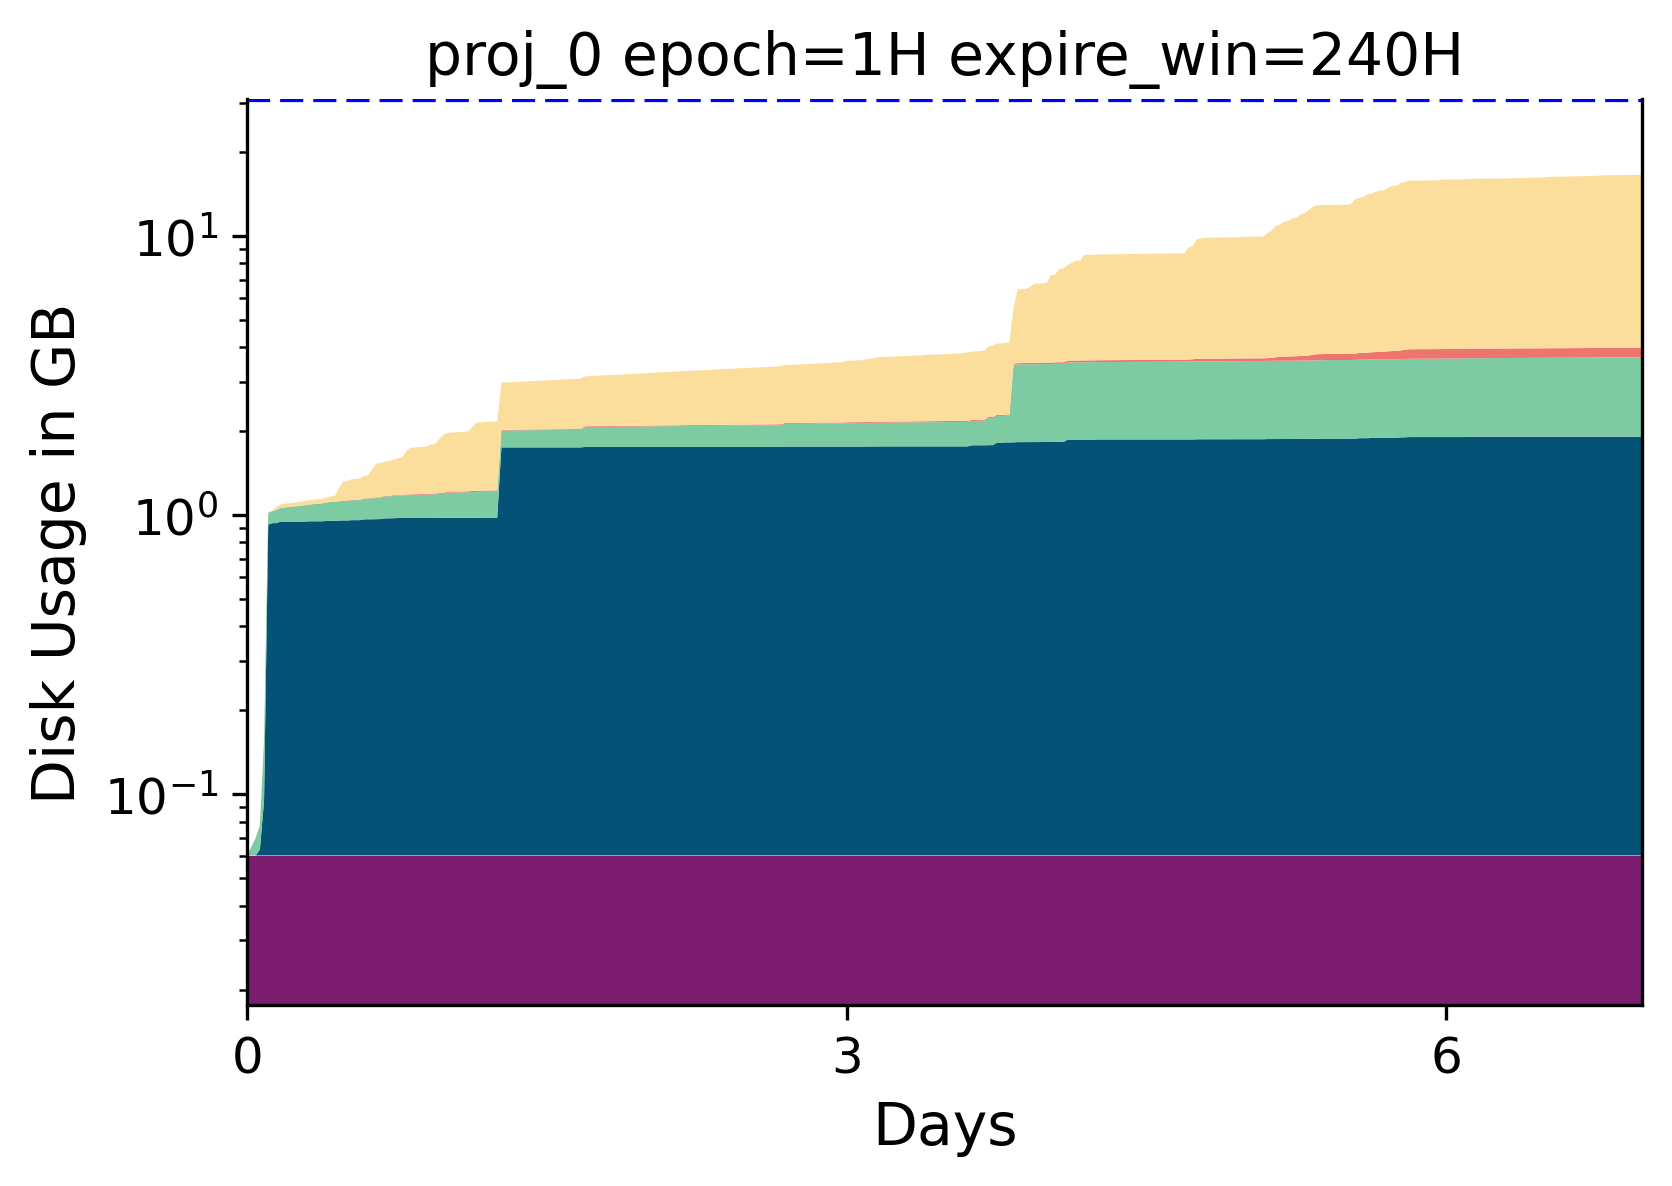

Invalid plot_FS_size
logic_disk_usage_GB:  72
max_version_FS:  79.510808256
written GB:  13.29129472
read GB:  3.98258176
old versions GB:  7.419486208
TL Metadata GB:  0.140625
Versioning Metadata GB:  0.092064888
filesystem size GB:  72


<Figure size 1800x1200 with 0 Axes>

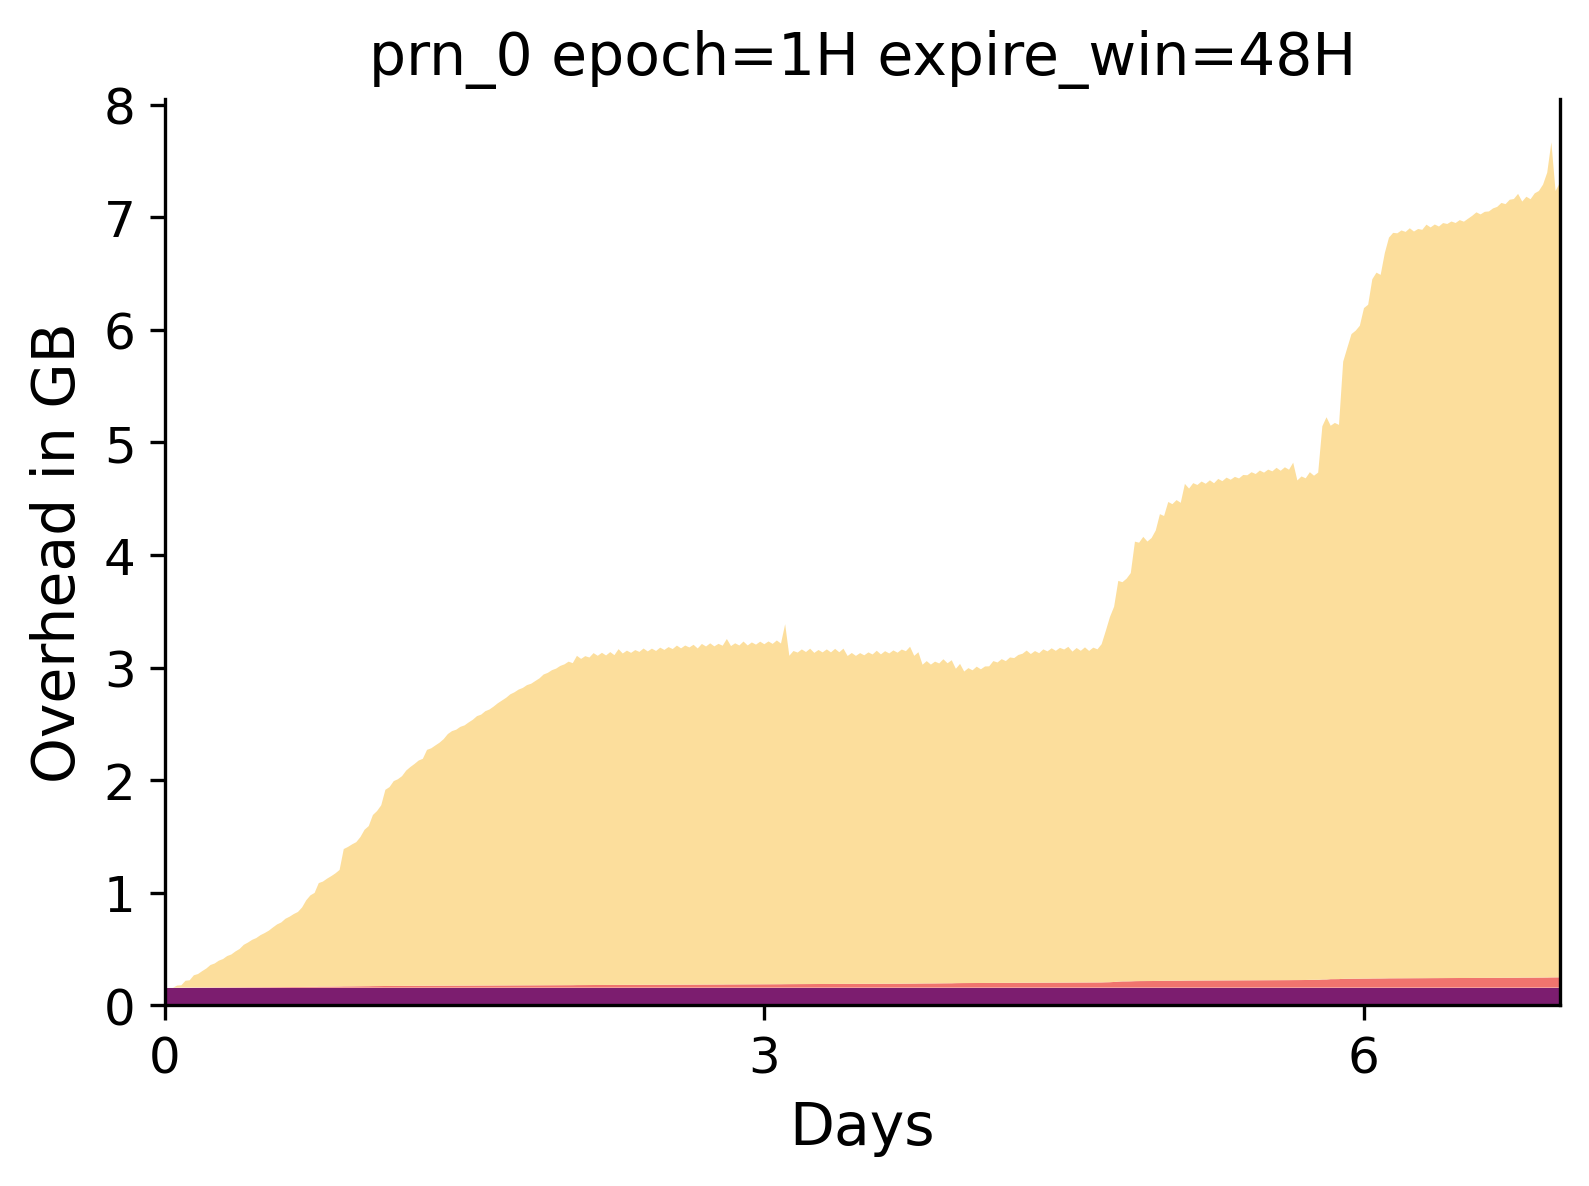

logic_disk_usage_GB:  72
max_version_FS:  79.510808256
written GB:  13.29129472
read GB:  3.98258176
old versions GB:  7.419486208
TL Metadata GB:  0.140625
Versioning Metadata GB:  0.092064888
filesystem size GB:  72


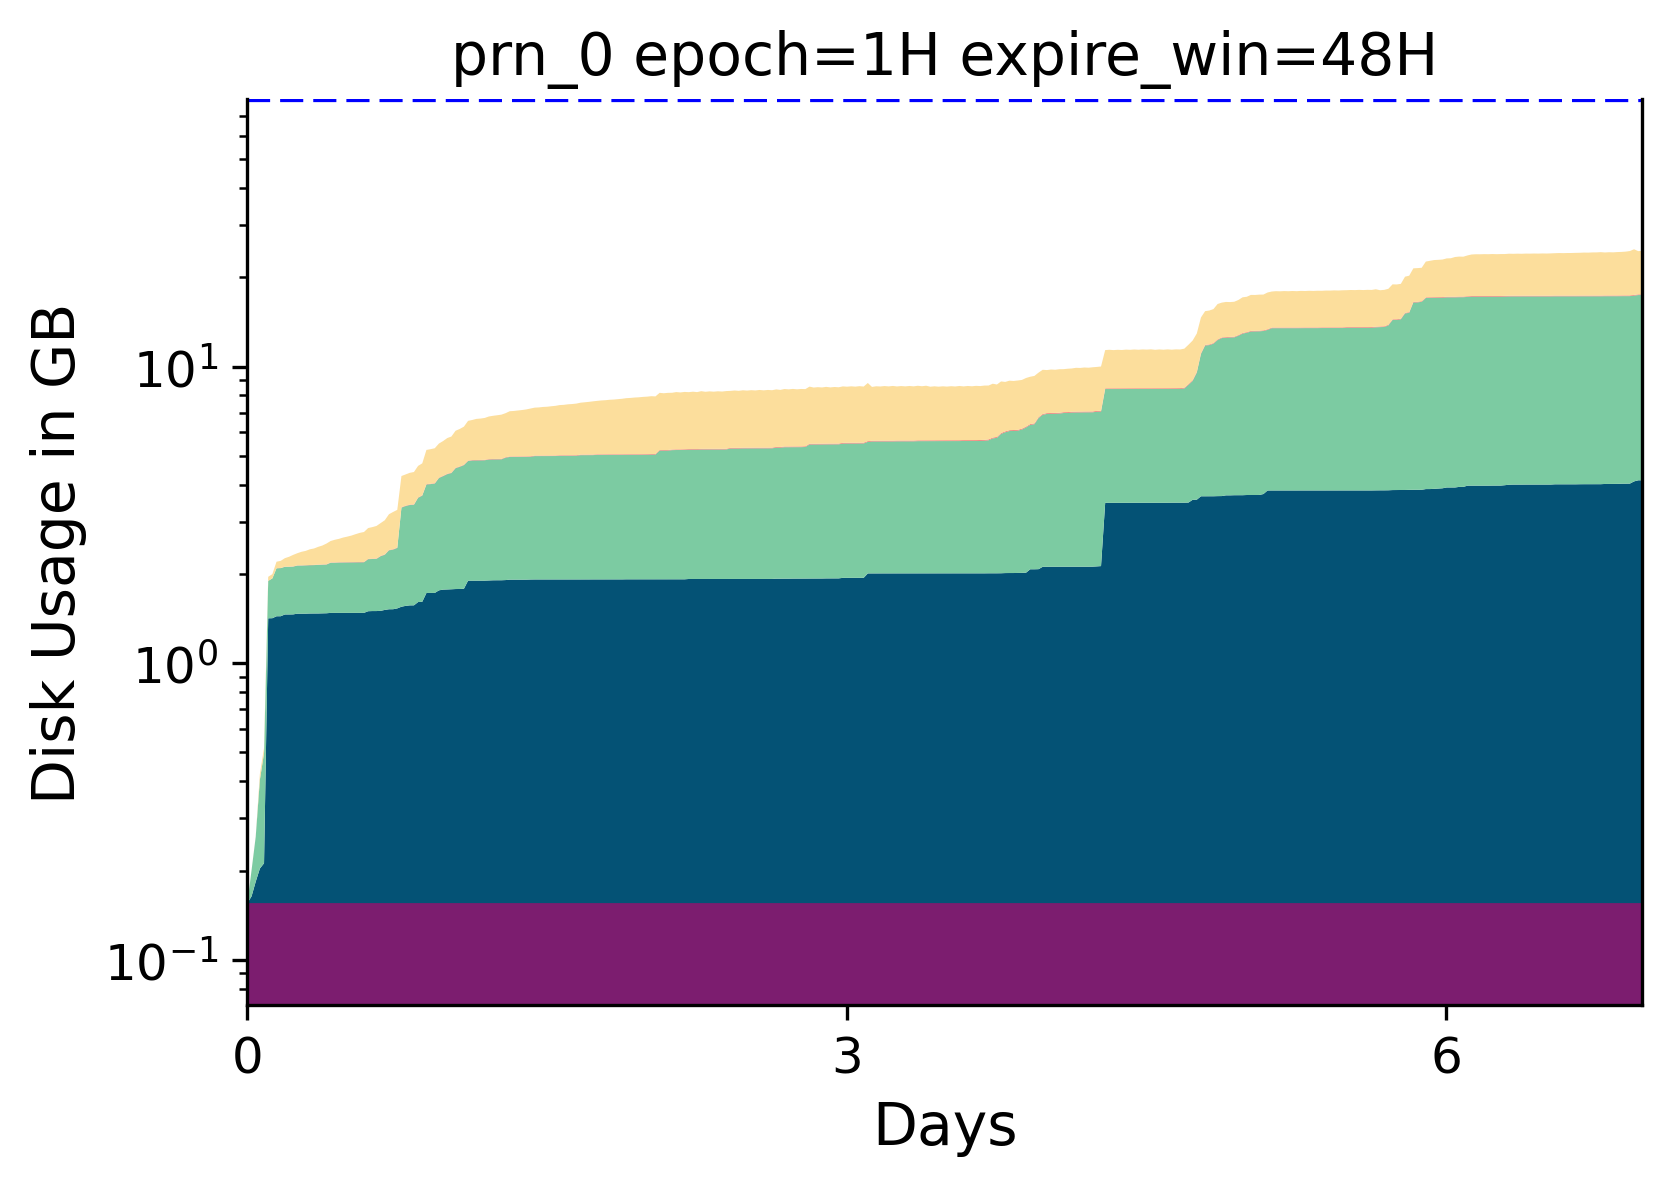

Invalid plot_FS_size
logic_disk_usage_GB:  880
max_version_FS:  890.944080864
written GB:  166.44620288
read GB:  439.050063872
old versions GB:  10.590736384
TL Metadata GB:  1.71875
Versioning Metadata GB:  0.35334448
filesystem size GB:  880


<Figure size 1800x1200 with 0 Axes>

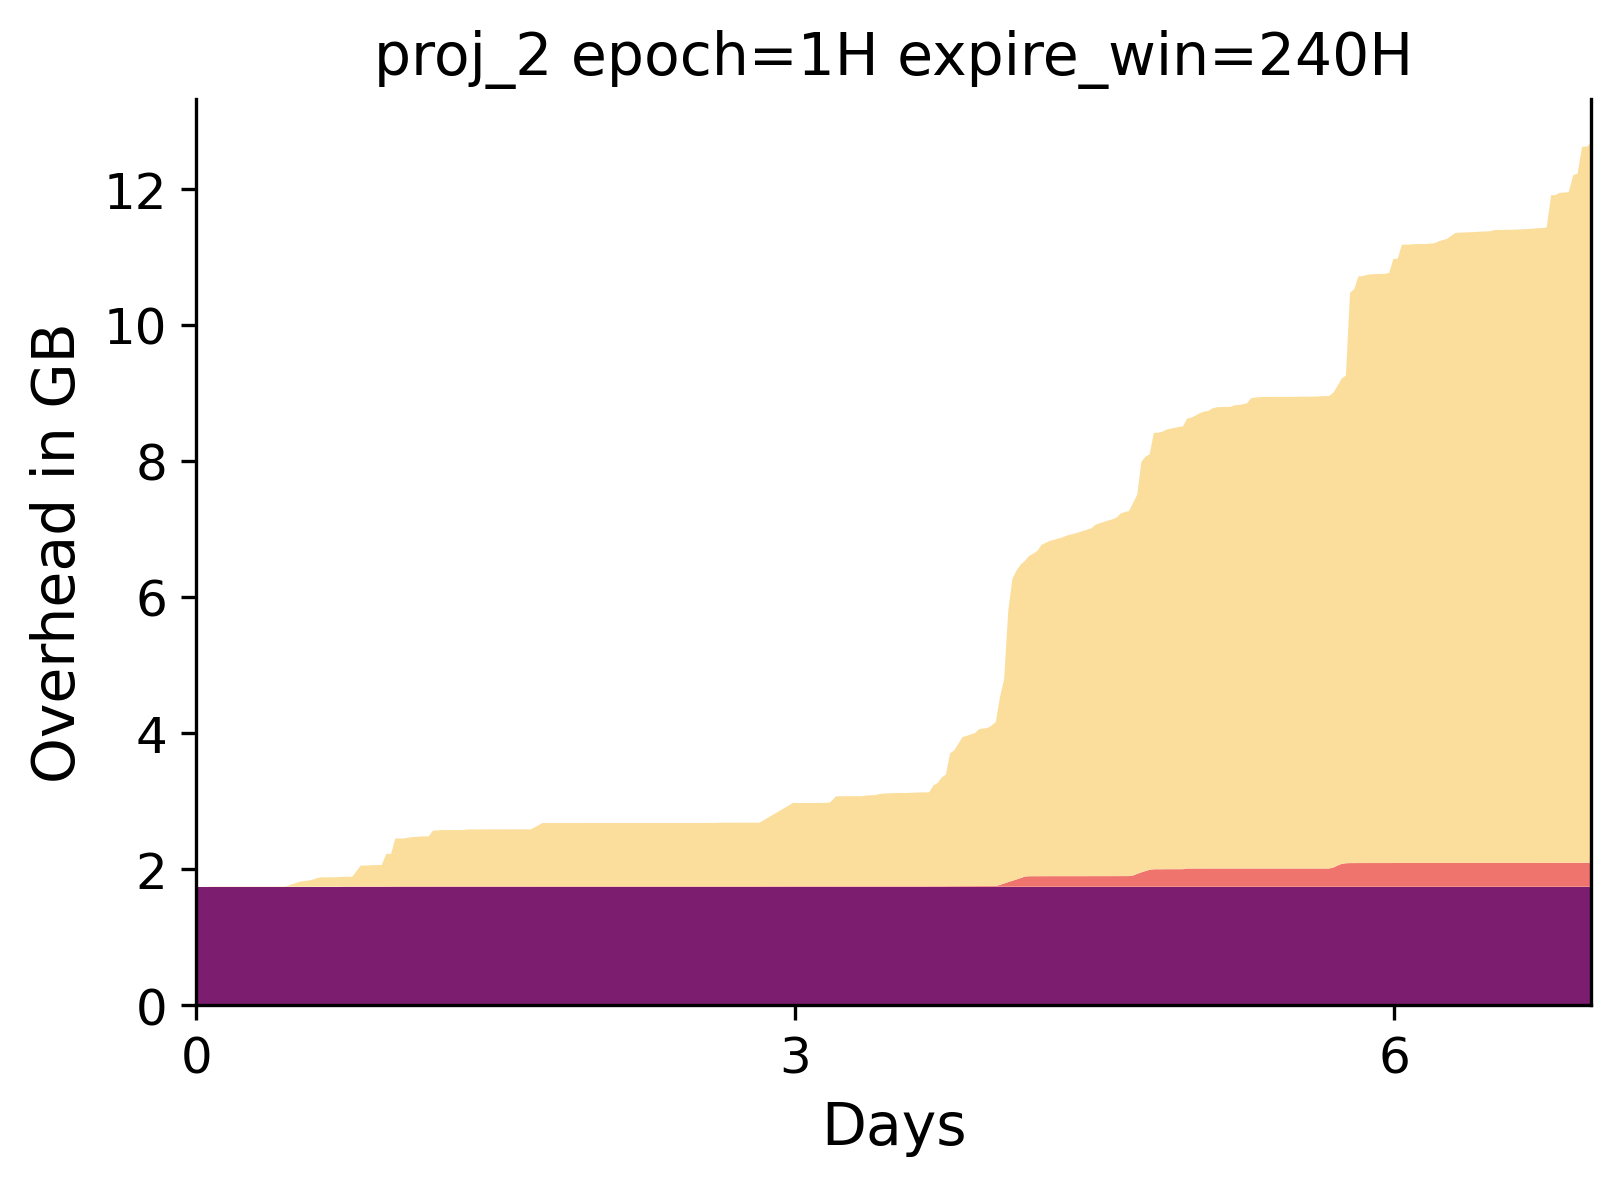

logic_disk_usage_GB:  880
max_version_FS:  890.944080864
written GB:  166.44620288
read GB:  439.050063872
old versions GB:  10.590736384
TL Metadata GB:  1.71875
Versioning Metadata GB:  0.35334448
filesystem size GB:  880


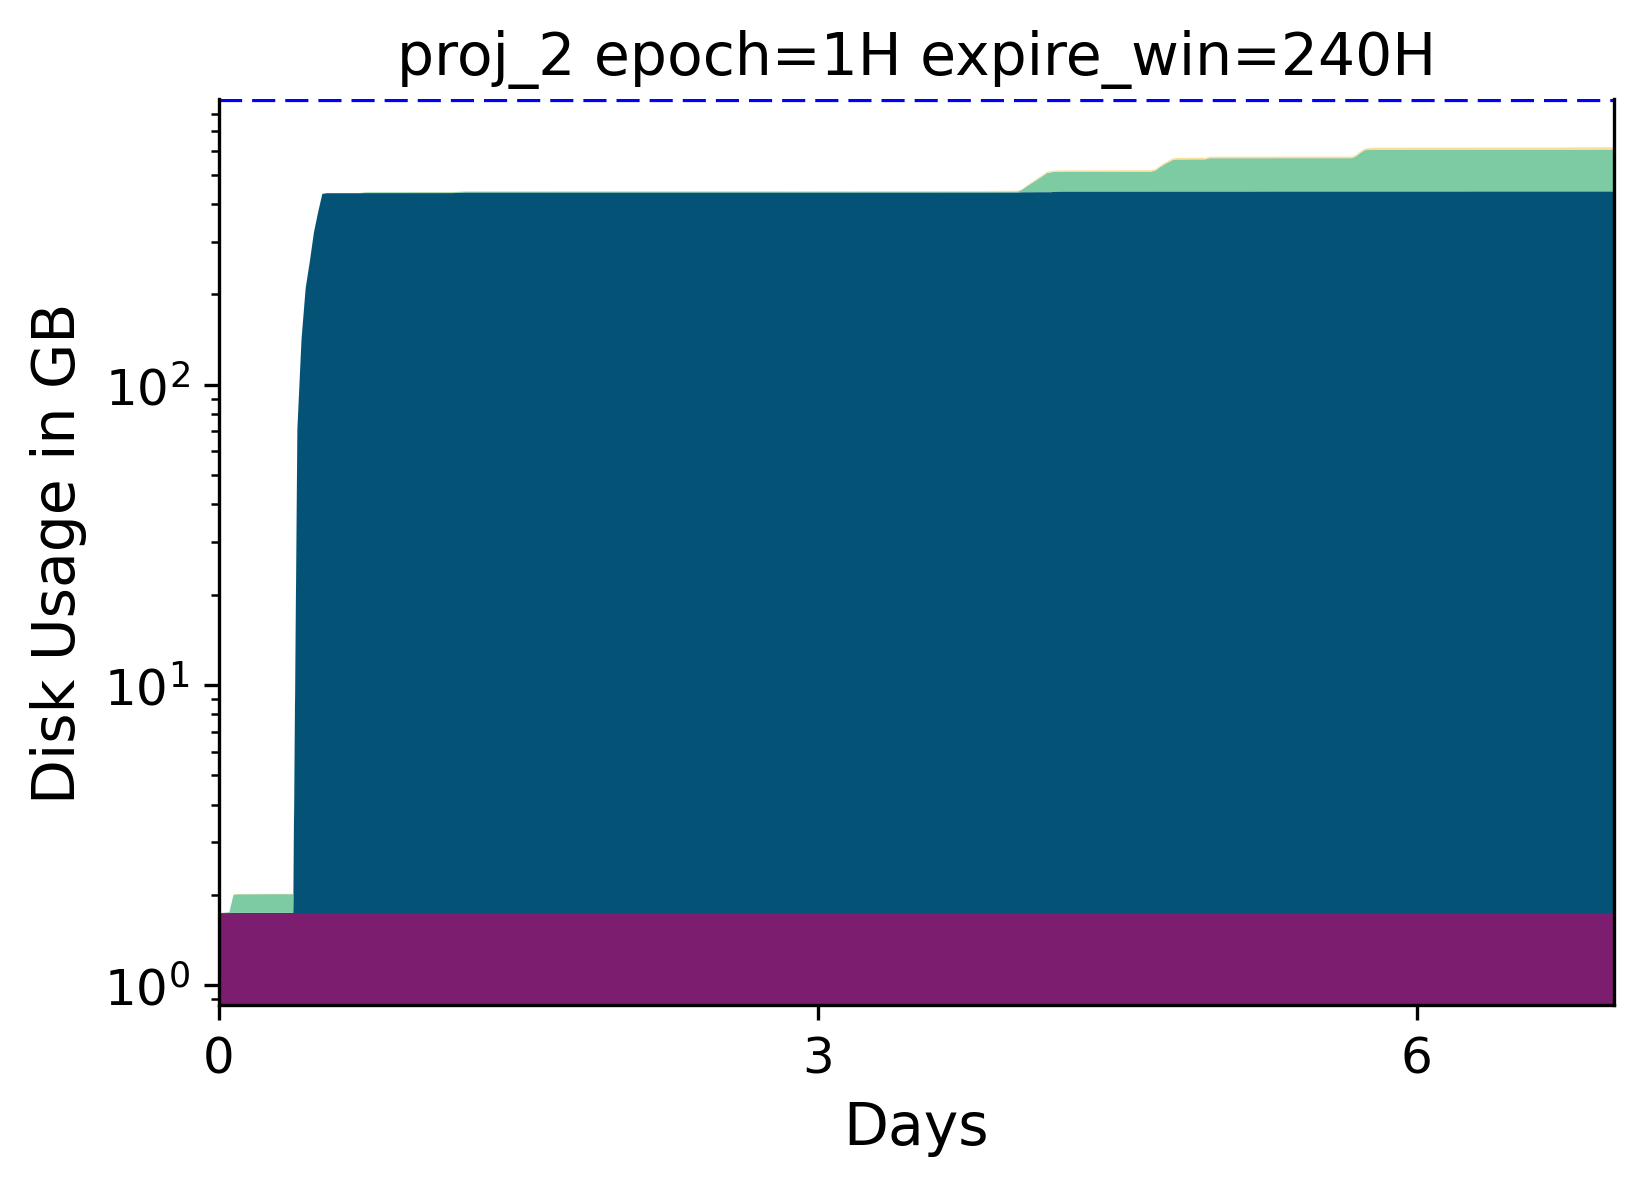

Invalid plot_FS_size
logic_disk_usage_GB:  28
max_version_FS:  28.121266456
written GB:  0.116248576
read GB:  0.160751616
old versions GB:  0.120270848
TL Metadata GB:  0.0546875
Versioning Metadata GB:  0.001125688
filesystem size GB:  28


<Figure size 1800x1200 with 0 Axes>

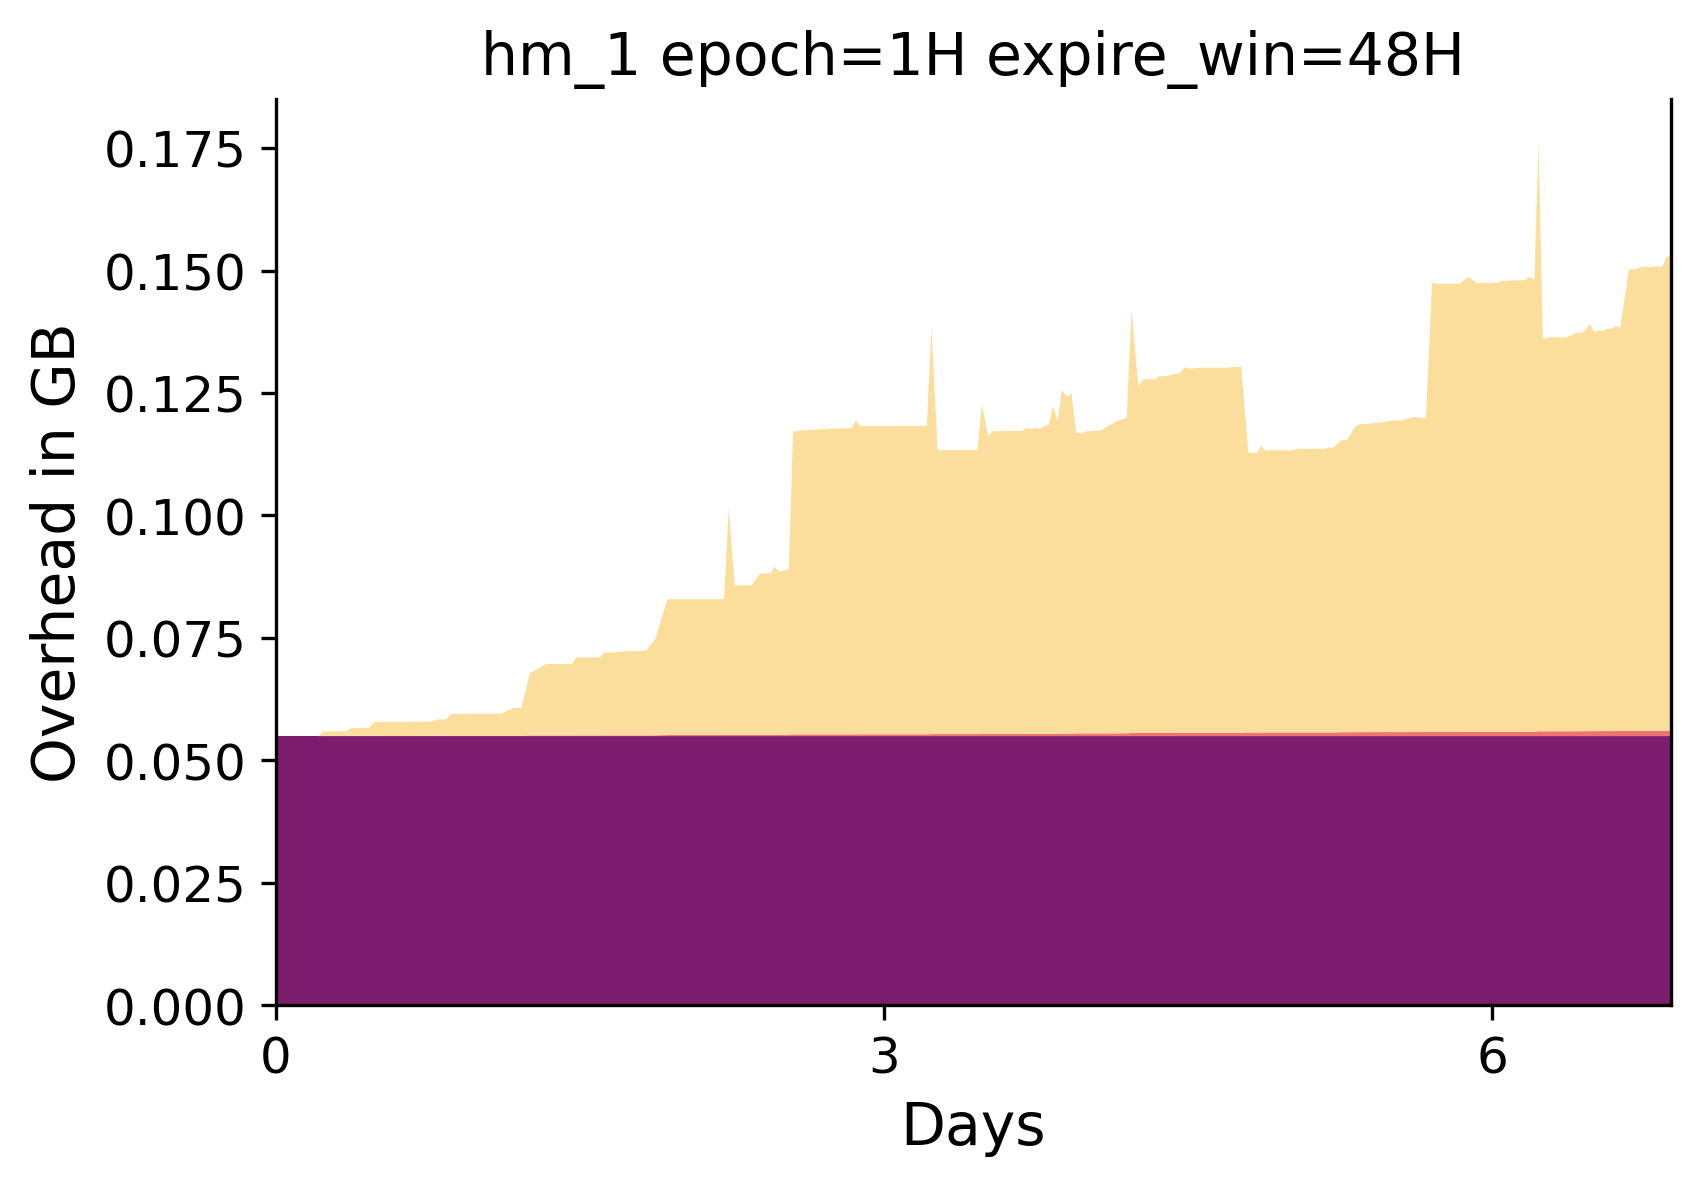

logic_disk_usage_GB:  28
max_version_FS:  28.121266456
written GB:  0.116248576
read GB:  0.160751616
old versions GB:  0.120270848
TL Metadata GB:  0.0546875
Versioning Metadata GB:  0.001125688
filesystem size GB:  28


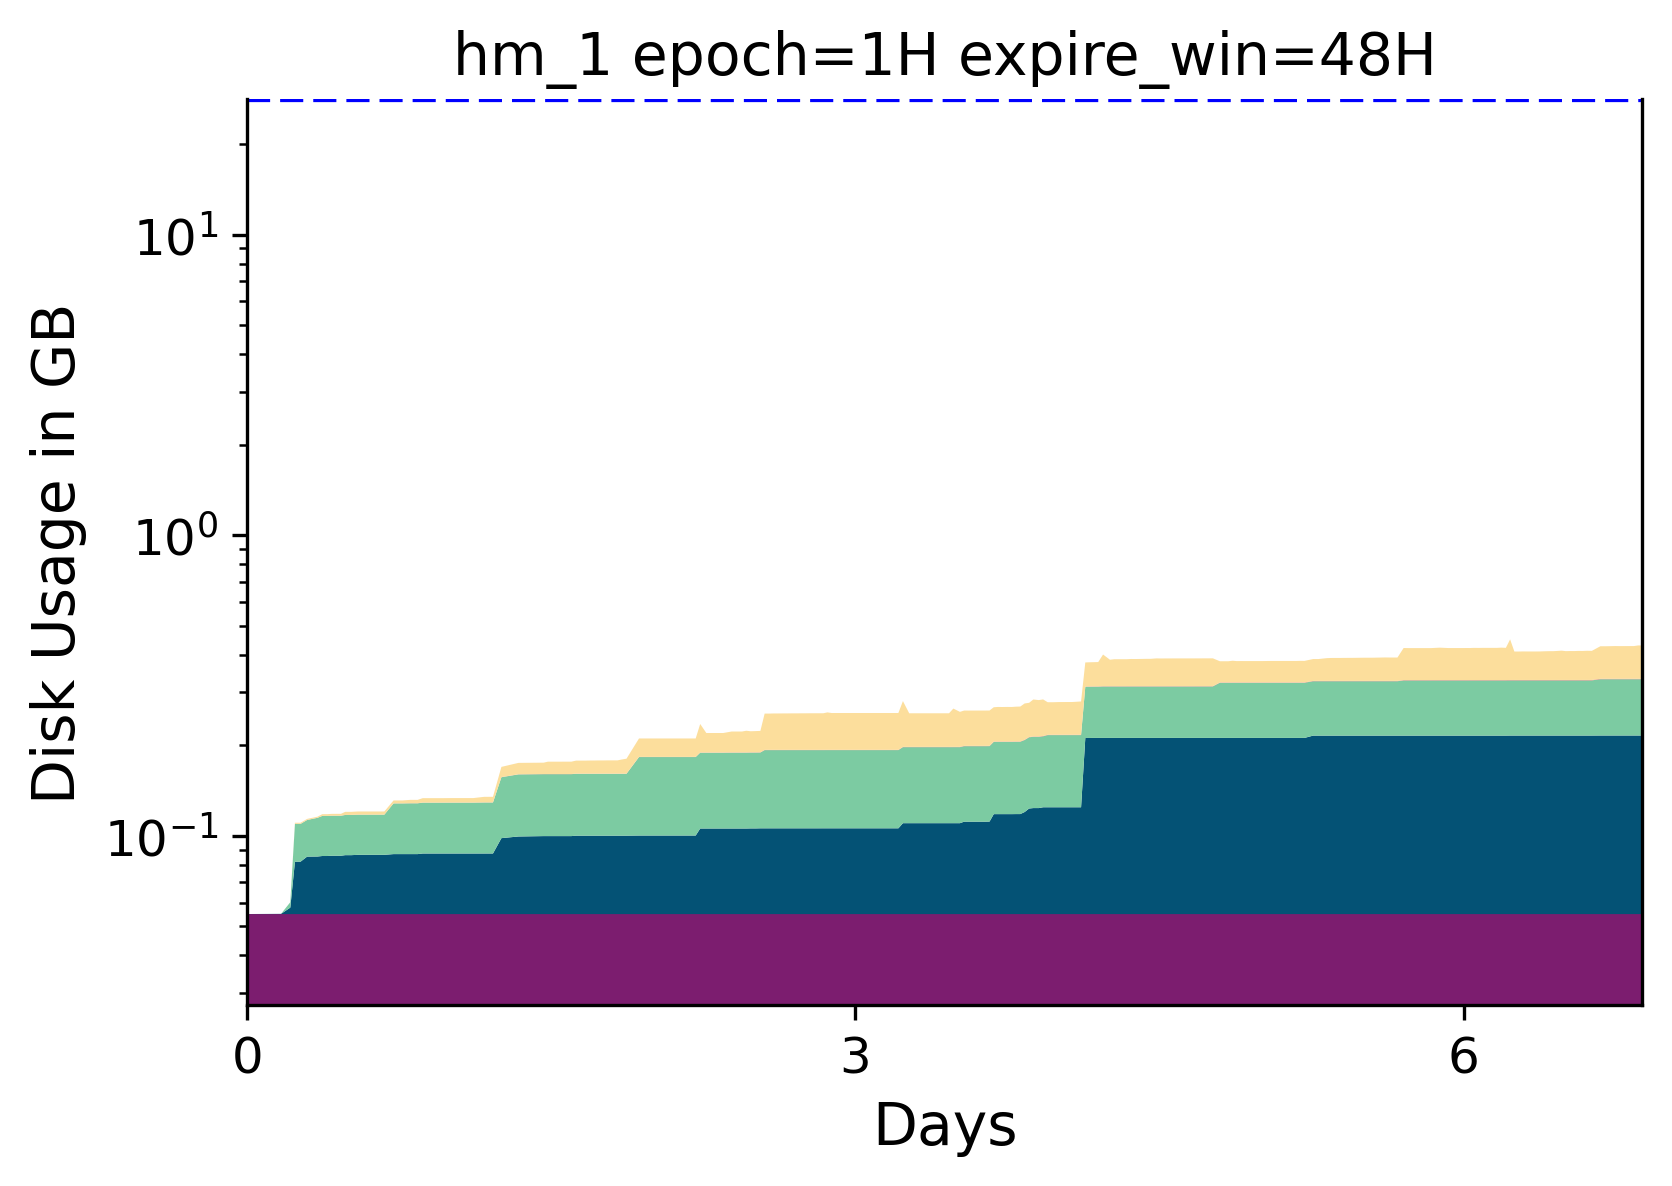

Invalid plot_FS_size
logic_disk_usage_GB:  15
max_version_FS:  19.948827639999998
written GB:  1.749352448
read GB:  1.975177216
old versions GB:  4.908806144
TL Metadata GB:  0.029296875
Versioning Metadata GB:  0.041081424
filesystem size GB:  15


<Figure size 1800x1200 with 0 Axes>

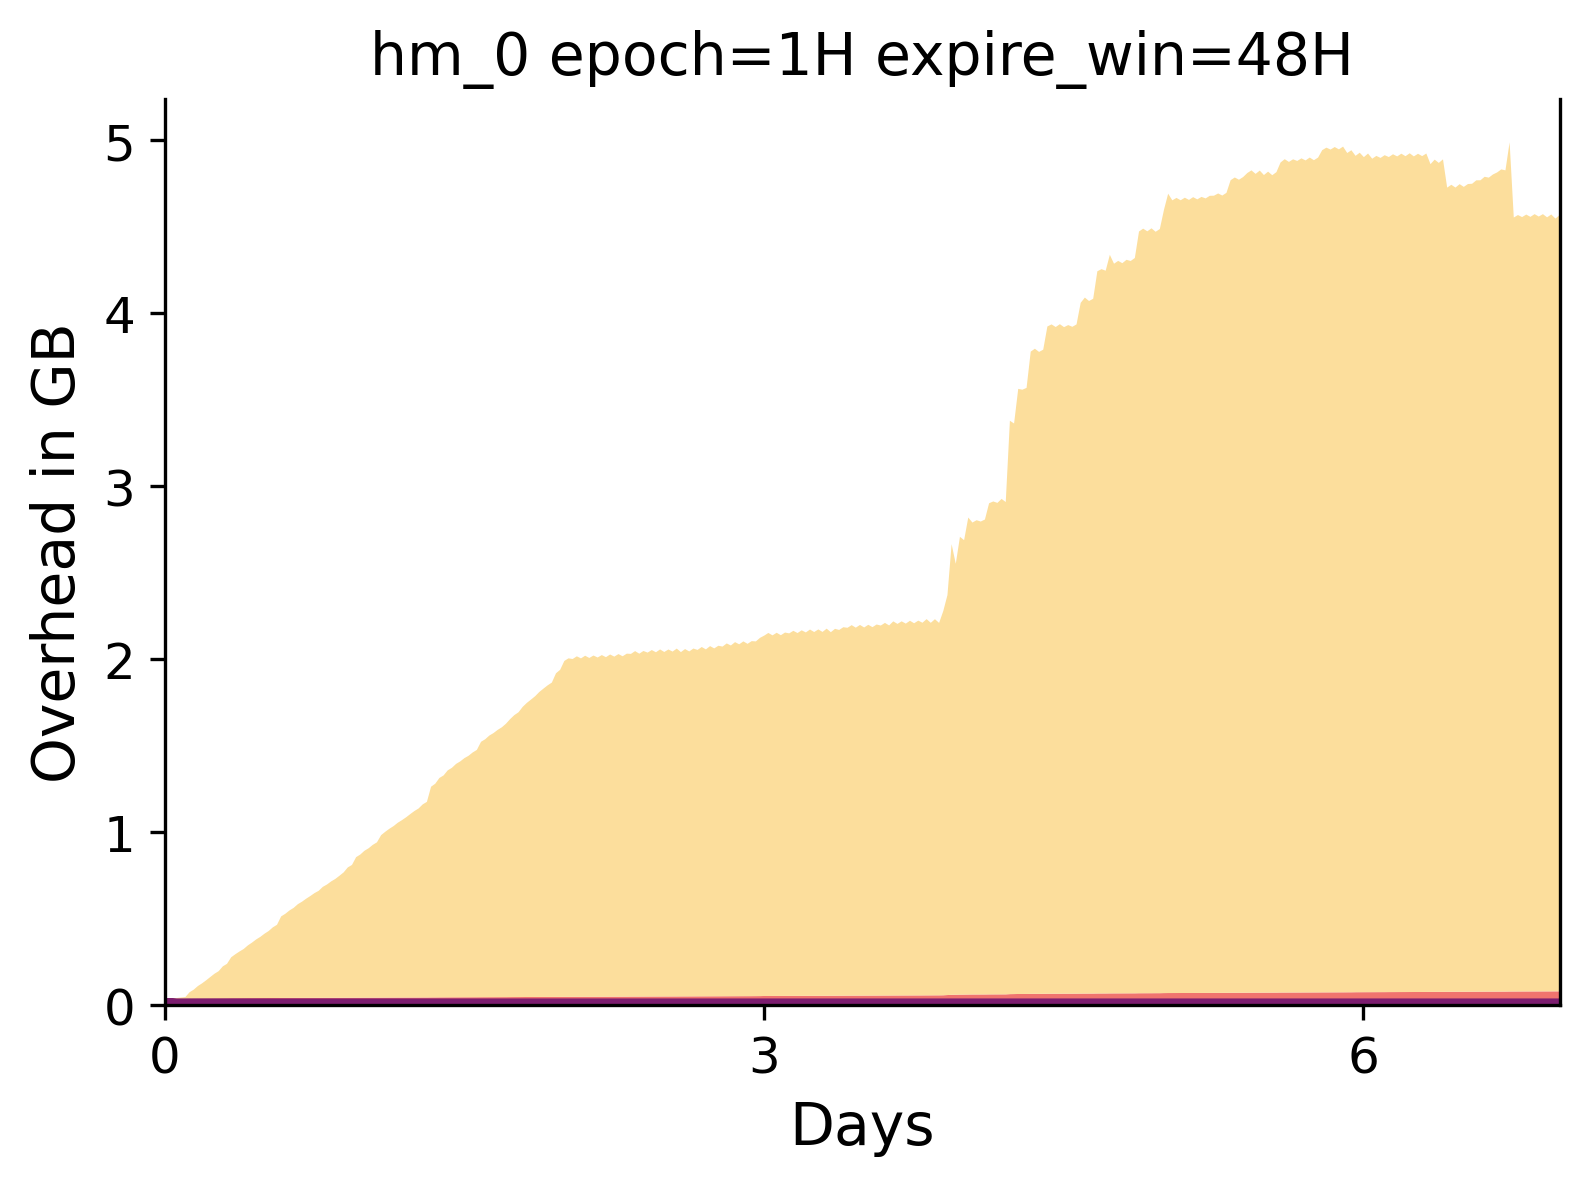

logic_disk_usage_GB:  15
max_version_FS:  19.948827639999998
written GB:  1.749352448
read GB:  1.975177216
old versions GB:  4.908806144
TL Metadata GB:  0.029296875
Versioning Metadata GB:  0.041081424
filesystem size GB:  15


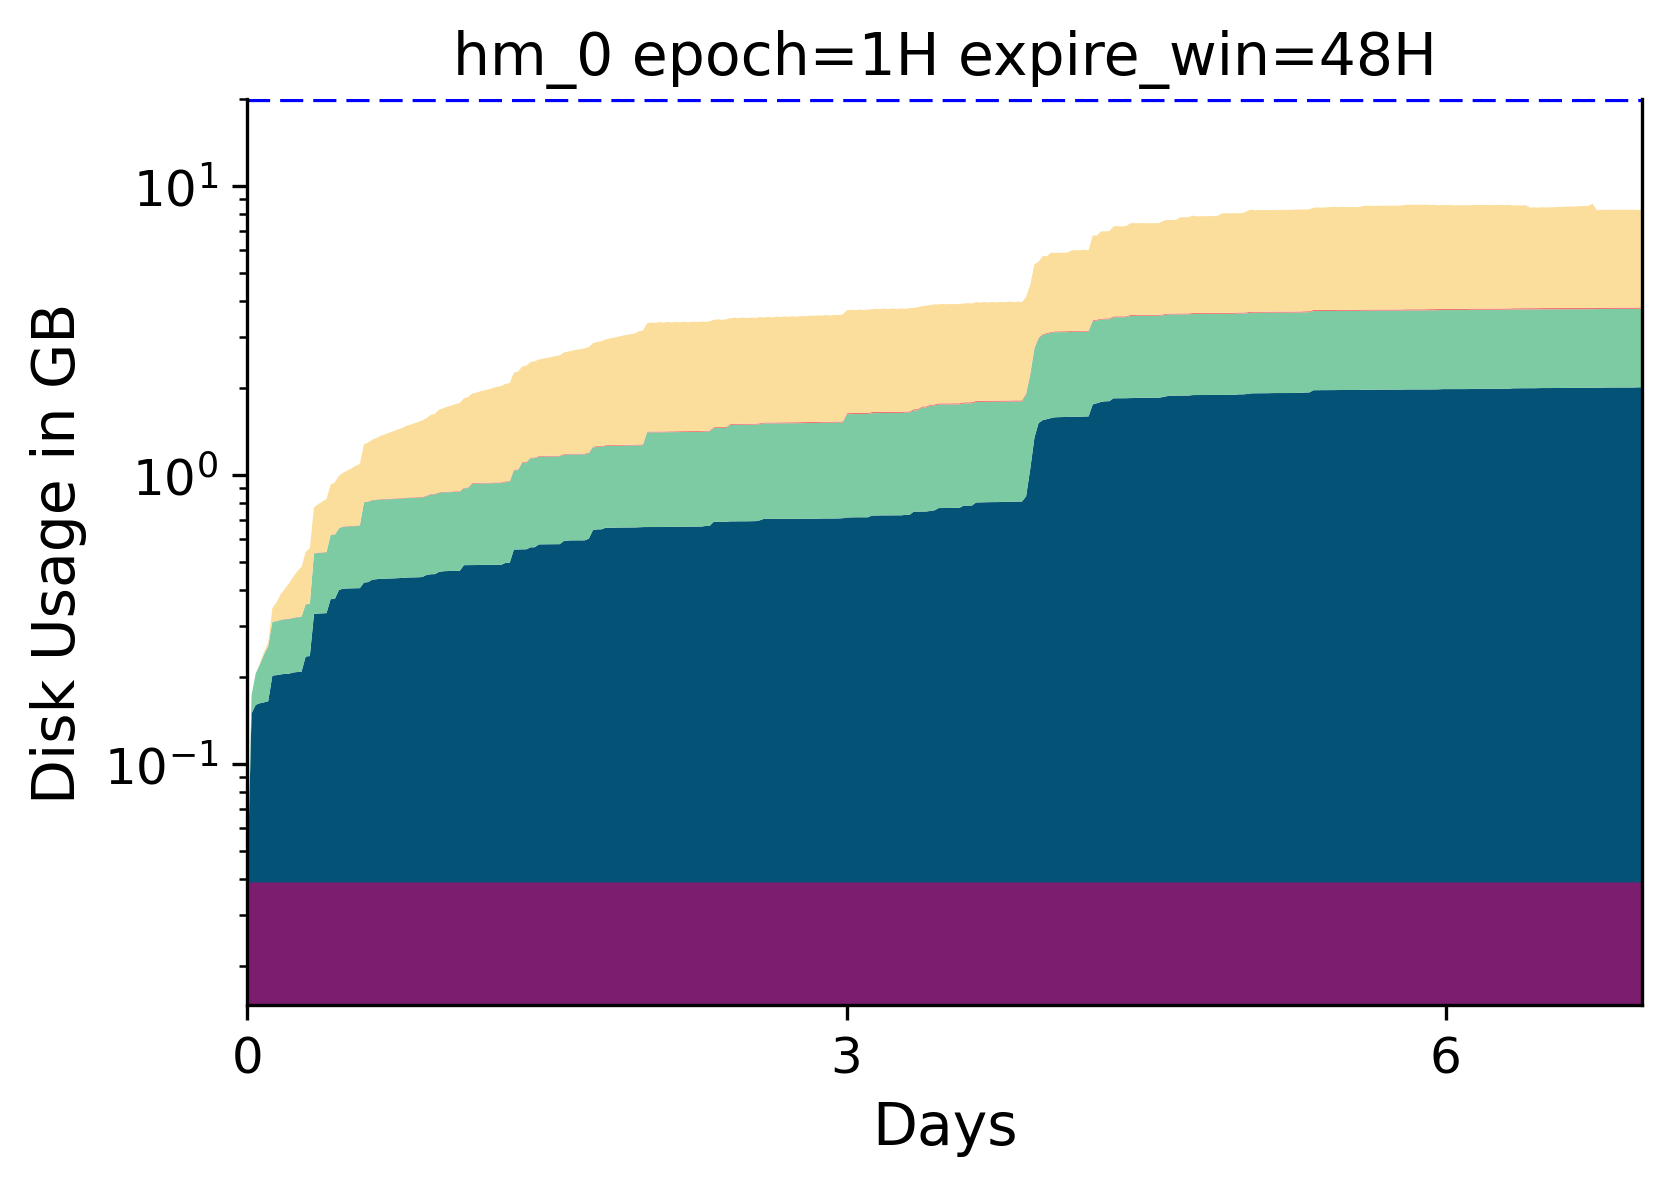

Invalid plot_FS_size
logic_disk_usage_GB:  28
max_version_FS:  28.3797886
written GB:  0.197689344
read GB:  0.224731136
old versions GB:  0.378662912
TL Metadata GB:  0.0546875
Versioning Metadata GB:  0.001125688
filesystem size GB:  28


<Figure size 1800x1200 with 0 Axes>

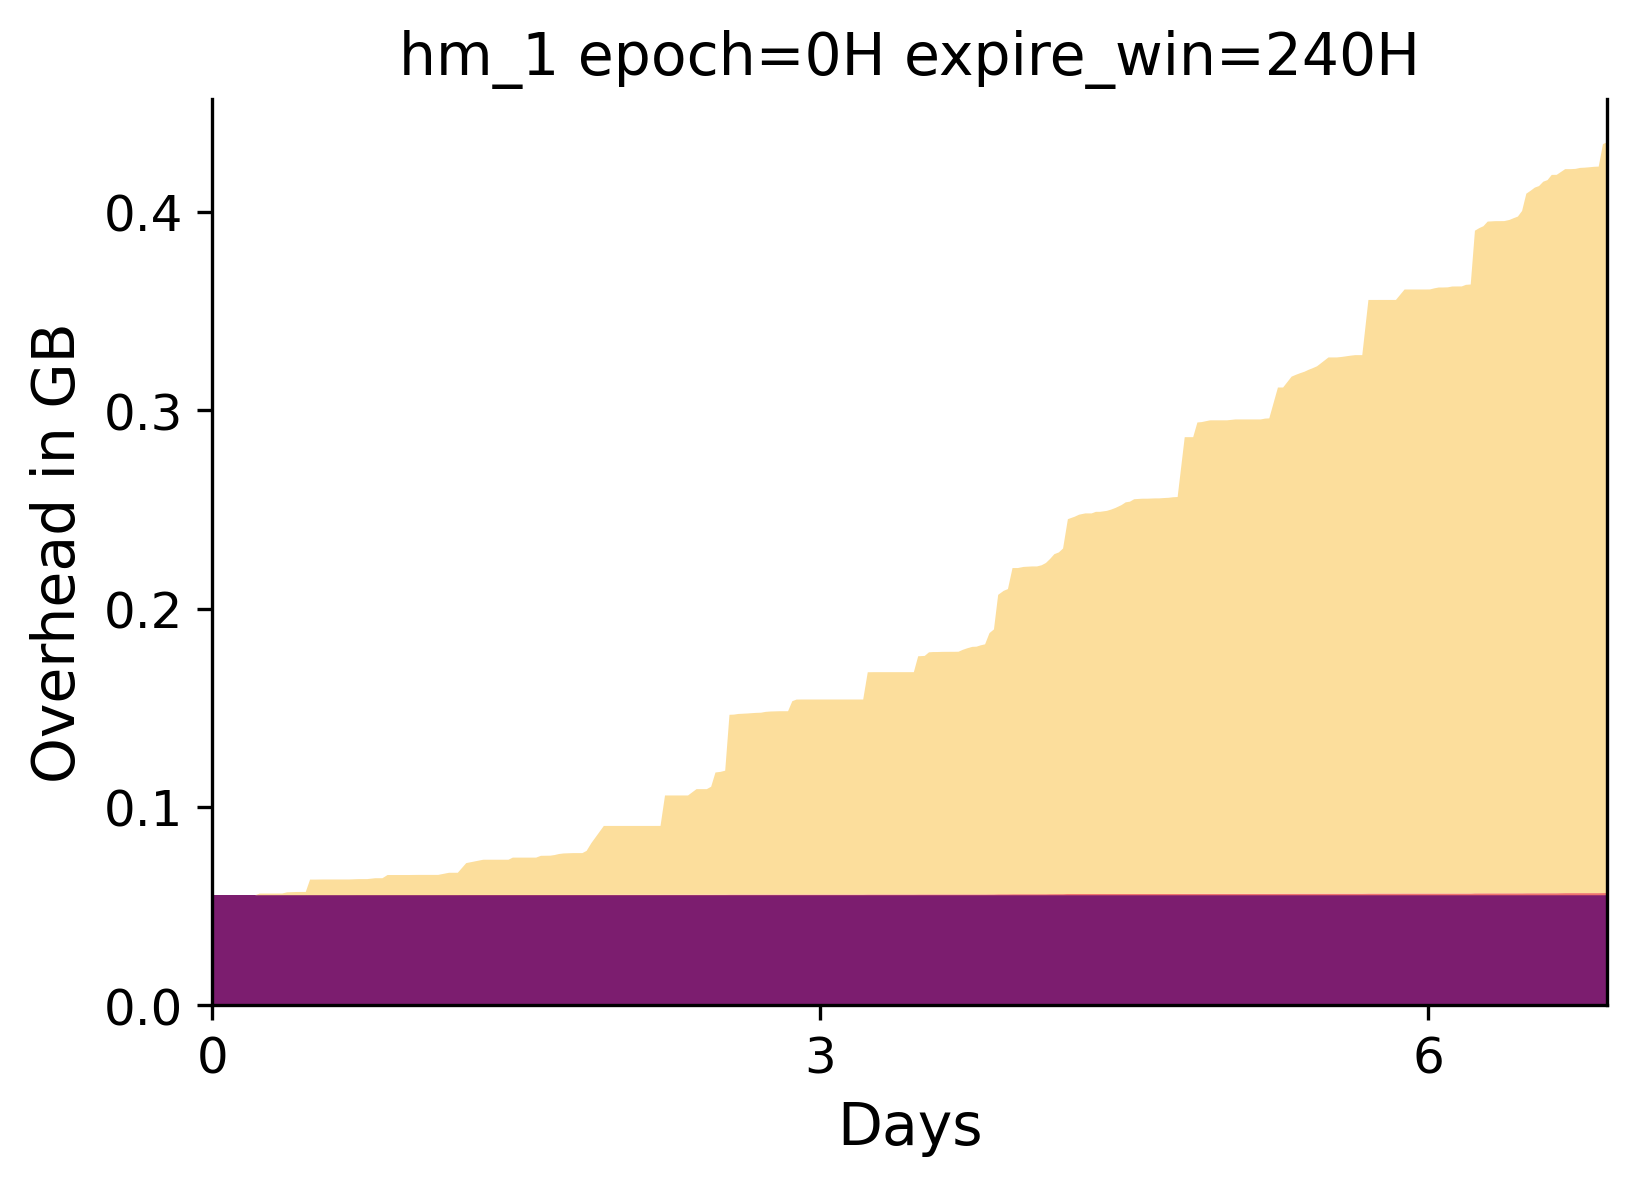

logic_disk_usage_GB:  28
max_version_FS:  28.3797886
written GB:  0.197689344
read GB:  0.224731136
old versions GB:  0.378662912
TL Metadata GB:  0.0546875
Versioning Metadata GB:  0.001125688
filesystem size GB:  28


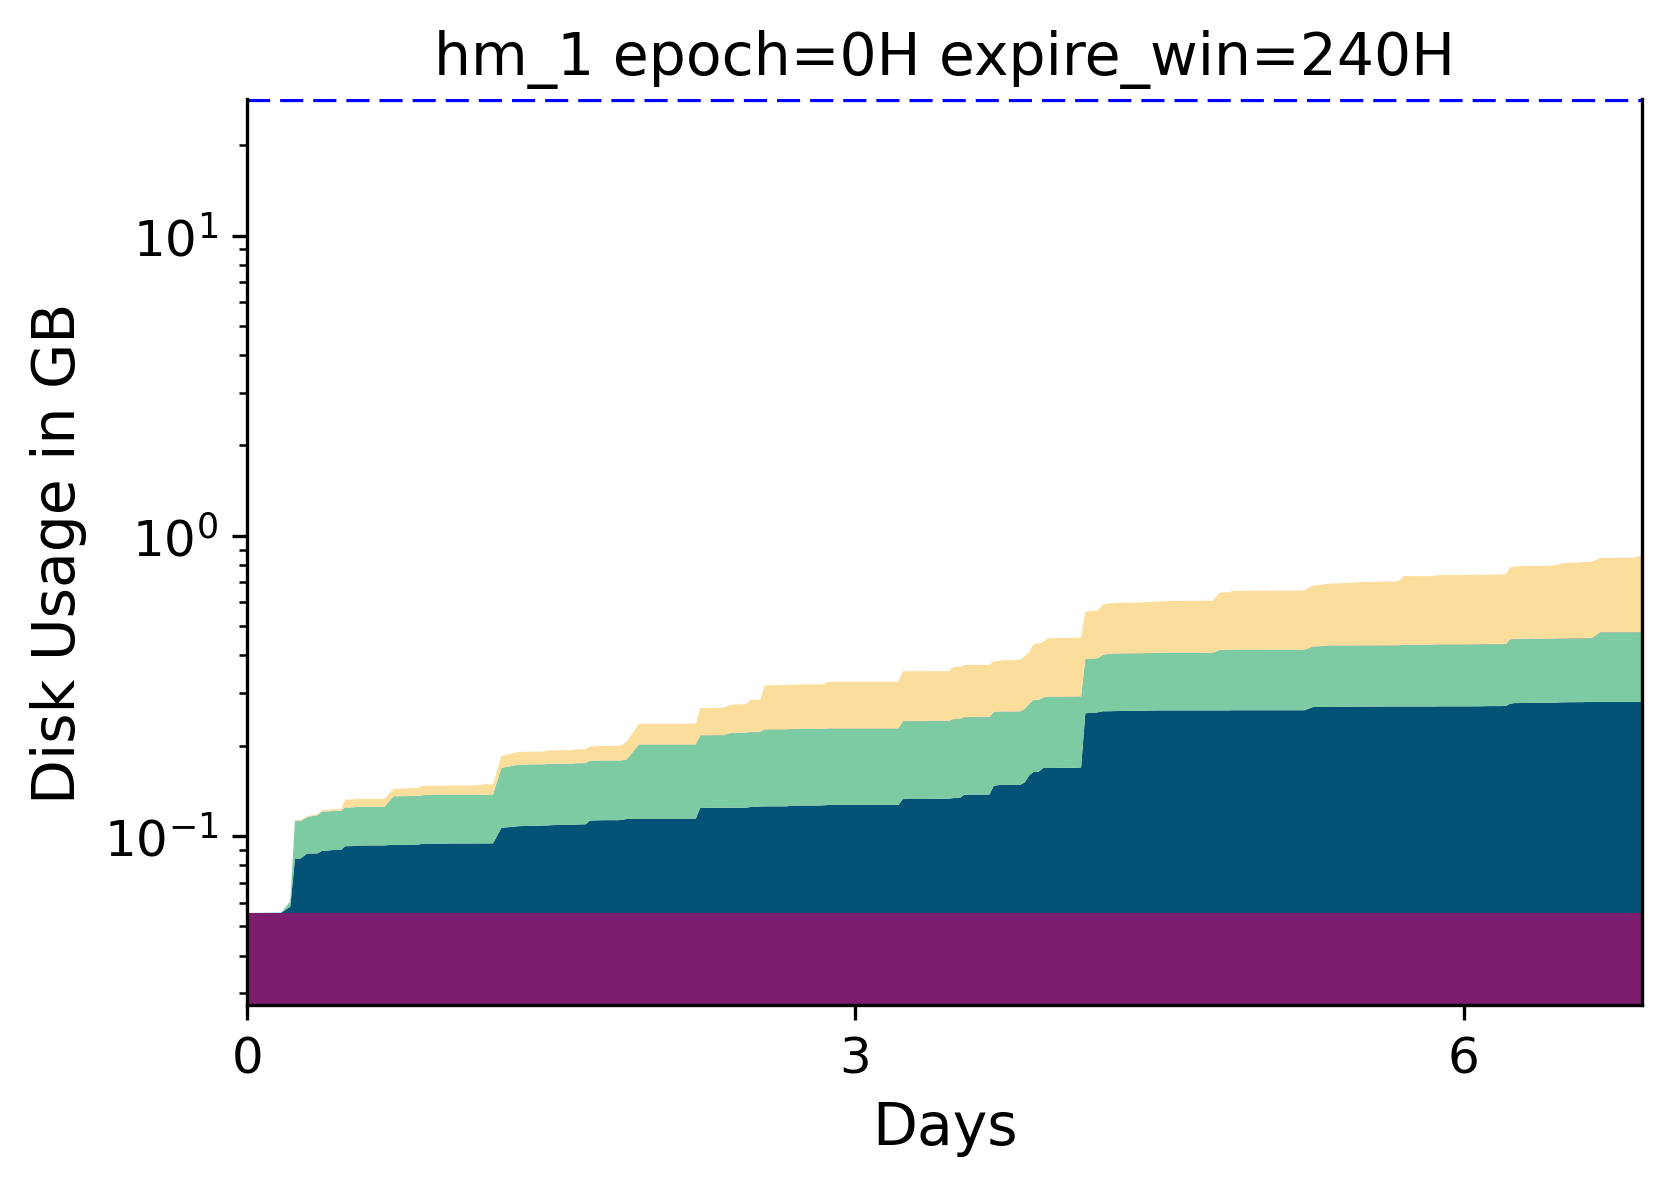

Invalid plot_FS_size
logic_disk_usage_GB:  72
max_version_FS:  86.755523704
written GB:  13.29129472
read GB:  3.98258176
old versions GB:  14.663458816
TL Metadata GB:  0.140625
Versioning Metadata GB:  0.092064888
filesystem size GB:  72


<Figure size 1800x1200 with 0 Axes>

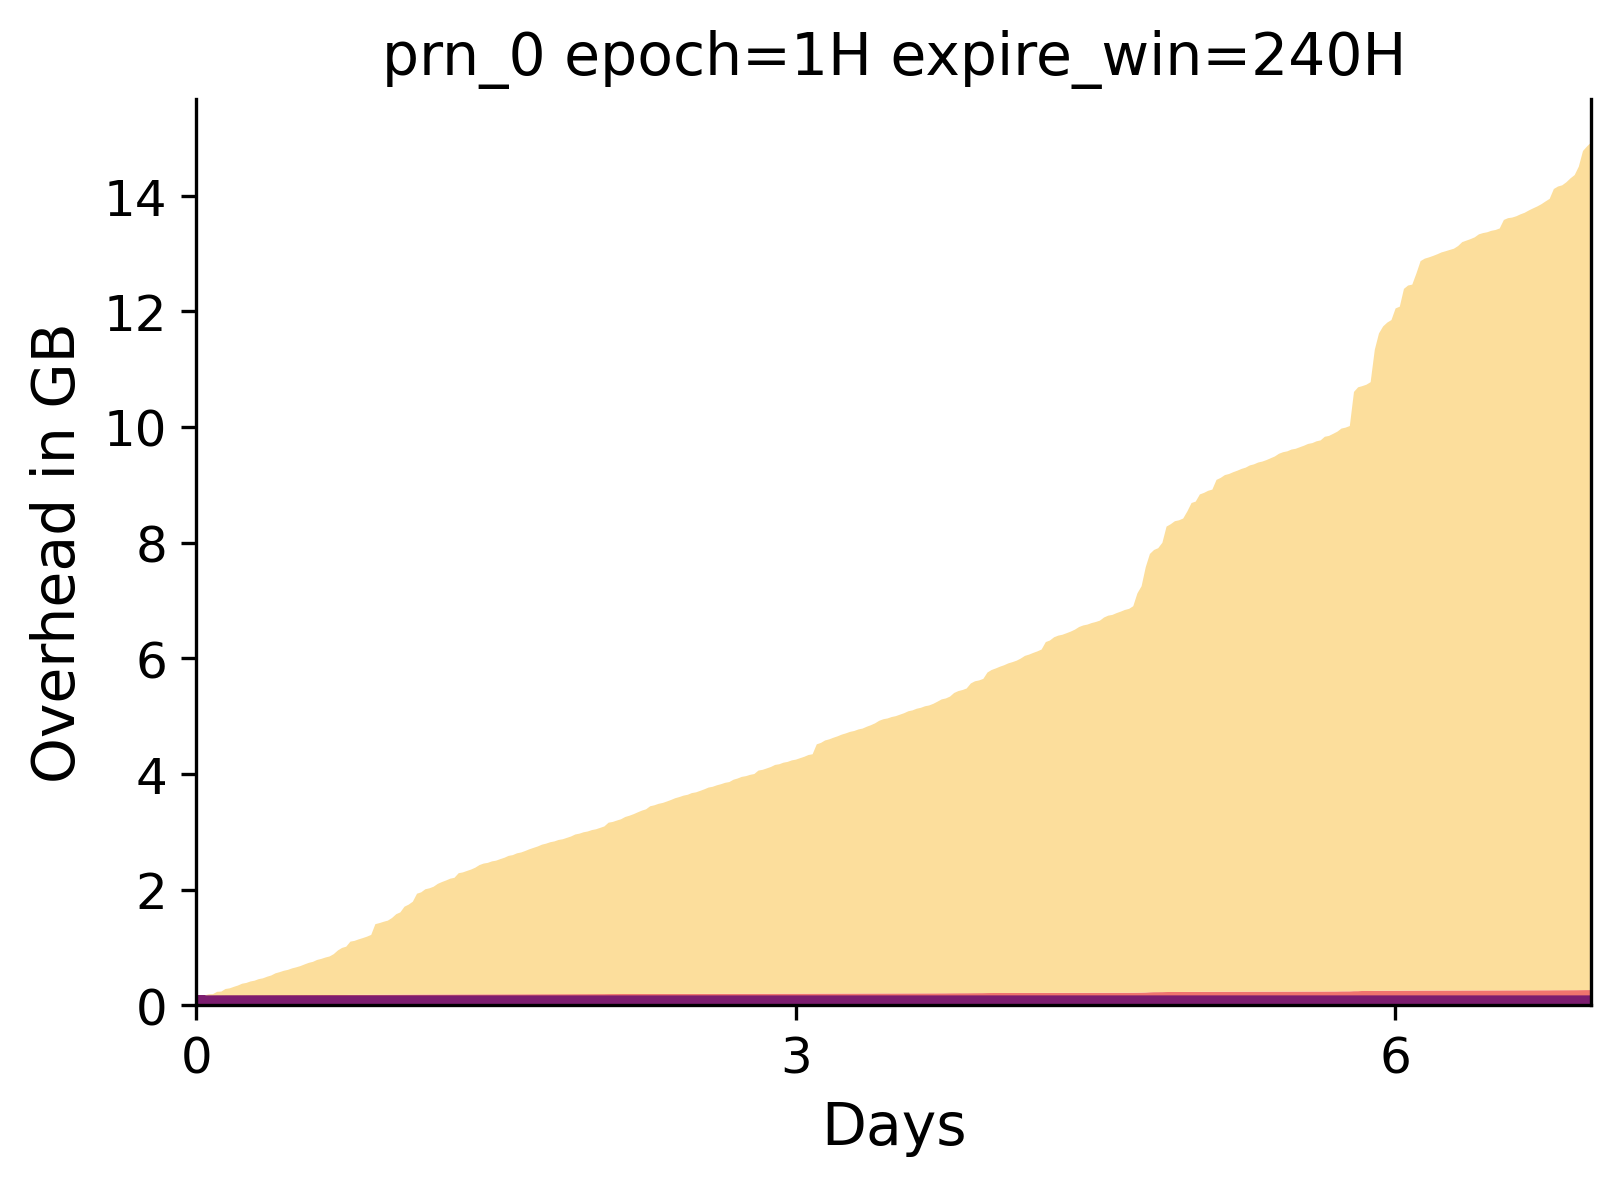

logic_disk_usage_GB:  72
max_version_FS:  86.755523704
written GB:  13.29129472
read GB:  3.98258176
old versions GB:  14.663458816
TL Metadata GB:  0.140625
Versioning Metadata GB:  0.092064888
filesystem size GB:  72


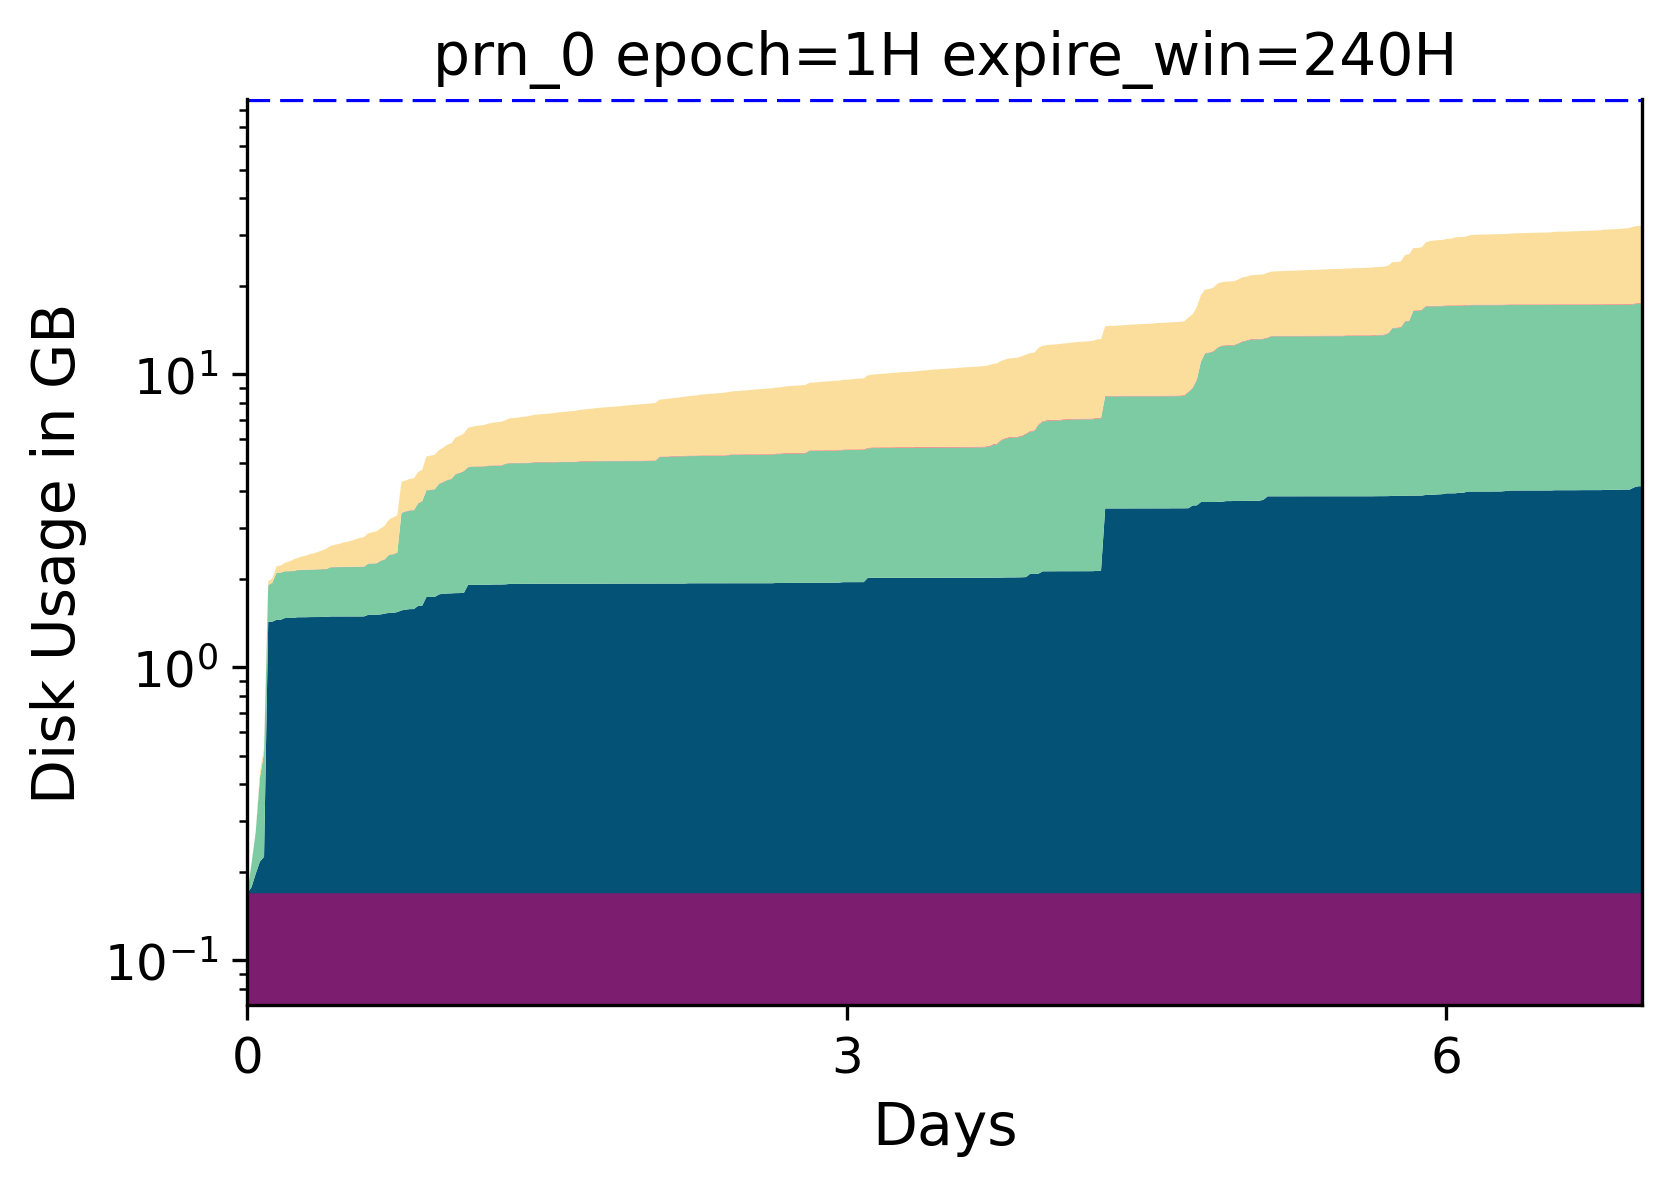

Invalid plot_FS_size
logic_disk_usage_GB:  460
max_version_FS:  463.923745736
written GB:  12.367884288
read GB:  79.221129216
old versions GB:  3.868475392
TL Metadata GB:  0.8984375
Versioning Metadata GB:  0.064482496
filesystem size GB:  460


<Figure size 1800x1200 with 0 Axes>

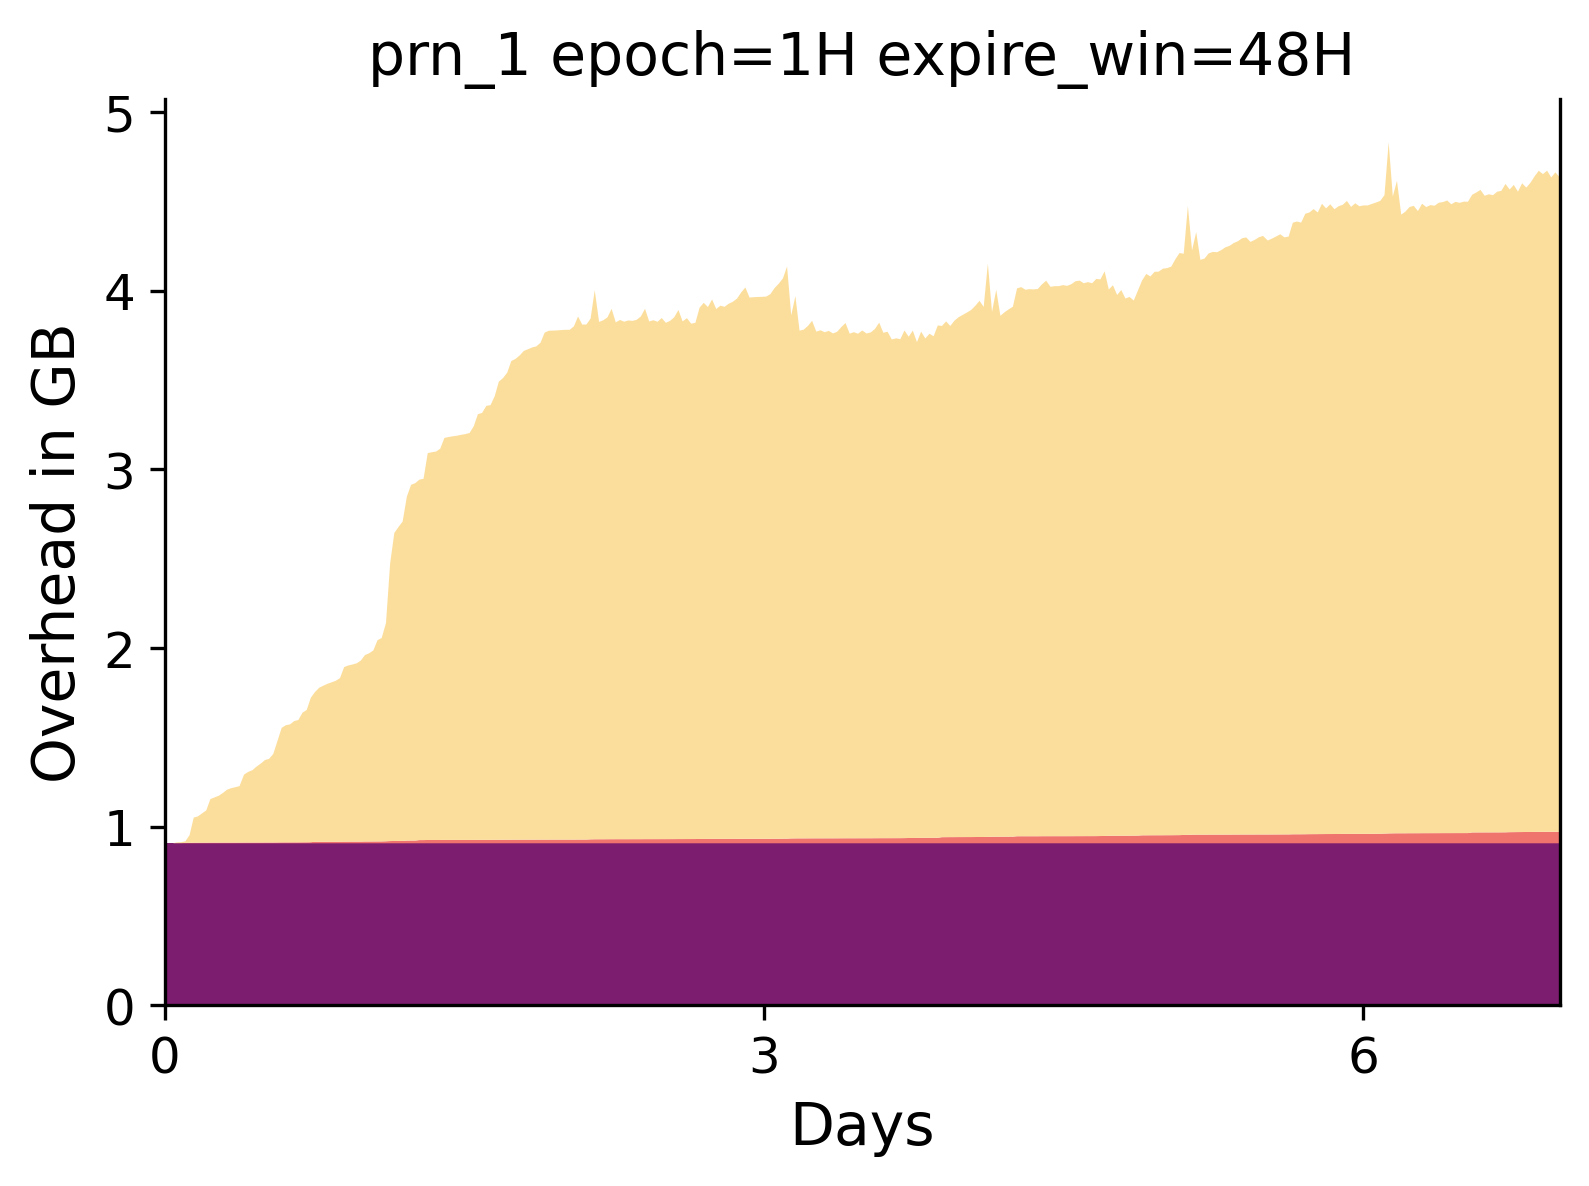

logic_disk_usage_GB:  460
max_version_FS:  463.923745736
written GB:  12.367884288
read GB:  79.221129216
old versions GB:  3.868475392
TL Metadata GB:  0.8984375
Versioning Metadata GB:  0.064482496
filesystem size GB:  460


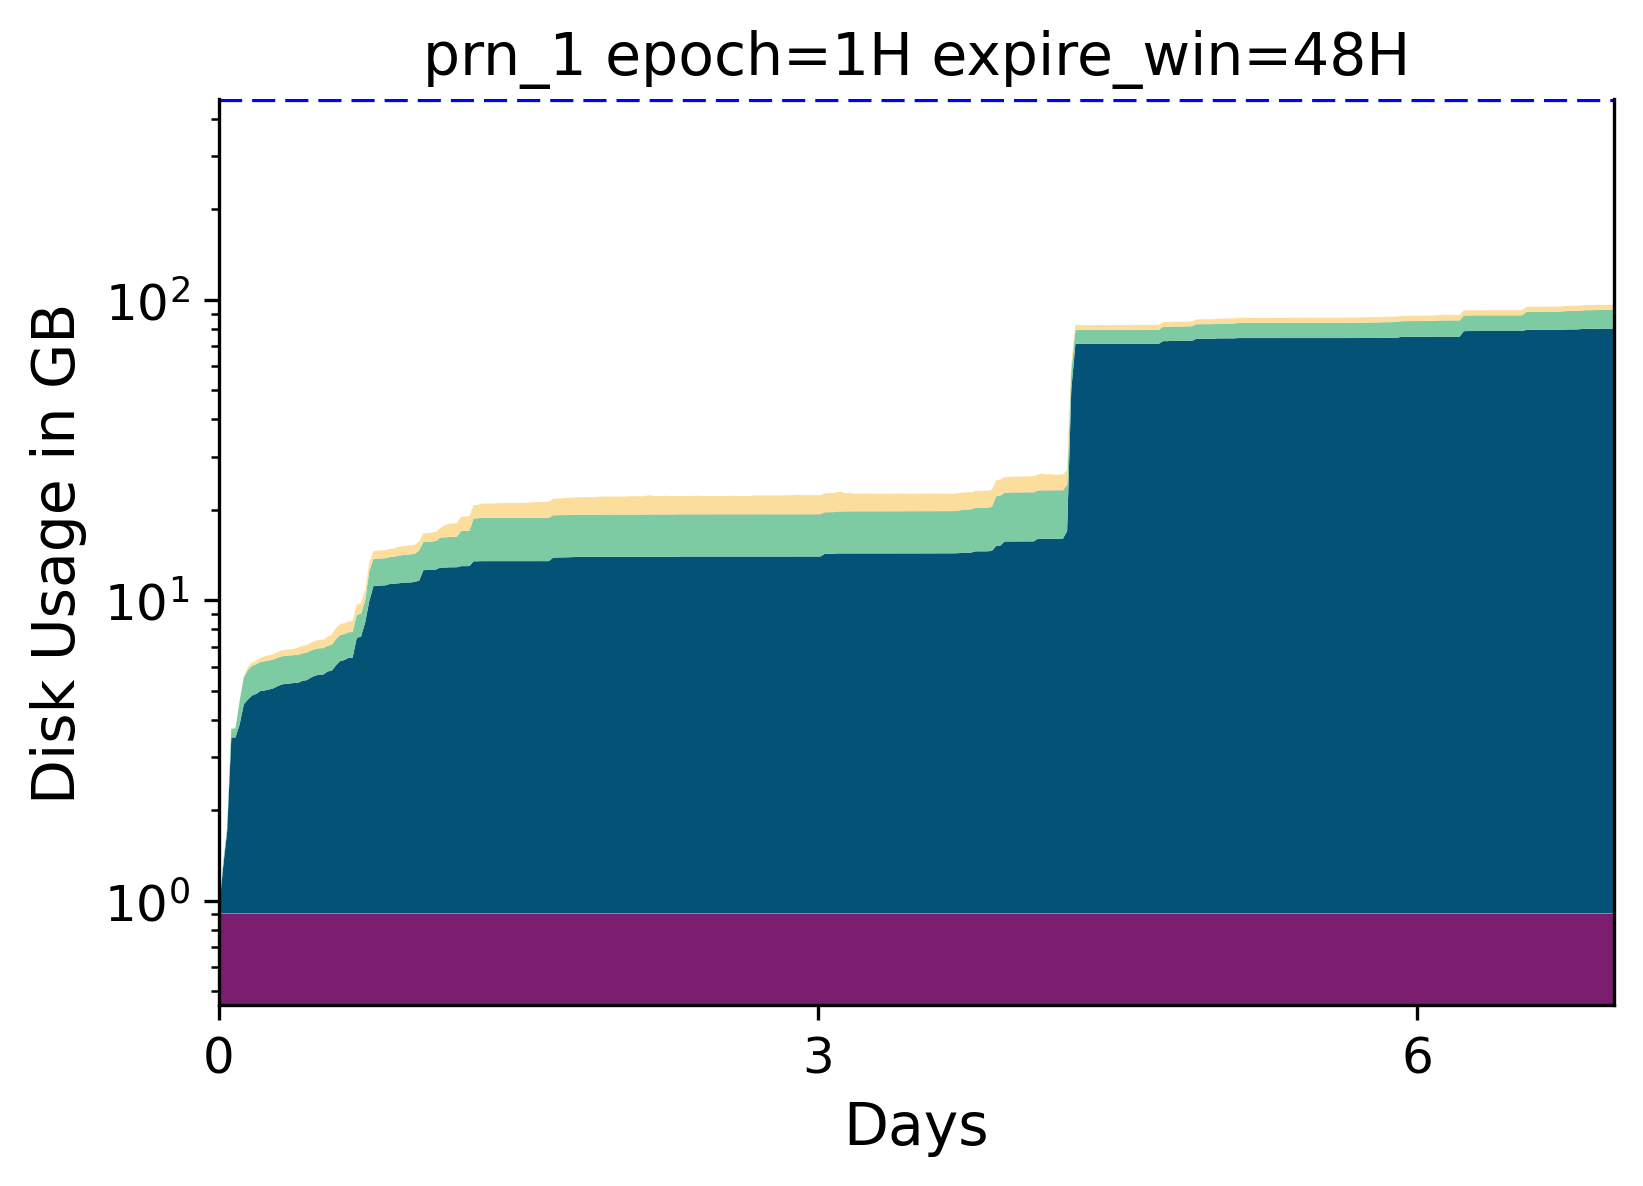

Invalid plot_FS_size
logic_disk_usage_GB:  460
max_version_FS:  472.29071072
written GB:  12.367884288
read GB:  79.221129216
old versions GB:  12.226228224
TL Metadata GB:  0.8984375
Versioning Metadata GB:  0.064482496
filesystem size GB:  460


<Figure size 1800x1200 with 0 Axes>

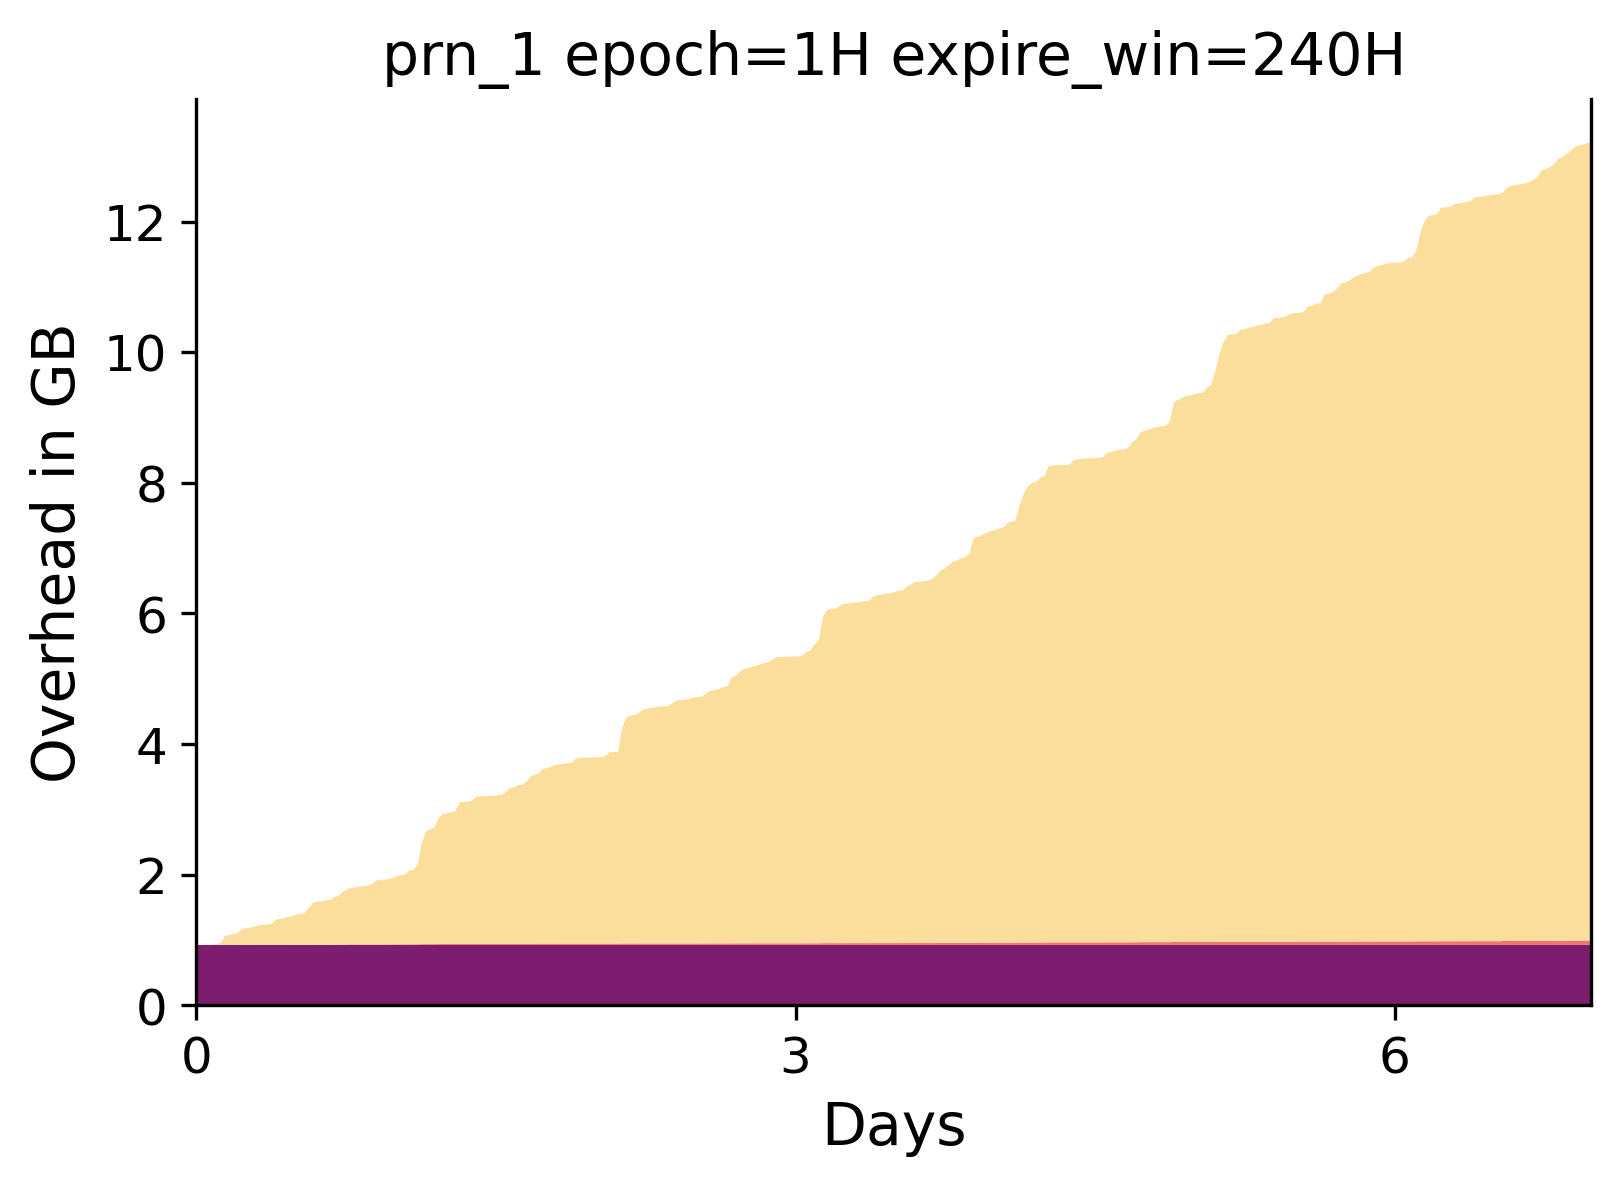

logic_disk_usage_GB:  460
max_version_FS:  472.29071072
written GB:  12.367884288
read GB:  79.221129216
old versions GB:  12.226228224
TL Metadata GB:  0.8984375
Versioning Metadata GB:  0.064482496
filesystem size GB:  460


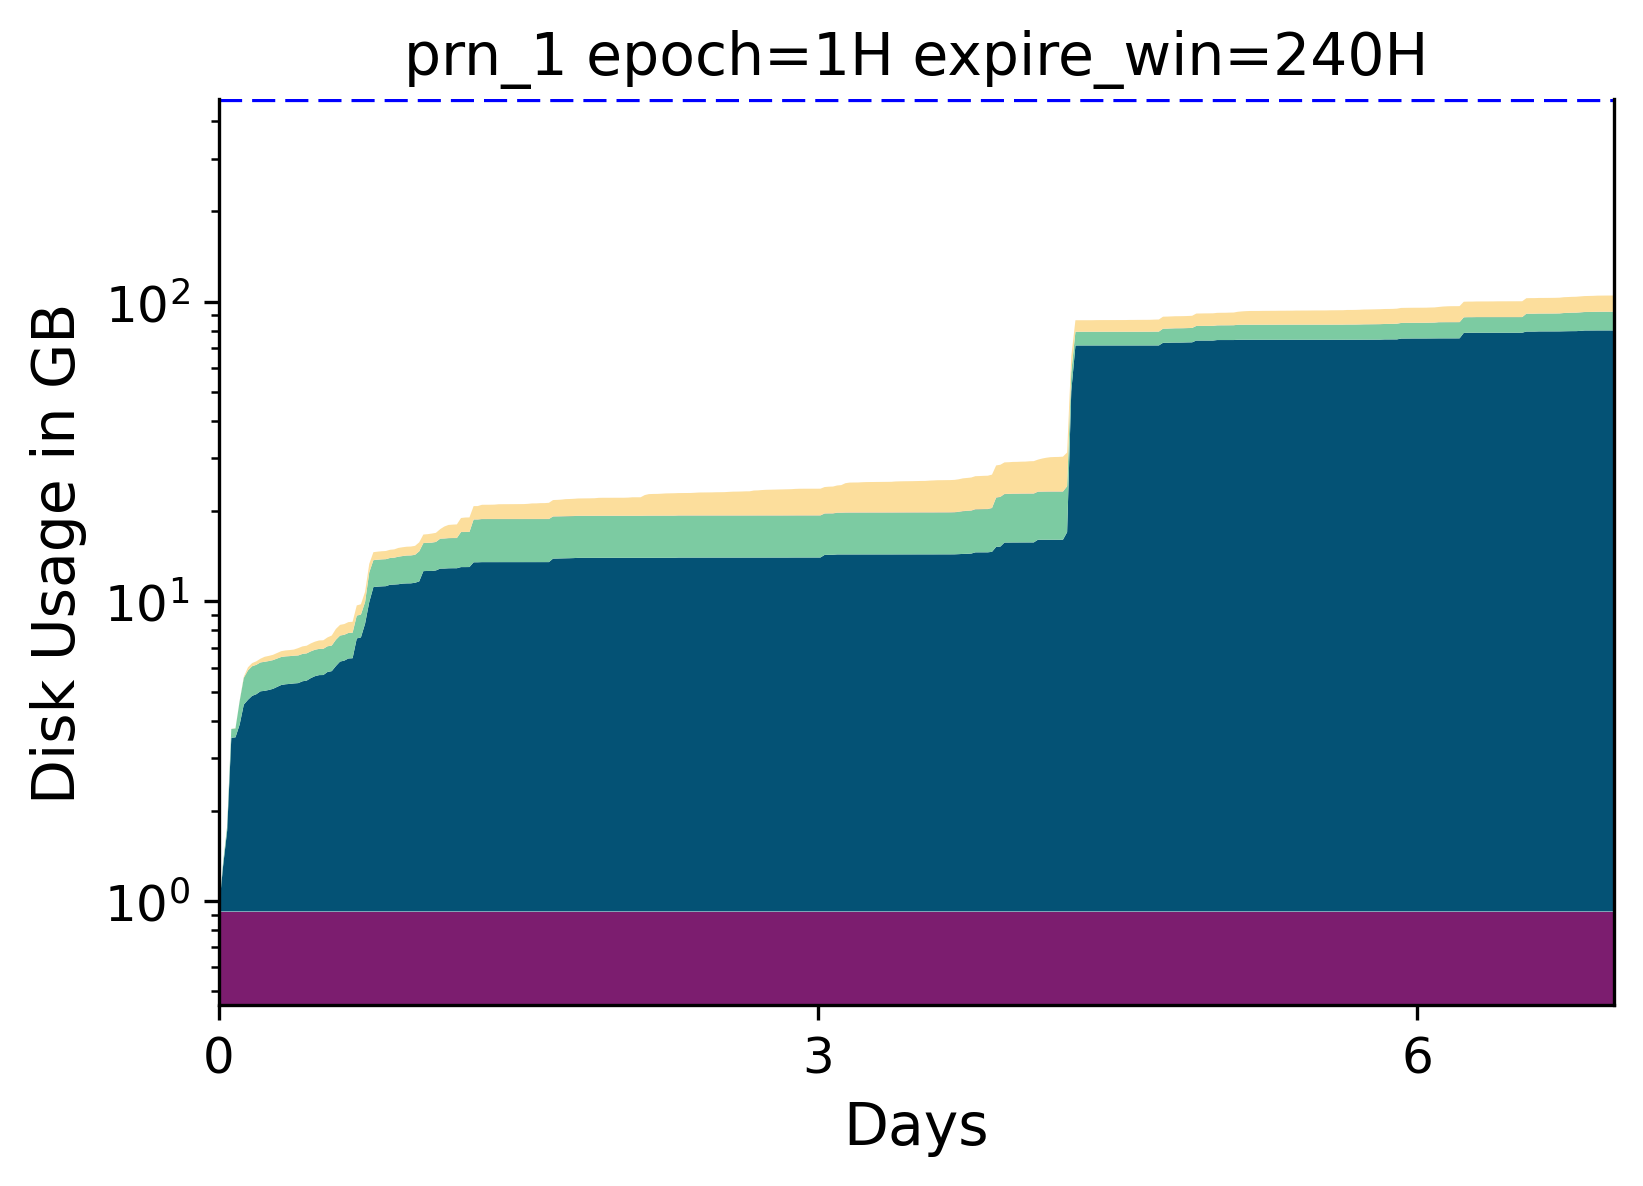

Invalid plot_FS_size
logic_disk_usage_GB:  18
max_version_FS:  28.239874288000003
written GB:  1.77364992
read GB:  1.855807488
old versions GB:  9.941004288
TL Metadata GB:  0.03515625
Versioning Metadata GB:  0.30231164
filesystem size GB:  18


<Figure size 1800x1200 with 0 Axes>

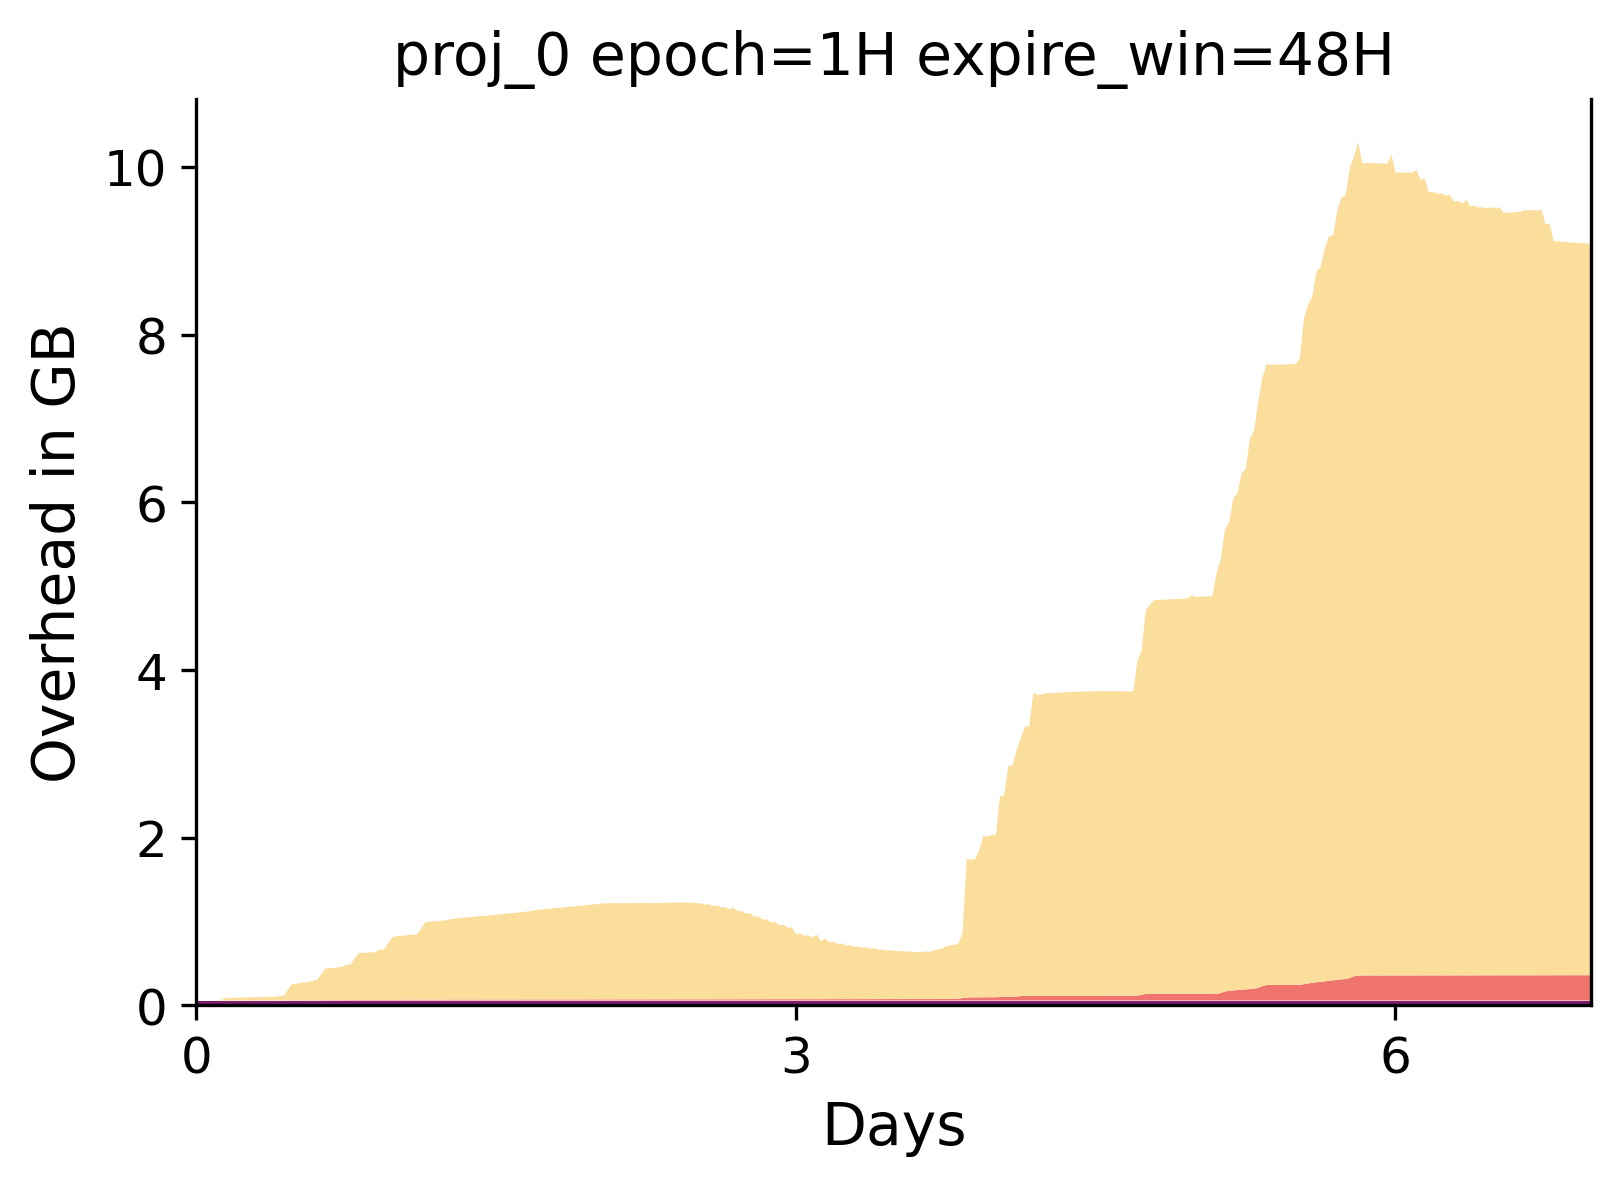

logic_disk_usage_GB:  18
max_version_FS:  28.239874288000003
written GB:  1.77364992
read GB:  1.855807488
old versions GB:  9.941004288
TL Metadata GB:  0.03515625
Versioning Metadata GB:  0.30231164
filesystem size GB:  18


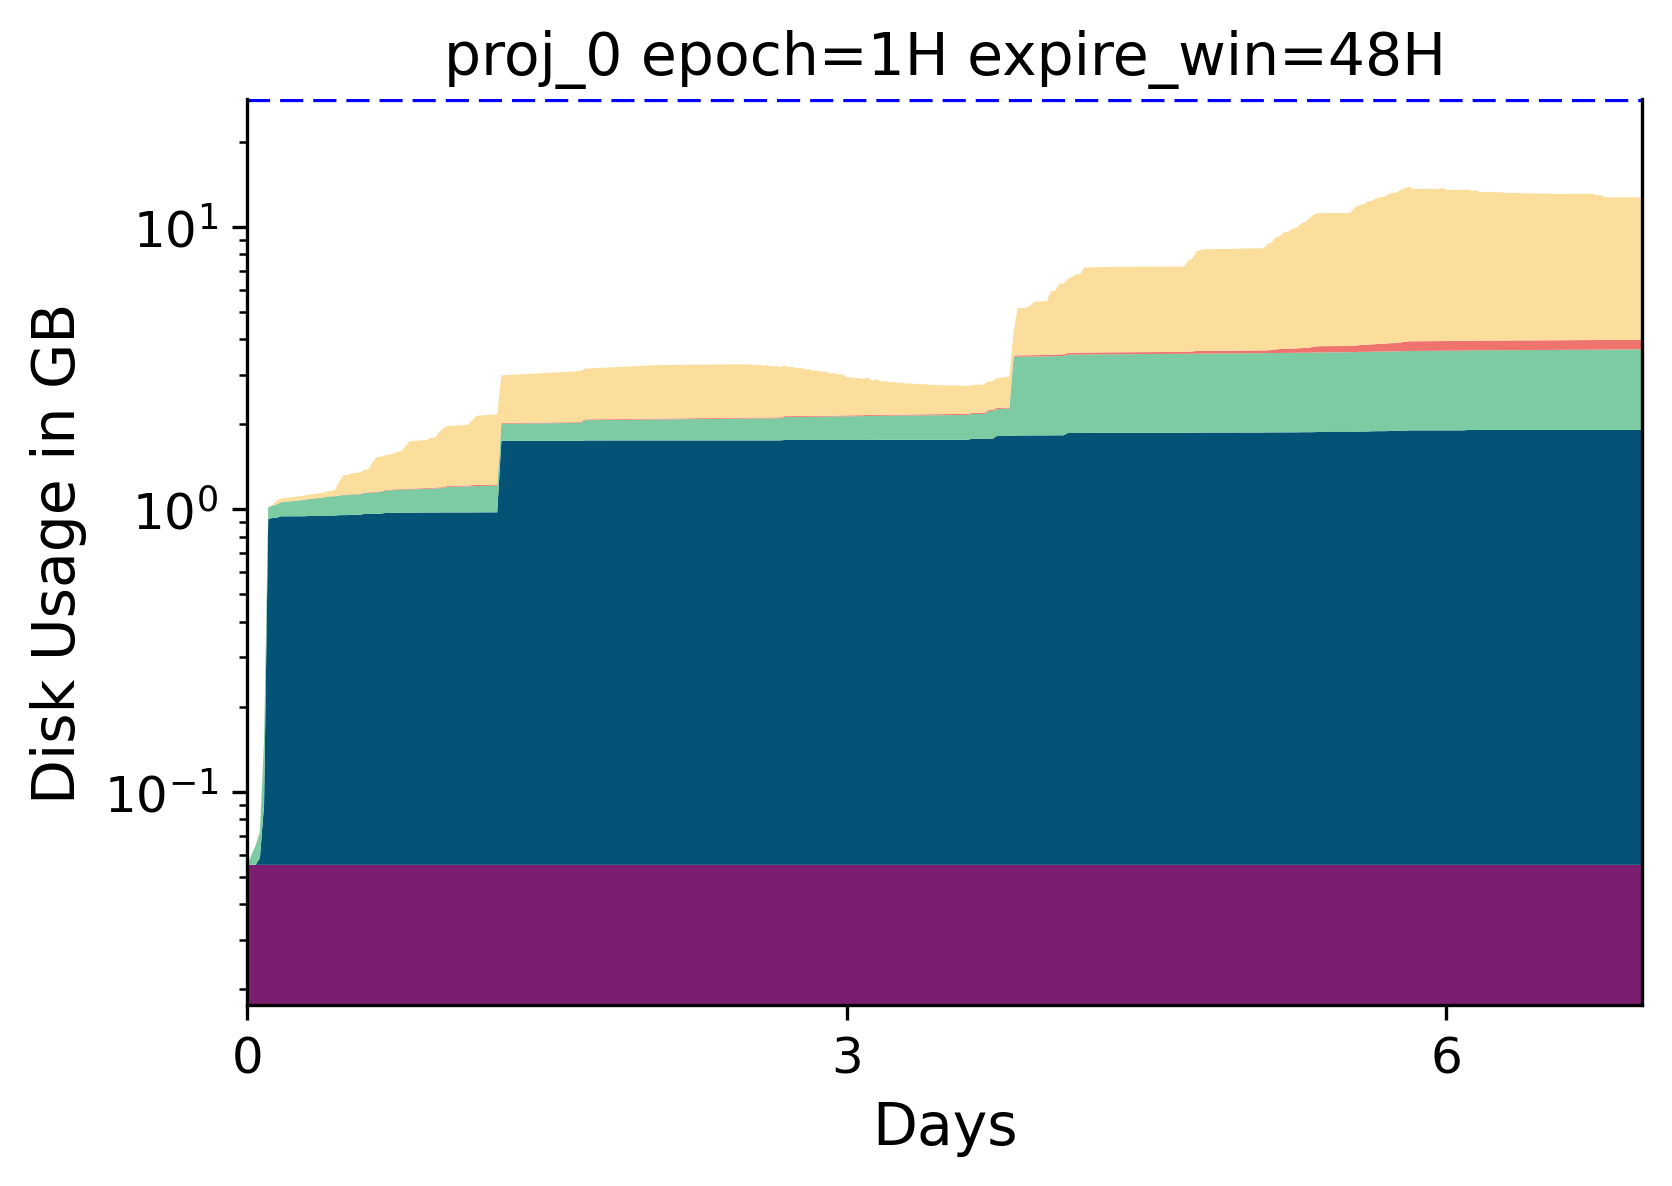

Invalid plot_FS_size
logic_disk_usage_GB:  15
max_version_FS:  21.302424344000002
written GB:  0.911945728
read GB:  0.675291136
old versions GB:  6.2882816
TL Metadata GB:  0.029296875
Versioning Metadata GB:  0.014142744
filesystem size GB:  15


<Figure size 1800x1200 with 0 Axes>

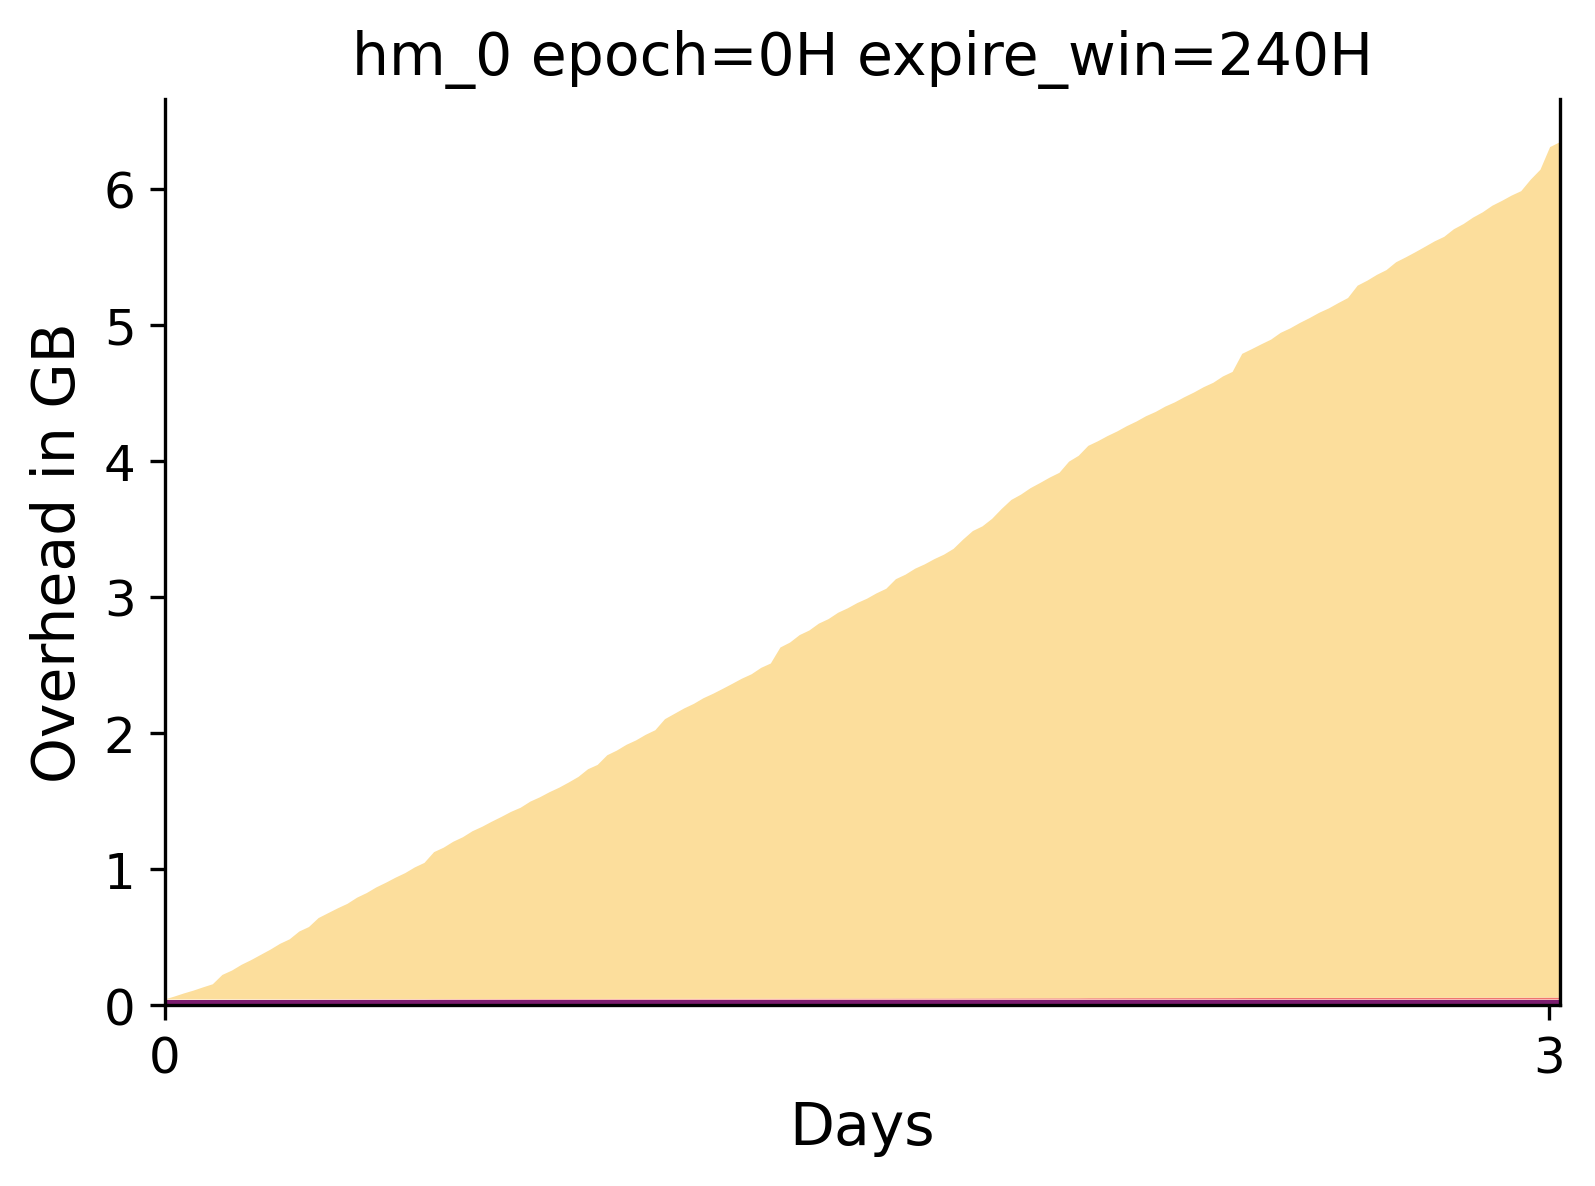

logic_disk_usage_GB:  15
max_version_FS:  21.302424344000002
written GB:  0.911945728
read GB:  0.675291136
old versions GB:  6.2882816
TL Metadata GB:  0.029296875
Versioning Metadata GB:  0.014142744
filesystem size GB:  15


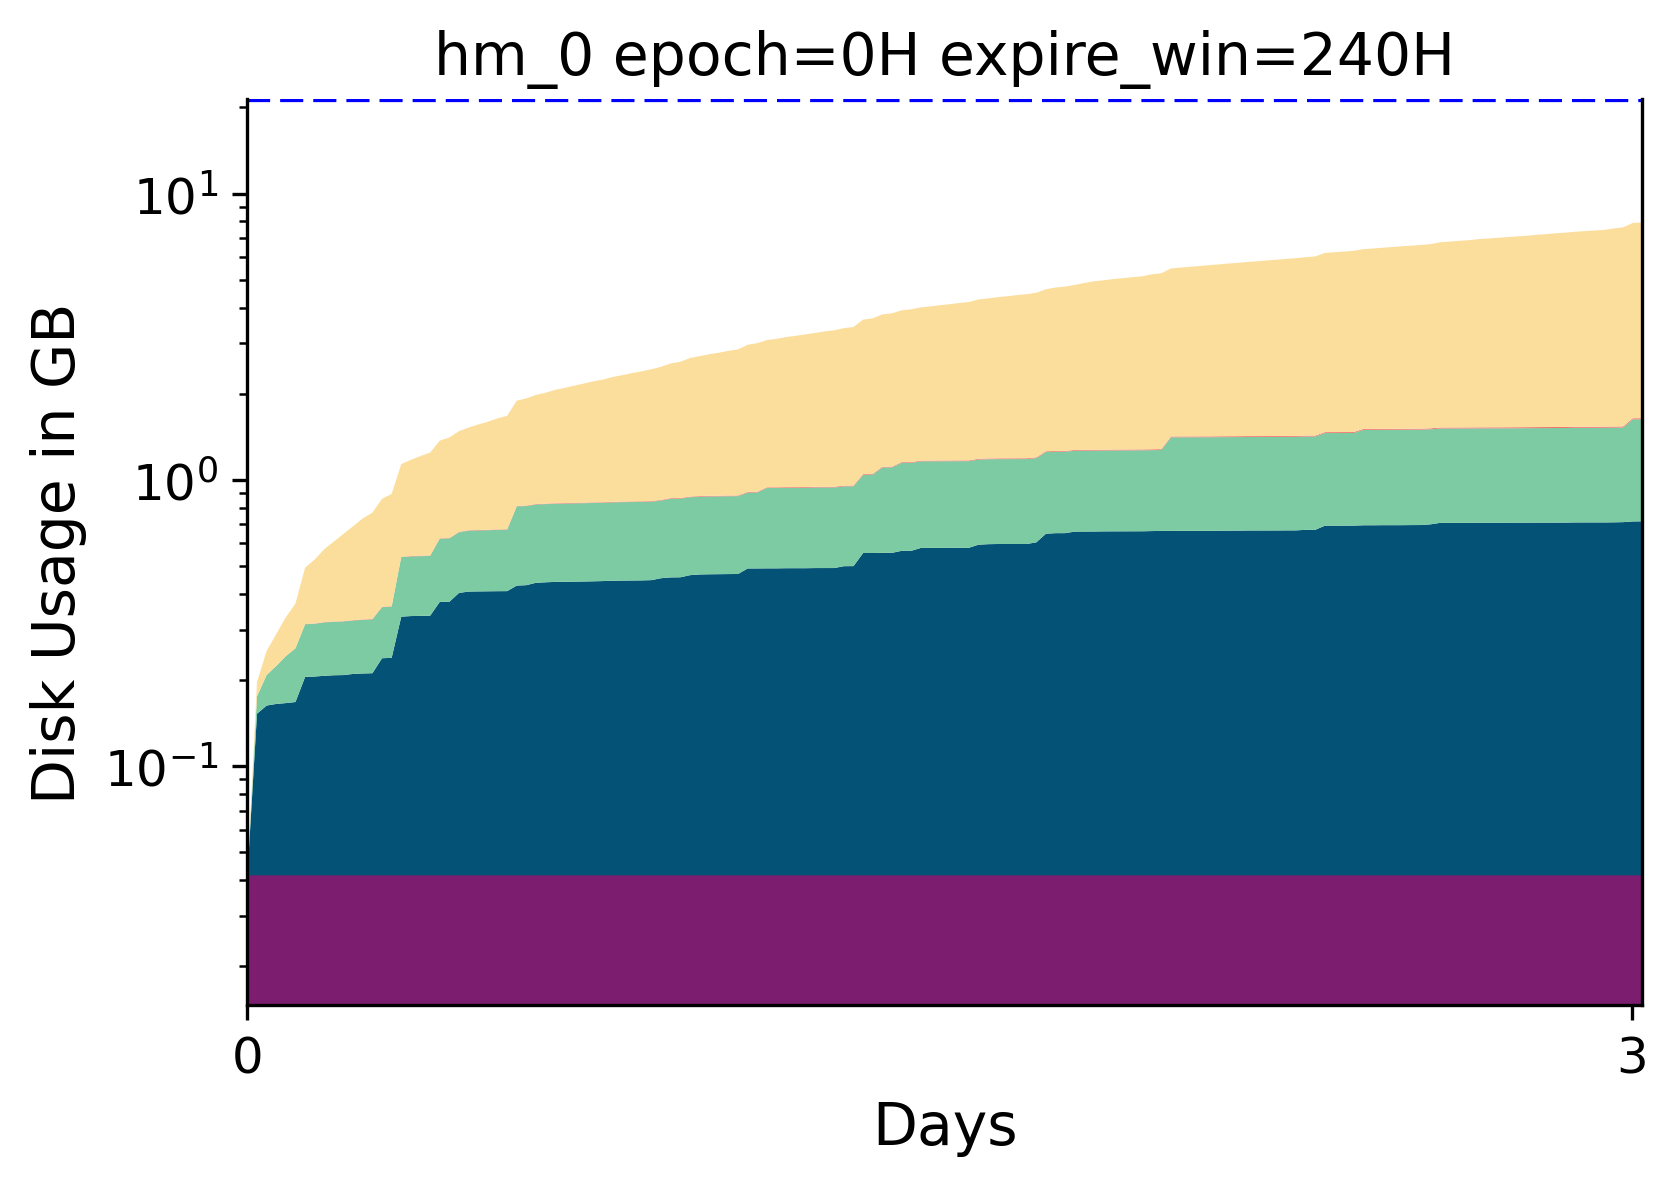

Invalid plot_FS_size
logic_disk_usage_GB:  15
max_version_FS:  26.148749392
written GB:  1.749352448
read GB:  1.975177216
old versions GB:  11.107667968
TL Metadata GB:  0.029296875
Versioning Metadata GB:  0.041081424
filesystem size GB:  15


<Figure size 1800x1200 with 0 Axes>

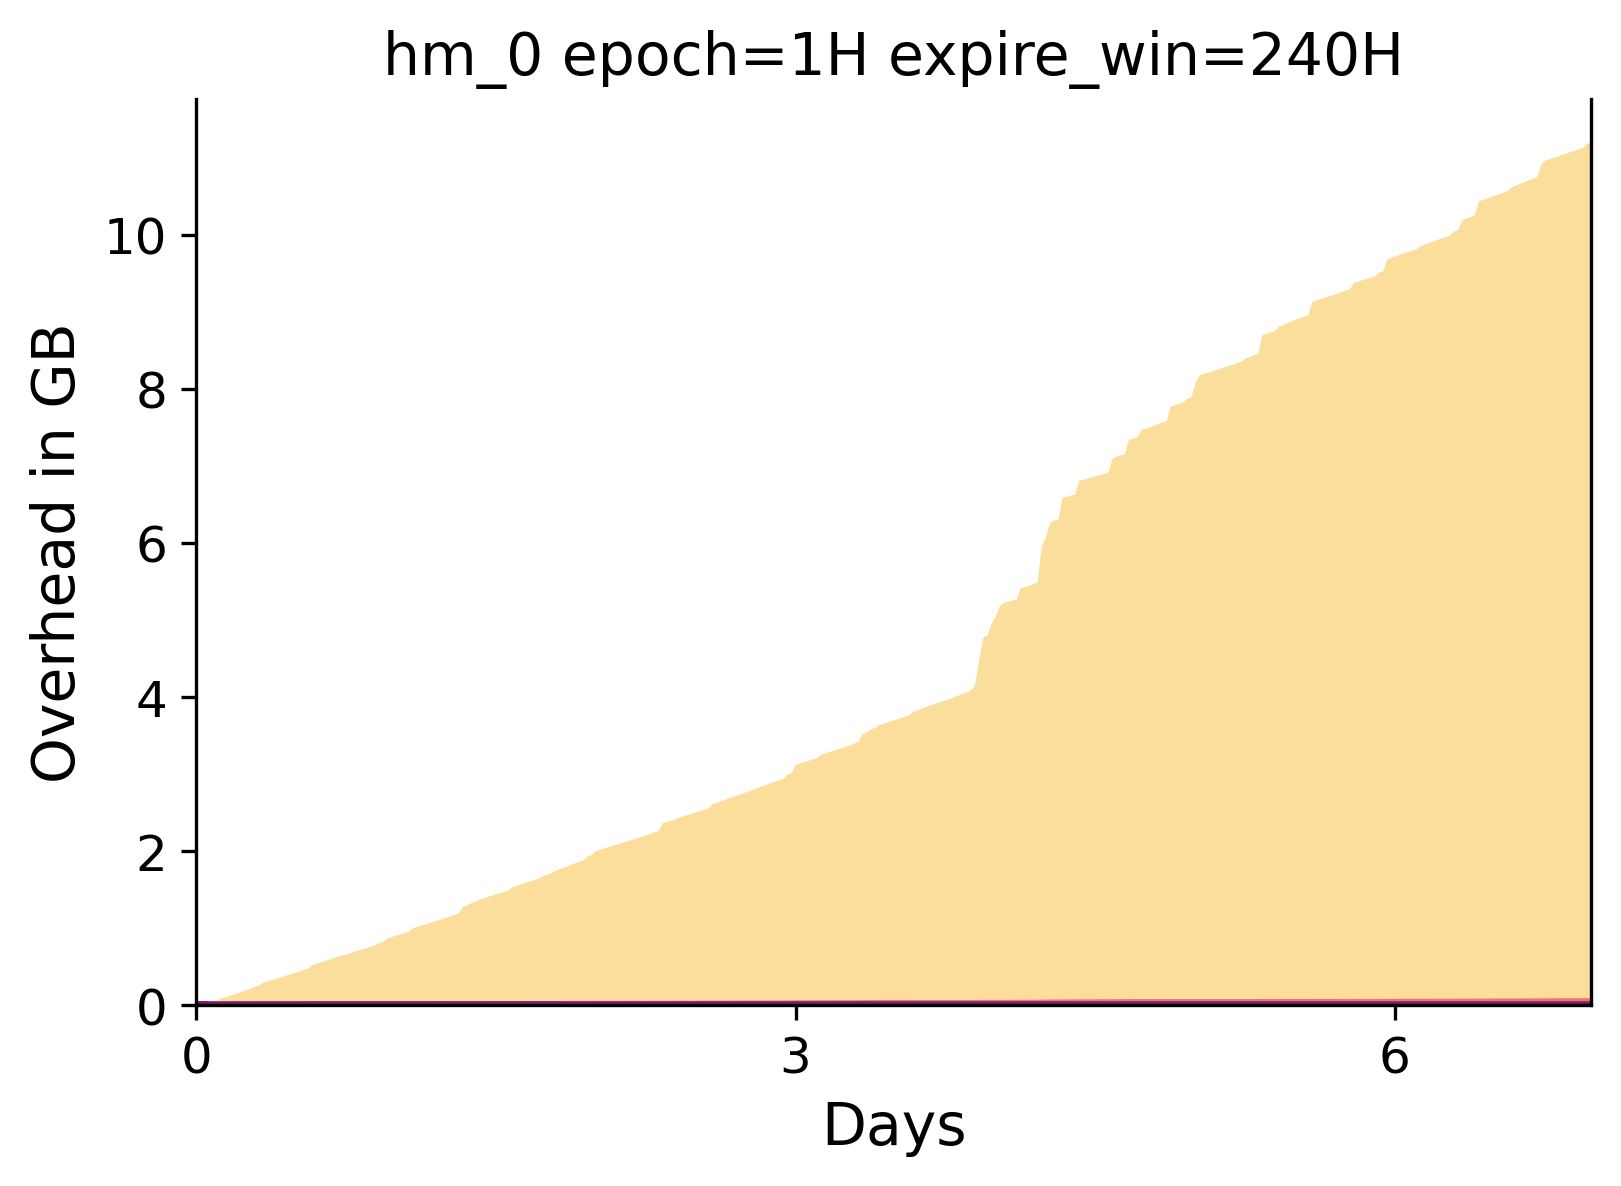

logic_disk_usage_GB:  15
max_version_FS:  26.148749392
written GB:  1.749352448
read GB:  1.975177216
old versions GB:  11.107667968
TL Metadata GB:  0.029296875
Versioning Metadata GB:  0.041081424
filesystem size GB:  15


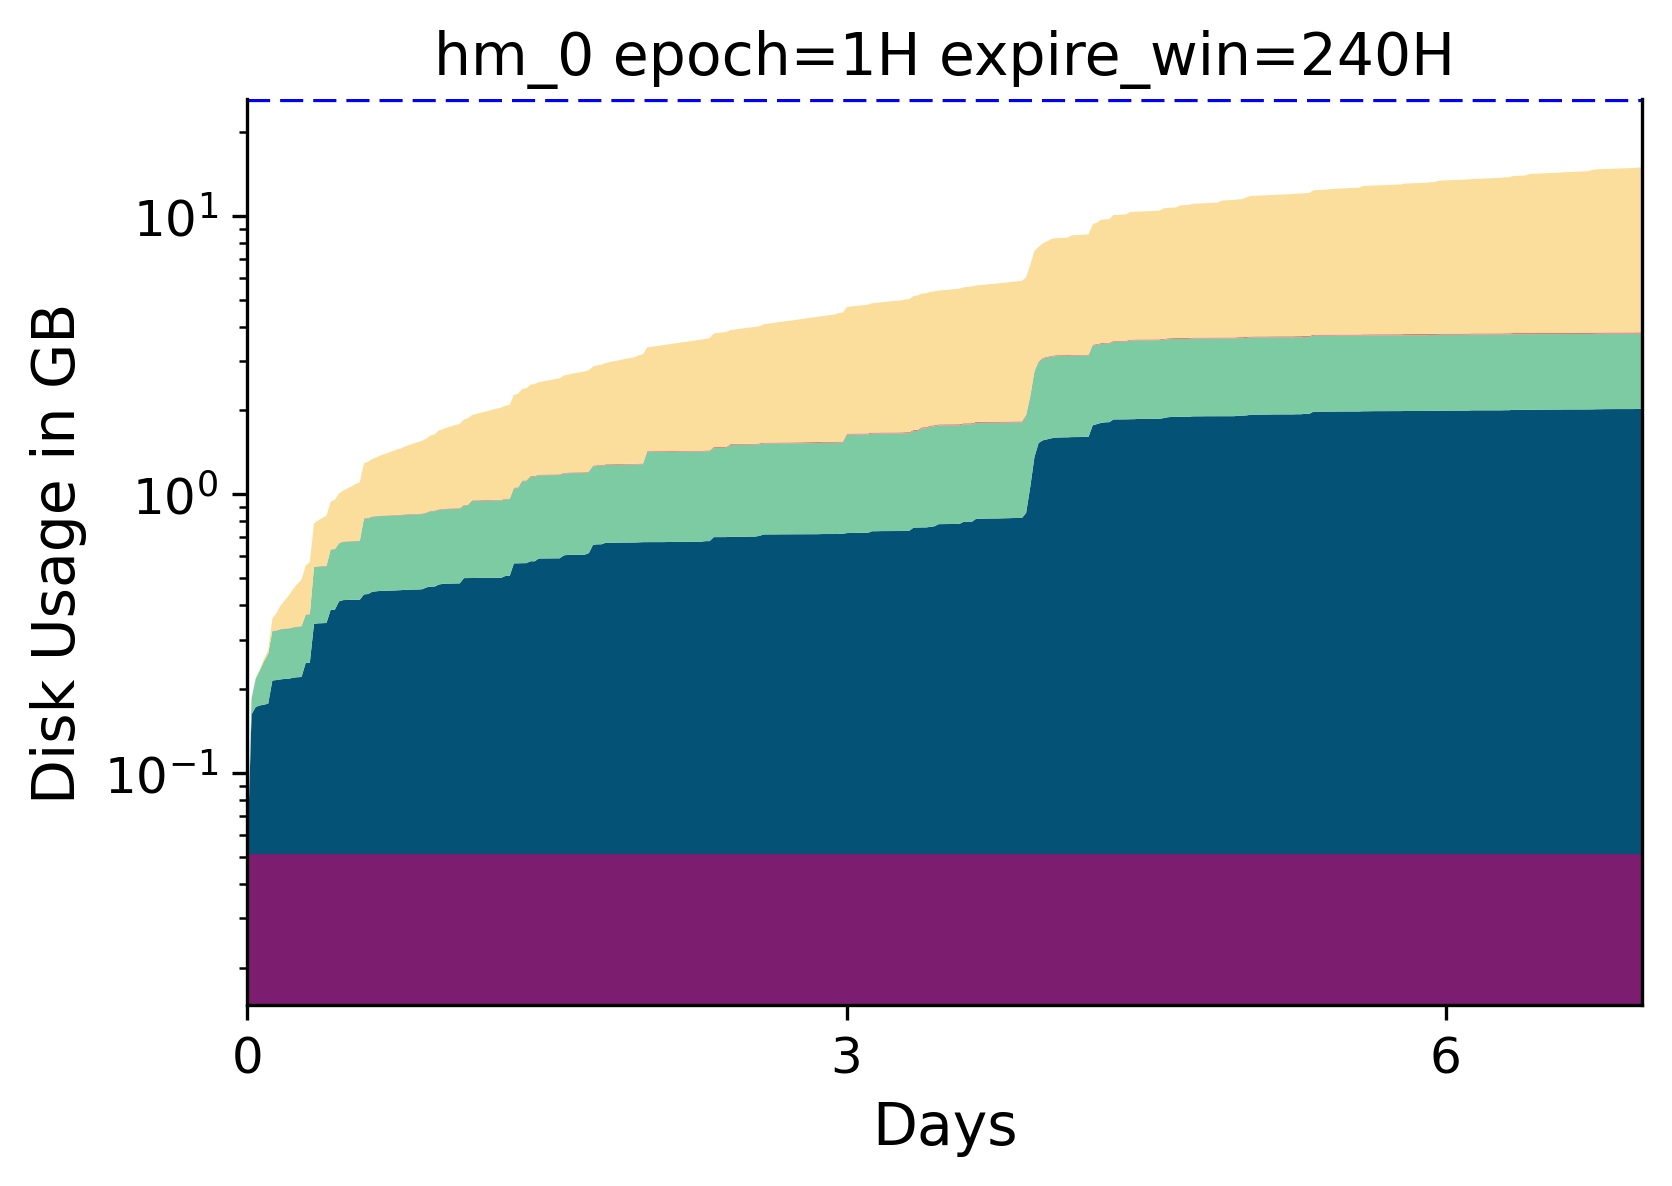

In [4]:
import glob
from analyze_versioning import plot_blocks_over_time
# Find all files matching the pattern
files = glob.glob('MSR-Cambridge/**/*.trend', recursive=True)

# Define the setups
setups = [True, "False", "Log"]


log_disk_space = {
    "hm_0": 15,
    "hm_1": 28,
    "prn_0": 72,
    "prn_1": 460,
    "proj_0": 18,
    "proj_1": 880,
    "proj_2": 880,
}

disk_breakdown = {}

import os
# Iterate over each file and each setup
for file in files:
    for setup in setups:
        test_case = os.path.splitext(os.path.basename(file))[0].split('-')[0]
        entry = plot_blocks_over_time(file, log_disk_space[test_case], setup)
        disk_breakdown[file] = entry

In [ ]:

from analyze_versioning import plot_blocks_over_time
plot_blocks_over_time('homes/homes-1H-48H.trend', 470)
# plot_blocks_over_time('homes/homes-0H-48H.trend', 470)
# plot_blocks_over_time('homes/homes-1H-240H.trend', 470)
# plot_blocks_over_time('homes/homes-0H-240H.trend', 470)



plot_blocks_over_time('homes/homes-1H-48H.trend', 470, "False")
# plot_blocks_over_time('homes/homes-0H-48H.trend', 470, False)
# plot_blocks_over_time('homes/homes-1H-240H.trend', 470, "False")
# plot_blocks_over_time('homes/homes-0H-240H.trend', 470, False)


plot_blocks_over_time('homes/homes-1H-48H.trend', 470, "Log")

In [ ]:
from analyze_versioning import plot_blocks_over_time
plot_blocks_over_time('web/web-1H-48H.trend', 70)
plot_blocks_over_time('web/web-0H-240H.trend', 70)
plot_blocks_over_time('web/web-1H-240H.trend', 70)
plot_blocks_over_time('web/web-0H-1200H.trend', 70, True)

plot_blocks_over_time('web/web-1H-48H.trend', 70, "False")
plot_blocks_over_time('web/web-0H-240H.trend', 70, "False")
plot_blocks_over_time('web/web-1H-240H.trend', 70, "False")
plot_blocks_over_time('web/web-0H-1200H.trend', 70, "False")


plot_blocks_over_time('web/web-1H-48H.trend', 70, "Log")
plot_blocks_over_time('web/web-0H-240H.trend', 70, "Log")
plot_blocks_over_time('web/web-1H-240H.trend', 70, "Log")
plot_blocks_over_time('web/web-0H-1200H.trend', 70, "Log")

In [ ]:
from analyze_versioning import plot_blocks_over_time
plot_blocks_over_time('mail/mail0-1H-48H.trend', 500)
# plot_blocks_over_time('mail/mail0-1H-240H.trend', 500)


plot_blocks_over_time('mail/mail0-1H-48H.trend', 500, "False")
# plot_blocks_over_time('mail/mail0-1H-240H.trend', 500, "False")

plot_blocks_over_time('mail/mail0-1H-48H.trend', 500, "Log")